In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [4]:
train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_train.csv', delimiter = ',')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_train_hml.csv')
train_target = train_target[['RIF_MIC']]
# don't touch test data, split out validation data from training data during training
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test_pca4k.csv', delimiter = ',')
test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test.csv', delimiter = ',')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_test_hml.csv')
test_target = test_target[['RIF_MIC']]

In [8]:
# valid_indices = train_target.dropna().index
# train_target = train_target.loc[valid_indices]
# train_data = train_data[valid_indices]

# valid_indices = test_target.dropna().index
# test_target = test_target.loc[valid_indices]
# test_data = test_data[valid_indices] 

In [6]:
N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [7]:
# def one_hot_torch(seq: str, dtype=torch.int8):
#     seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
#     acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#     arr = torch.zeros(6, (len(seq_bytes)), dtype=dtype)
#     arr[0, seq_bytes == acgt_bytes[0]] = 1
#     arr[1, seq_bytes == acgt_bytes[1]] = 1
#     arr[2, seq_bytes == acgt_bytes[2]] = 1
#     arr[3, seq_bytes == acgt_bytes[3]] = 1
#     arr[4, seq_bytes == acgt_bytes[3]] = 1
#     arr[5, seq_bytes == acgt_bytes[3]] = 1
#     return arr



# def one_hot_torch(category: int, num_categories: int = 6, dtype=torch.int8):
#     # Ensure the category is valid
#     category -= 1
#     if not (0 <= category < num_categories):
#         raise ValueError("Category out of range")

#     # Create a tensor of zeros with shape (num_categories,)
#     arr = torch.zeros(num_categories, dtype=dtype)
    
#     # Set the corresponding category index to 1
#     arr[category] = 1
#     return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )



# Dateset

In [32]:
# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

### Weighted masked loss

In [42]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['RIF_MIC'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

In [37]:
input = torch.randn(2, 2, requires_grad=True)#.to(device)
target = torch.randint(2, (2,), dtype=torch.int64)#.to(device)
loss = F.cross_entropy(input, target)
print(loss)
input = input
target = target
print(input, target)
weighted_cross_entropy_loss_fn(input, target)

tensor(0.8105, grad_fn=<NllLossBackward0>)
tensor([[-0.5534,  0.6730],
        [ 1.7429, -0.1722]], requires_grad=True) tensor([0, 0])
tensor([0, 0])


tensor(0.0382, device='cuda:0', grad_fn=<MeanBackward0>)

# Model

In [10]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

In [58]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [current_num_filters2]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        
        x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

model = Model(
num_classes=4,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0,
dense_dropout_rate=0
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

epoch = 900
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-7

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn

# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=0)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo

# Training

### Training

In [54]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())
        loss_train = criterion(pred,y_batch)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_mae-binned-rif_newdata' ,epoch, lr=1e-4, fcdr=0.2, l2=1e-9, cnndr=0, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

  0%|          | 1/900 [00:07<1:59:46,  7.99s/it]

Epoch 1
Training loss: 0.16093988716602325
Validation loss: 0.484196275472641


  0%|          | 2/900 [00:16<1:59:53,  8.01s/it]

Epoch 2
Training loss: 0.16120857000350952
Validation loss: 0.1636504977941513


  0%|          | 3/900 [00:24<1:59:37,  8.00s/it]

Epoch 3
Training loss: 0.16094286739826202
Validation loss: 0.17115800082683563


  0%|          | 4/900 [00:32<1:59:31,  8.00s/it]

Epoch 4
Training loss: 0.1601513922214508
Validation loss: 0.16707897186279297


  1%|          | 5/900 [00:40<1:59:21,  8.00s/it]

Epoch 5
Training loss: 0.16082949936389923
Validation loss: 0.17194388806819916


  1%|          | 6/900 [00:48<1:59:21,  8.01s/it]

Epoch 6
Training loss: 0.16031990945339203
Validation loss: 0.1655970811843872


  1%|          | 7/900 [00:56<1:59:08,  8.00s/it]

Epoch 7
Training loss: 0.1602899432182312
Validation loss: 0.16966943442821503


  1%|          | 8/900 [01:03<1:58:44,  7.99s/it]

Epoch 8
Training loss: 0.1605576127767563
Validation loss: 0.17140381038188934


  1%|          | 9/900 [01:11<1:58:37,  7.99s/it]

Epoch 9
Training loss: 0.16007696092128754
Validation loss: 0.17047546803951263


  1%|          | 10/900 [01:19<1:58:20,  7.98s/it]

Epoch 10
Training loss: 0.15980127453804016
Validation loss: 0.16865676641464233


  1%|          | 11/900 [01:27<1:58:12,  7.98s/it]

Epoch 11
Training loss: 0.15931303799152374
Validation loss: 0.16862516105175018


  1%|▏         | 12/900 [01:35<1:58:02,  7.98s/it]

Epoch 12
Training loss: 0.16057245433330536
Validation loss: 0.16632330417633057


  1%|▏         | 13/900 [01:43<1:58:09,  7.99s/it]

Epoch 13
Training loss: 0.15939347445964813
Validation loss: 0.16799263656139374


  2%|▏         | 14/900 [01:51<1:57:59,  7.99s/it]

Epoch 14
Training loss: 0.1591545194387436
Validation loss: 0.17201831936836243


  2%|▏         | 15/900 [01:59<1:57:46,  7.98s/it]

Epoch 15
Training loss: 0.15970920026302338
Validation loss: 0.16625986993312836


  2%|▏         | 16/900 [02:07<1:57:27,  7.97s/it]

Epoch 16
Training loss: 0.15925493836402893
Validation loss: 0.1708335131406784


  2%|▏         | 17/900 [02:15<1:57:11,  7.96s/it]

Epoch 17
Training loss: 0.15991738438606262
Validation loss: 0.16801142692565918


  2%|▏         | 18/900 [02:23<1:57:04,  7.96s/it]

Epoch 18
Training loss: 0.1589781492948532
Validation loss: 0.1657935231924057


  2%|▏         | 19/900 [02:31<1:56:57,  7.97s/it]

Epoch 19
Training loss: 0.15890684723854065
Validation loss: 0.16502346098423004


  2%|▏         | 20/900 [02:39<1:57:02,  7.98s/it]

Epoch 20
Training loss: 0.15928594768047333
Validation loss: 0.16497793793678284


  2%|▏         | 21/900 [02:47<1:56:55,  7.98s/it]

Epoch 21
Training loss: 0.15904346108436584
Validation loss: 0.17278917133808136


  2%|▏         | 22/900 [02:55<1:56:34,  7.97s/it]

Epoch 22
Training loss: 0.15924936532974243
Validation loss: 0.16762113571166992


  3%|▎         | 23/900 [03:03<1:56:25,  7.96s/it]

Epoch 23
Training loss: 0.15939143300056458
Validation loss: 0.16864752769470215


  3%|▎         | 24/900 [03:11<1:56:25,  7.97s/it]

Epoch 24
Training loss: 0.15931667387485504
Validation loss: 0.16869042813777924


  3%|▎         | 25/900 [03:19<1:56:12,  7.97s/it]

Epoch 25
Training loss: 0.15831570327281952
Validation loss: 0.16631260514259338


  3%|▎         | 26/900 [03:27<1:56:10,  7.98s/it]

Epoch 26
Training loss: 0.15941087901592255
Validation loss: 0.16578184068202972


  3%|▎         | 27/900 [03:35<1:56:06,  7.98s/it]

Epoch 27
Training loss: 0.15841397643089294
Validation loss: 0.16608010232448578


  3%|▎         | 28/900 [03:43<1:55:55,  7.98s/it]

Epoch 28
Training loss: 0.15872445702552795
Validation loss: 0.16718757152557373


  3%|▎         | 29/900 [03:51<1:55:57,  7.99s/it]

Epoch 29
Training loss: 0.15898427367210388
Validation loss: 0.17024588584899902


  3%|▎         | 30/900 [03:59<1:55:51,  7.99s/it]

Epoch 30
Training loss: 0.15823504328727722
Validation loss: 0.1676570624113083


  3%|▎         | 31/900 [04:07<1:55:40,  7.99s/it]

Epoch 31
Training loss: 0.15887708961963654
Validation loss: 0.16711421310901642


  4%|▎         | 32/900 [04:15<1:55:20,  7.97s/it]

Epoch 32
Training loss: 0.15850766003131866
Validation loss: 0.16512256860733032


  4%|▎         | 33/900 [04:23<1:55:07,  7.97s/it]

Epoch 33
Training loss: 0.15812397003173828
Validation loss: 0.16112397611141205


  4%|▍         | 34/900 [04:31<1:55:06,  7.98s/it]

Epoch 34
Training loss: 0.15821322798728943
Validation loss: 0.1631065458059311


  4%|▍         | 35/900 [04:39<1:55:08,  7.99s/it]

Epoch 35
Training loss: 0.15845783054828644
Validation loss: 0.16678600013256073


  4%|▍         | 36/900 [04:47<1:54:58,  7.98s/it]

Epoch 36
Training loss: 0.15822376310825348
Validation loss: 0.1691981703042984


  4%|▍         | 37/900 [04:55<1:54:49,  7.98s/it]

Epoch 37
Training loss: 0.15816116333007812
Validation loss: 0.16759736835956573


  4%|▍         | 38/900 [05:03<1:54:47,  7.99s/it]

Epoch 38
Training loss: 0.15815387666225433
Validation loss: 0.16759736835956573


  4%|▍         | 39/900 [05:11<1:54:42,  7.99s/it]

Epoch 39
Training loss: 0.15789957344532013
Validation loss: 0.16401366889476776


  4%|▍         | 40/900 [05:19<1:54:24,  7.98s/it]

Epoch 40
Training loss: 0.15758556127548218
Validation loss: 0.16791962087154388


  5%|▍         | 41/900 [05:27<1:54:10,  7.97s/it]

Epoch 41
Training loss: 0.15722081065177917
Validation loss: 0.1659228801727295


  5%|▍         | 42/900 [05:35<1:53:59,  7.97s/it]

Epoch 42
Training loss: 0.15737298130989075
Validation loss: 0.16690734028816223


  5%|▍         | 43/900 [05:43<1:53:49,  7.97s/it]

Epoch 43
Training loss: 0.15770110487937927
Validation loss: 0.16641756892204285


  5%|▍         | 44/900 [05:51<1:53:45,  7.97s/it]

Epoch 44
Training loss: 0.15739236772060394
Validation loss: 0.1670650690793991


  5%|▌         | 45/900 [05:59<1:53:40,  7.98s/it]

Epoch 45
Training loss: 0.15745927393436432
Validation loss: 0.1677575558423996


  5%|▌         | 46/900 [06:07<1:53:34,  7.98s/it]

Epoch 46
Training loss: 0.15767155587673187
Validation loss: 0.16090169548988342


  5%|▌         | 47/900 [06:15<1:53:22,  7.97s/it]

Epoch 47
Training loss: 0.15801113843917847
Validation loss: 0.16656823456287384


  5%|▌         | 48/900 [06:23<1:53:22,  7.98s/it]

Epoch 48
Training loss: 0.15774324536323547
Validation loss: 0.16404463350772858


  5%|▌         | 49/900 [06:31<1:53:02,  7.97s/it]

Epoch 49
Training loss: 0.15724675357341766
Validation loss: 0.16355307400226593


  6%|▌         | 50/900 [06:39<1:52:53,  7.97s/it]

Epoch 50
Training loss: 0.15702474117279053
Validation loss: 0.16328370571136475


  6%|▌         | 51/900 [06:46<1:52:50,  7.98s/it]

Epoch 51
Training loss: 0.1568005532026291
Validation loss: 0.1682107299566269


  6%|▌         | 52/900 [06:55<1:52:52,  7.99s/it]

Epoch 52
Training loss: 0.15730105340480804
Validation loss: 0.1658078134059906


  6%|▌         | 53/900 [07:03<1:52:55,  8.00s/it]

Epoch 53
Training loss: 0.15751391649246216
Validation loss: 0.1640380471944809


  6%|▌         | 54/900 [07:11<1:52:40,  7.99s/it]

Epoch 54
Training loss: 0.1575806885957718
Validation loss: 0.16136464476585388


  6%|▌         | 55/900 [07:18<1:52:18,  7.97s/it]

Epoch 55
Training loss: 0.1572679579257965
Validation loss: 0.16411958634853363


  6%|▌         | 56/900 [07:26<1:52:25,  7.99s/it]

Epoch 56
Training loss: 0.15669141709804535
Validation loss: 0.16299788653850555


  6%|▋         | 57/900 [07:34<1:52:03,  7.98s/it]

Epoch 57
Training loss: 0.15715745091438293
Validation loss: 0.16580668091773987


  6%|▋         | 58/900 [07:42<1:51:54,  7.97s/it]

Epoch 58
Training loss: 0.15697474777698517
Validation loss: 0.1650826334953308


  7%|▋         | 59/900 [07:50<1:51:37,  7.96s/it]

Epoch 59
Training loss: 0.1570972353219986
Validation loss: 0.16710937023162842


  7%|▋         | 60/900 [07:58<1:51:39,  7.98s/it]

Epoch 60
Training loss: 0.1562890261411667
Validation loss: 0.1684672087430954


  7%|▋         | 61/900 [08:06<1:51:28,  7.97s/it]

Epoch 61
Training loss: 0.1566482037305832
Validation loss: 0.1663067489862442


  7%|▋         | 62/900 [08:14<1:51:15,  7.97s/it]

Epoch 62
Training loss: 0.15630413591861725
Validation loss: 0.16701355576515198


  7%|▋         | 63/900 [08:22<1:51:03,  7.96s/it]

Epoch 63
Training loss: 0.15639084577560425
Validation loss: 0.166695237159729


  7%|▋         | 64/900 [08:30<1:50:54,  7.96s/it]

Epoch 64
Training loss: 0.1565072238445282
Validation loss: 0.16551987826824188


  7%|▋         | 65/900 [08:38<1:50:42,  7.96s/it]

Epoch 65
Training loss: 0.1567319929599762
Validation loss: 0.16508592665195465


  7%|▋         | 66/900 [08:46<1:50:45,  7.97s/it]

Epoch 66
Training loss: 0.15611298382282257
Validation loss: 0.16532626748085022


  7%|▋         | 67/900 [08:54<1:50:39,  7.97s/it]

Epoch 67
Training loss: 0.15649062395095825
Validation loss: 0.16187013685703278


  8%|▊         | 68/900 [09:02<1:50:35,  7.98s/it]

Epoch 68
Training loss: 0.15696051716804504
Validation loss: 0.16365449130535126


  8%|▊         | 69/900 [09:10<1:50:25,  7.97s/it]

Epoch 69
Training loss: 0.15653660893440247
Validation loss: 0.16317449510097504


  8%|▊         | 70/900 [09:18<1:50:42,  8.00s/it]

Epoch 70
Training loss: 0.15610627830028534
Validation loss: 0.16552817821502686


  8%|▊         | 71/900 [09:26<1:50:27,  7.99s/it]

Epoch 71
Training loss: 0.156397745013237
Validation loss: 0.1648273468017578


  8%|▊         | 72/900 [09:34<1:50:27,  8.00s/it]

Epoch 72
Training loss: 0.15662911534309387
Validation loss: 0.1663958579301834


  8%|▊         | 73/900 [09:42<1:50:09,  7.99s/it]

Epoch 73
Training loss: 0.15600115060806274
Validation loss: 0.16453583538532257


  8%|▊         | 74/900 [09:50<1:49:50,  7.98s/it]

Epoch 74
Training loss: 0.15654534101486206
Validation loss: 0.1652250587940216


  8%|▊         | 75/900 [09:58<1:49:50,  7.99s/it]

Epoch 75
Training loss: 0.15546604990959167
Validation loss: 0.16496704518795013


  8%|▊         | 76/900 [10:06<1:49:46,  7.99s/it]

Epoch 76
Training loss: 0.15624573826789856
Validation loss: 0.16330765187740326


  9%|▊         | 77/900 [10:14<1:49:37,  7.99s/it]

Epoch 77
Training loss: 0.1555538773536682
Validation loss: 0.16544793546199799


  9%|▊         | 78/900 [10:22<1:49:24,  7.99s/it]

Epoch 78
Training loss: 0.15557362139225006
Validation loss: 0.1630580872297287


  9%|▉         | 79/900 [10:30<1:49:04,  7.97s/it]

Epoch 79
Training loss: 0.15583372116088867
Validation loss: 0.16346387565135956


  9%|▉         | 80/900 [10:38<1:49:02,  7.98s/it]

Epoch 80
Training loss: 0.15643081068992615
Validation loss: 0.16692396998405457


  9%|▉         | 81/900 [10:46<1:49:05,  7.99s/it]

Epoch 81
Training loss: 0.15599581599235535
Validation loss: 0.16364482045173645


  9%|▉         | 82/900 [10:54<1:48:53,  7.99s/it]

Epoch 82
Training loss: 0.15550632774829865
Validation loss: 0.16528132557868958


  9%|▉         | 83/900 [11:02<1:48:41,  7.98s/it]

Epoch 83
Training loss: 0.15548445284366608
Validation loss: 0.16390220820903778


  9%|▉         | 84/900 [11:10<1:48:21,  7.97s/it]

Epoch 84
Training loss: 0.15587963163852692
Validation loss: 0.16288085281848907


  9%|▉         | 85/900 [11:18<1:48:14,  7.97s/it]

Epoch 85
Training loss: 0.15603116154670715
Validation loss: 0.16818027198314667


 10%|▉         | 86/900 [11:26<1:48:24,  7.99s/it]

Epoch 86
Training loss: 0.15546070039272308
Validation loss: 0.16345170140266418


 10%|▉         | 87/900 [11:34<1:48:13,  7.99s/it]

Epoch 87
Training loss: 0.15533111989498138
Validation loss: 0.16273970901966095


 10%|▉         | 88/900 [11:42<1:48:02,  7.98s/it]

Epoch 88
Training loss: 0.15589968860149384
Validation loss: 0.16451895236968994


 10%|▉         | 89/900 [11:50<1:47:52,  7.98s/it]

Epoch 89
Training loss: 0.15525807440280914
Validation loss: 0.16485941410064697


 10%|█         | 90/900 [11:58<1:47:38,  7.97s/it]

Epoch 90
Training loss: 0.15556101500988007
Validation loss: 0.15909849107265472


 10%|█         | 91/900 [12:06<1:47:40,  7.99s/it]

Epoch 91
Training loss: 0.1549595445394516
Validation loss: 0.16334472596645355


 10%|█         | 92/900 [12:14<1:47:34,  7.99s/it]

Epoch 92
Training loss: 0.15537157654762268
Validation loss: 0.16309069097042084


 10%|█         | 93/900 [12:22<1:47:29,  7.99s/it]

Epoch 93
Training loss: 0.15567585825920105
Validation loss: 0.16346006095409393


 10%|█         | 94/900 [12:30<1:47:16,  7.99s/it]

Epoch 94
Training loss: 0.15532858669757843
Validation loss: 0.16003017127513885


 11%|█         | 95/900 [12:38<1:47:05,  7.98s/it]

Epoch 95
Training loss: 0.15583057701587677
Validation loss: 0.1649695783853531


 11%|█         | 96/900 [12:46<1:46:52,  7.98s/it]

Epoch 96
Training loss: 0.1554851233959198
Validation loss: 0.16298402845859528


 11%|█         | 97/900 [12:54<1:46:44,  7.98s/it]

Epoch 97
Training loss: 0.1556539386510849
Validation loss: 0.16343490779399872


 11%|█         | 98/900 [13:02<1:46:37,  7.98s/it]

Epoch 98
Training loss: 0.15590068697929382
Validation loss: 0.16301000118255615


 11%|█         | 98/900 [13:07<1:47:22,  8.03s/it]


KeyboardInterrupt: 

./graphs1/loss_lr_0.0001.png


/tmp/ipykernel_48980/4118118722.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


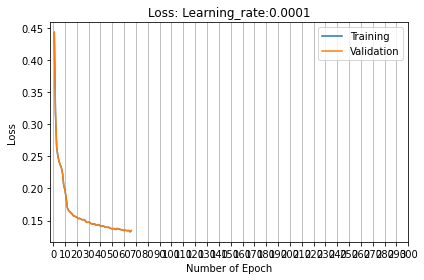

In [ ]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, len(np.array(train_epoch_loss).flatten())+1, 1)
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Training')
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

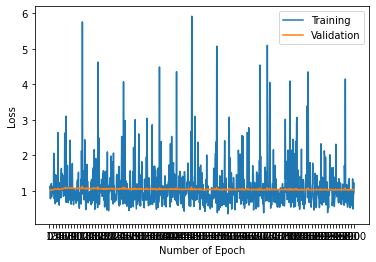

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

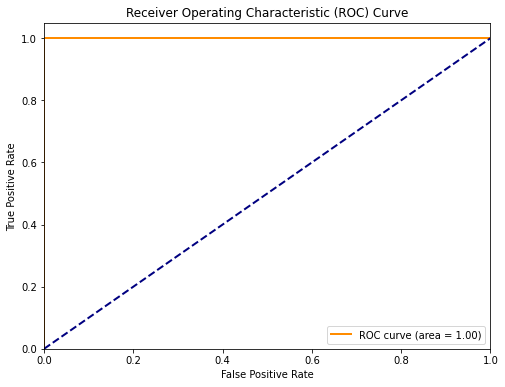

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

In [40]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Wed Mar 27 14:12:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   1221MiB / 32510MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [55]:

def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    ic.disable()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,a
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=4,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)
    # criterion = nn.MSELoss()
    criterion = weighted_cross_entropy_loss_fn
    # criterion = F.cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    
    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            x_batch = x_batch.float()
            pred = model(x_batch.float())
            # print(pred)
            loss_train = criterion(pred, y_batch)
            # print(y_batch)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                # if np.isnan(y_batch):
                #     continue
                # print(x_batch.size())
                y_batch = y_test.to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())

                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                loss_test = criterion(pred, y_batch)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    
     #! testing benchmark
    # testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
    # testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
    # drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    # drugs = ['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']

    # model.eval()
    # pred_list = []
    # target_list = []
    # mse_list = []
    # with torch.no_grad():
    #     for x_test, y_test in testing_loader1:
    #         xtest1 = x_test.to(device).float()
    #         ytest1 = y_test.to(device).float()
    #         pred = model(xtest1)
    #         pred_list.append(pred.detach().cpu().numpy()) 
    #         target_list.append(y_test.detach().cpu().numpy())

    # pred_list = np.array(pred_list).squeeze()
    # target_list = np.array(target_list).squeeze()
    # mse_list = (pred_list - target_list)**2
    # mse_out = np.nanmean(mse_list, axis=0)

    # result = find_range_vectorized(target_list, pred_list)

    # # Append output to a file
    # with open('trials3.txt', 'a') as f:
    #     mse_drug_output = f"====MIC-mse: {drugs} {np.mean(mse_out)}\n"
    #     f.write(mse_drug_output)        
    #     ea_accuracy_output = f"====EA-accuracy: {drugs} {np.nanmean(result, axis=0)}\n"
    #     f.write(ea_accuracy_output)
    #     print(mse_drug_output)
    #     print(ea_accuracy_output)
    #     # for x, y in zip(drugs, np.nanmean(result, axis=0).tolist()):
    #     #     print(x, y)                    
            
        # fig, ax = plt.subplots()
        # x = np.arange(1, epoch+1, 1)
        # ax.plot(x, train_epoch_loss,label='Training')
        # # ax.plot(x, test_epoch_loss,label='Validation')
        # ax.legend()
        # ax.set_xlabel("Number of Epoch")
        # ax.set_ylabel("Loss")
        # ax.set_xticks(np.arange(0, epoch+1, 10))
        # ax.set_title(f'Loss: Learning_rate:{lr}')
        # # ax_2 = ax.twinx()
        # # ax_2.plot(history["lr"], "k--", lw=1)
        # # ax_2.set_yscale("log")
        # # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
        # ax.grid(axis="x")
        # fig.tight_layout()
        # fig.show()
        # fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
        # print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)

    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/{appendix}-{epoch}-{lr}-{cnn_dr}-{fc_dr}-{l2}_balanced-rif-bi-ag-ce.pth')

In [57]:
torch.cuda.empty_cache()
import gc; gc.collect()

# epoch = 250
# for lr in [1e-4]:
#     for fc_dr in [0.2]:
#         for decay in [1e-9]:
#             for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
#                 hyper_params_test('64-2-256-2-128-log-reg-weighted_balanced', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

epoch = 300
for lr in [ 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
    for fc_dr in [0]:
        for decay in [0]:
            hyper_params_test('aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)
# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

lr: 1e-05 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:07<39:51,  8.00s/it]

Epoch 1
Training loss: 0.18109048902988434
Validation loss: 0.27866291999816895


  1%|          | 2/300 [00:15<39:40,  7.99s/it]

Epoch 2
Training loss: 0.1735440194606781
Validation loss: 0.1772753745317459


  1%|          | 3/300 [00:23<39:33,  7.99s/it]

Epoch 3
Training loss: 0.16884754598140717
Validation loss: 0.17554841935634613


  1%|▏         | 4/300 [00:31<39:19,  7.97s/it]

Epoch 4
Training loss: 0.16522201895713806
Validation loss: 0.1720660775899887


  2%|▏         | 5/300 [00:39<39:09,  7.97s/it]

Epoch 5
Training loss: 0.16240094602108002
Validation loss: 0.16914352774620056


  2%|▏         | 6/300 [00:47<39:07,  7.98s/it]

Epoch 6
Training loss: 0.160251185297966
Validation loss: 0.16834284365177155


  2%|▏         | 7/300 [00:55<38:59,  7.98s/it]

Epoch 7
Training loss: 0.158070906996727
Validation loss: 0.16984806954860687


  3%|▎         | 8/300 [01:03<38:48,  7.97s/it]

Epoch 8
Training loss: 0.15612007677555084
Validation loss: 0.16741397976875305


  3%|▎         | 9/300 [01:11<38:41,  7.98s/it]

Epoch 9
Training loss: 0.1544836312532425
Validation loss: 0.1656186580657959


  3%|▎         | 10/300 [01:19<38:32,  7.97s/it]

Epoch 10
Training loss: 0.15305271744728088
Validation loss: 0.1616559475660324


  4%|▎         | 11/300 [01:27<38:22,  7.97s/it]

Epoch 11
Training loss: 0.15170776844024658
Validation loss: 0.16570882499217987


  4%|▍         | 12/300 [01:35<38:15,  7.97s/it]

Epoch 12
Training loss: 0.15059752762317657
Validation loss: 0.16291961073875427


  4%|▍         | 13/300 [01:43<38:18,  8.01s/it]

Epoch 13
Training loss: 0.14923156797885895
Validation loss: 0.16434553265571594


  5%|▍         | 14/300 [01:51<38:06,  7.99s/it]

Epoch 14
Training loss: 0.14844444394111633
Validation loss: 0.16433878242969513


  5%|▌         | 15/300 [01:59<37:58,  7.99s/it]

Epoch 15
Training loss: 0.1482032835483551
Validation loss: 0.16254667937755585


  5%|▌         | 16/300 [02:07<37:53,  8.01s/it]

Epoch 16
Training loss: 0.14738959074020386
Validation loss: 0.1607406735420227


  6%|▌         | 17/300 [02:15<37:49,  8.02s/it]

Epoch 17
Training loss: 0.1466047614812851
Validation loss: 0.1596829742193222


  6%|▌         | 18/300 [02:23<37:37,  8.01s/it]

Epoch 18
Training loss: 0.14588108658790588
Validation loss: 0.16164405643939972


  6%|▋         | 19/300 [02:31<37:34,  8.02s/it]

Epoch 19
Training loss: 0.14513623714447021
Validation loss: 0.15746735036373138


  7%|▋         | 20/300 [02:39<37:22,  8.01s/it]

Epoch 20
Training loss: 0.14467425644397736
Validation loss: 0.1609480082988739


  7%|▋         | 21/300 [02:47<37:11,  8.00s/it]

Epoch 21
Training loss: 0.14381396770477295
Validation loss: 0.16280941665172577


  7%|▋         | 22/300 [02:55<37:03,  8.00s/it]

Epoch 22
Training loss: 0.14320994913578033
Validation loss: 0.16103415191173553


  8%|▊         | 23/300 [03:03<36:55,  8.00s/it]

Epoch 23
Training loss: 0.14326830208301544
Validation loss: 0.16140350699424744


  8%|▊         | 24/300 [03:11<36:48,  8.00s/it]

Epoch 24
Training loss: 0.14316998422145844
Validation loss: 0.1615842878818512


  8%|▊         | 25/300 [03:20<36:56,  8.06s/it]

Epoch 25
Training loss: 0.14339390397071838
Validation loss: 0.16329891979694366


  9%|▊         | 26/300 [03:28<36:47,  8.06s/it]

Epoch 26
Training loss: 0.142430379986763
Validation loss: 0.1589348465204239


  9%|▉         | 27/300 [03:36<36:39,  8.06s/it]

Epoch 27
Training loss: 0.1422189474105835
Validation loss: 0.16001275181770325


  9%|▉         | 28/300 [03:44<36:24,  8.03s/it]

Epoch 28
Training loss: 0.1417659968137741
Validation loss: 0.16052289307117462


 10%|▉         | 29/300 [03:52<36:14,  8.02s/it]

Epoch 29
Training loss: 0.14139647781848907
Validation loss: 0.16035407781600952


 10%|█         | 30/300 [04:00<36:05,  8.02s/it]

Epoch 30
Training loss: 0.14181049168109894
Validation loss: 0.15967713296413422


 10%|█         | 31/300 [04:08<35:54,  8.01s/it]

Epoch 31
Training loss: 0.14111758768558502
Validation loss: 0.16183696687221527


 11%|█         | 32/300 [04:16<35:41,  7.99s/it]

Epoch 32
Training loss: 0.14059537649154663
Validation loss: 0.1628088802099228


 11%|█         | 33/300 [04:24<35:32,  7.99s/it]

Epoch 33
Training loss: 0.14024899899959564
Validation loss: 0.16061441600322723


 11%|█▏        | 34/300 [04:32<35:25,  7.99s/it]

Epoch 34
Training loss: 0.1405971646308899
Validation loss: 0.16190822422504425


 12%|█▏        | 35/300 [04:40<35:19,  8.00s/it]

Epoch 35
Training loss: 0.14001579582691193
Validation loss: 0.15993772447109222


 12%|█▏        | 36/300 [04:48<35:11,  8.00s/it]

Epoch 36
Training loss: 0.13916908204555511
Validation loss: 0.15875211358070374


 12%|█▏        | 37/300 [04:56<35:02,  7.99s/it]

Epoch 37
Training loss: 0.13954399526119232
Validation loss: 0.15922890603542328


 13%|█▎        | 38/300 [05:03<34:50,  7.98s/it]

Epoch 38
Training loss: 0.13954150676727295
Validation loss: 0.1592366248369217


 13%|█▎        | 39/300 [05:11<34:43,  7.98s/it]

Epoch 39
Training loss: 0.13990987837314606
Validation loss: 0.15726545453071594


 13%|█▎        | 40/300 [05:19<34:34,  7.98s/it]

Epoch 40
Training loss: 0.13931706547737122
Validation loss: 0.16274476051330566


 14%|█▎        | 41/300 [05:27<34:25,  7.97s/it]

Epoch 41
Training loss: 0.13898883759975433
Validation loss: 0.16399620473384857


 14%|█▍        | 42/300 [05:35<34:19,  7.98s/it]

Epoch 42
Training loss: 0.13903355598449707
Validation loss: 0.16433869302272797


 14%|█▍        | 43/300 [05:43<34:12,  7.99s/it]

Epoch 43
Training loss: 0.1388055980205536
Validation loss: 0.16125881671905518


 15%|█▍        | 44/300 [05:51<34:06,  7.99s/it]

Epoch 44
Training loss: 0.13860976696014404
Validation loss: 0.16497647762298584


 15%|█▌        | 45/300 [05:59<33:59,  8.00s/it]

Epoch 45
Training loss: 0.13834135234355927
Validation loss: 0.16566778719425201


 15%|█▌        | 46/300 [06:07<33:48,  7.98s/it]

Epoch 46
Training loss: 0.13826140761375427
Validation loss: 0.1611887812614441


 16%|█▌        | 47/300 [06:15<33:45,  8.01s/it]

Epoch 47
Training loss: 0.1376977115869522
Validation loss: 0.1628105640411377


 16%|█▌        | 48/300 [06:23<33:35,  8.00s/it]

Epoch 48
Training loss: 0.1384575515985489
Validation loss: 0.16183297336101532


 16%|█▋        | 49/300 [06:31<33:26,  8.00s/it]

Epoch 49
Training loss: 0.13808231055736542
Validation loss: 0.1601250171661377


 17%|█▋        | 50/300 [06:39<33:17,  7.99s/it]

Epoch 50
Training loss: 0.1373647302389145
Validation loss: 0.1659214198589325


 17%|█▋        | 51/300 [06:47<33:12,  8.00s/it]

Epoch 51
Training loss: 0.13706077635288239
Validation loss: 0.1627258062362671


 17%|█▋        | 52/300 [06:55<33:05,  8.01s/it]

Epoch 52
Training loss: 0.13748674094676971
Validation loss: 0.16411970555782318


 18%|█▊        | 53/300 [07:03<32:57,  8.01s/it]

Epoch 53
Training loss: 0.13682222366333008
Validation loss: 0.16189369559288025


 18%|█▊        | 54/300 [07:11<32:51,  8.01s/it]

Epoch 54
Training loss: 0.13694067299365997
Validation loss: 0.1670997142791748


 18%|█▊        | 55/300 [07:20<32:45,  8.02s/it]

Epoch 55
Training loss: 0.13634319603443146
Validation loss: 0.16644112765789032


 19%|█▊        | 56/300 [07:27<32:34,  8.01s/it]

Epoch 56
Training loss: 0.13651050627231598
Validation loss: 0.16178277134895325


 19%|█▉        | 57/300 [07:36<32:27,  8.01s/it]

Epoch 57
Training loss: 0.13653269410133362
Validation loss: 0.16505025327205658


 19%|█▉        | 58/300 [07:44<32:20,  8.02s/it]

Epoch 58
Training loss: 0.13638067245483398
Validation loss: 0.16242070496082306


 20%|█▉        | 59/300 [07:52<32:14,  8.03s/it]

Epoch 59
Training loss: 0.1355440318584442
Validation loss: 0.1648167222738266


 20%|██        | 60/300 [08:00<32:04,  8.02s/it]

Epoch 60
Training loss: 0.1365957260131836
Validation loss: 0.1647234708070755


 20%|██        | 61/300 [08:13<38:37,  9.70s/it]

Epoch 61
Training loss: 0.1359509378671646
Validation loss: 0.16787846386432648


 21%|██        | 62/300 [08:29<45:40, 11.52s/it]

Epoch 62
Training loss: 0.13605855405330658
Validation loss: 0.16553394496440887


 21%|██        | 63/300 [08:45<50:31, 12.79s/it]

Epoch 63
Training loss: 0.1355428397655487
Validation loss: 0.16430018842220306


 21%|██▏       | 64/300 [09:01<53:50, 13.69s/it]

Epoch 64
Training loss: 0.13527052104473114
Validation loss: 0.16309741139411926


 22%|██▏       | 65/300 [09:16<56:04, 14.32s/it]

Epoch 65
Training loss: 0.13543564081192017
Validation loss: 0.16264595091342926


 22%|██▏       | 66/300 [09:32<57:26, 14.73s/it]

Epoch 66
Training loss: 0.1350289285182953
Validation loss: 0.16406762599945068


 22%|██▏       | 67/300 [09:48<58:26, 15.05s/it]

Epoch 67
Training loss: 0.13518685102462769
Validation loss: 0.1670028418302536


 23%|██▎       | 68/300 [10:04<59:08, 15.30s/it]

Epoch 68
Training loss: 0.13546393811702728
Validation loss: 0.1641480177640915


 23%|██▎       | 69/300 [10:19<59:26, 15.44s/it]

Epoch 69
Training loss: 0.13490669429302216
Validation loss: 0.16583658754825592


 23%|██▎       | 70/300 [10:35<59:38, 15.56s/it]

Epoch 70
Training loss: 0.1348315328359604
Validation loss: 0.16212953627109528


 24%|██▎       | 71/300 [10:51<59:41, 15.64s/it]

Epoch 71
Training loss: 0.1345059871673584
Validation loss: 0.16250447928905487


 24%|██▍       | 72/300 [11:07<59:26, 15.64s/it]

Epoch 72
Training loss: 0.13492628931999207
Validation loss: 0.16653816401958466


 24%|██▍       | 73/300 [11:23<59:21, 15.69s/it]

Epoch 73
Training loss: 0.1343081295490265
Validation loss: 0.16565275192260742


 25%|██▍       | 74/300 [11:38<59:11, 15.71s/it]

Epoch 74
Training loss: 0.1340073049068451
Validation loss: 0.16859959065914154


 25%|██▌       | 75/300 [11:54<58:58, 15.73s/it]

Epoch 75
Training loss: 0.13413596153259277
Validation loss: 0.1625184863805771


 25%|██▌       | 76/300 [12:10<58:49, 15.76s/it]

Epoch 76
Training loss: 0.13400410115718842
Validation loss: 0.1677883416414261


 26%|██▌       | 77/300 [12:26<58:36, 15.77s/it]

Epoch 77
Training loss: 0.13399827480316162
Validation loss: 0.16710208356380463


 26%|██▌       | 78/300 [12:41<58:20, 15.77s/it]

Epoch 78
Training loss: 0.1341930776834488
Validation loss: 0.16724811494350433


 26%|██▋       | 79/300 [12:57<58:05, 15.77s/it]

Epoch 79
Training loss: 0.13382892310619354
Validation loss: 0.16908322274684906


 27%|██▋       | 80/300 [13:13<57:53, 15.79s/it]

Epoch 80
Training loss: 0.13362650573253632
Validation loss: 0.16166122257709503


 27%|██▋       | 81/300 [13:29<57:38, 15.79s/it]

Epoch 81
Training loss: 0.1335034966468811
Validation loss: 0.1663578599691391


 27%|██▋       | 82/300 [13:45<57:22, 15.79s/it]

Epoch 82
Training loss: 0.13318689167499542
Validation loss: 0.16462342441082


 28%|██▊       | 83/300 [14:00<57:03, 15.78s/it]

Epoch 83
Training loss: 0.1333802193403244
Validation loss: 0.16472844779491425


 28%|██▊       | 84/300 [14:16<56:48, 15.78s/it]

Epoch 84
Training loss: 0.13322356343269348
Validation loss: 0.16637758910655975


 28%|██▊       | 85/300 [14:32<56:31, 15.77s/it]

Epoch 85
Training loss: 0.13293686509132385
Validation loss: 0.16624632477760315


 29%|██▊       | 86/300 [14:48<56:13, 15.76s/it]

Epoch 86
Training loss: 0.13329017162322998
Validation loss: 0.16664443910121918


 29%|██▉       | 87/300 [15:03<55:51, 15.74s/it]

Epoch 87
Training loss: 0.1330665946006775
Validation loss: 0.16919760406017303


 29%|██▉       | 88/300 [15:19<55:39, 15.75s/it]

Epoch 88
Training loss: 0.13333339989185333
Validation loss: 0.1648179292678833


 30%|██▉       | 89/300 [15:35<55:28, 15.77s/it]

Epoch 89
Training loss: 0.13293062150478363
Validation loss: 0.1672896146774292


 30%|███       | 90/300 [15:51<55:17, 15.80s/it]

Epoch 90
Training loss: 0.13286514580249786
Validation loss: 0.16923876106739044


 30%|███       | 91/300 [16:07<54:59, 15.79s/it]

Epoch 91
Training loss: 0.1322268843650818
Validation loss: 0.1673126518726349


 31%|███       | 92/300 [16:22<54:43, 15.79s/it]

Epoch 92
Training loss: 0.13257454335689545
Validation loss: 0.16756725311279297


 31%|███       | 93/300 [16:38<54:31, 15.80s/it]

Epoch 93
Training loss: 0.1333090364933014
Validation loss: 0.16575995087623596


 31%|███▏      | 94/300 [16:54<54:17, 15.81s/it]

Epoch 94
Training loss: 0.13246594369411469
Validation loss: 0.16730201244354248


 32%|███▏      | 95/300 [17:10<54:01, 15.81s/it]

Epoch 95
Training loss: 0.1325976848602295
Validation loss: 0.16791470348834991


 32%|███▏      | 96/300 [17:26<53:47, 15.82s/it]

Epoch 96
Training loss: 0.1322844922542572
Validation loss: 0.16892953217029572


 32%|███▏      | 97/300 [17:42<53:32, 15.83s/it]

Epoch 97
Training loss: 0.13231058418750763
Validation loss: 0.1598527878522873


 33%|███▎      | 98/300 [17:57<53:09, 15.79s/it]

Epoch 98
Training loss: 0.13214989006519318
Validation loss: 0.16826987266540527


 33%|███▎      | 99/300 [18:13<52:51, 15.78s/it]

Epoch 99
Training loss: 0.1318773478269577
Validation loss: 0.16837559640407562


 33%|███▎      | 100/300 [18:29<52:38, 15.79s/it]

Epoch 100
Training loss: 0.13181136548519135
Validation loss: 0.1684155911207199


 34%|███▎      | 101/300 [18:45<52:25, 15.81s/it]

Epoch 101
Training loss: 0.13184306025505066
Validation loss: 0.1711469441652298


 34%|███▍      | 102/300 [19:00<52:06, 15.79s/it]

Epoch 102
Training loss: 0.13124345242977142
Validation loss: 0.1703144609928131


 34%|███▍      | 103/300 [19:16<51:50, 15.79s/it]

Epoch 103
Training loss: 0.13243107497692108
Validation loss: 0.17141760885715485


 35%|███▍      | 104/300 [19:32<51:38, 15.81s/it]

Epoch 104
Training loss: 0.13155464828014374
Validation loss: 0.16815397143363953


 35%|███▌      | 105/300 [19:48<51:22, 15.81s/it]

Epoch 105
Training loss: 0.13166853785514832
Validation loss: 0.16506201028823853


 35%|███▌      | 106/300 [20:04<51:03, 15.79s/it]

Epoch 106
Training loss: 0.13107022643089294
Validation loss: 0.16993896663188934


 36%|███▌      | 107/300 [20:19<50:46, 15.78s/it]

Epoch 107
Training loss: 0.1311981976032257
Validation loss: 0.17219218611717224


 36%|███▌      | 108/300 [20:35<50:28, 15.77s/it]

Epoch 108
Training loss: 0.1313072293996811
Validation loss: 0.17014387249946594


 36%|███▋      | 109/300 [20:51<50:16, 15.79s/it]

Epoch 109
Training loss: 0.13078325986862183
Validation loss: 0.16797670722007751


 37%|███▋      | 110/300 [21:07<50:01, 15.80s/it]

Epoch 110
Training loss: 0.13086548447608948
Validation loss: 0.16570788621902466


 37%|███▋      | 111/300 [21:23<49:42, 15.78s/it]

Epoch 111
Training loss: 0.13129371404647827
Validation loss: 0.17036674916744232


 37%|███▋      | 112/300 [21:38<49:28, 15.79s/it]

Epoch 112
Training loss: 0.1313100904226303
Validation loss: 0.16681994497776031


 38%|███▊      | 113/300 [21:54<49:13, 15.79s/it]

Epoch 113
Training loss: 0.13112396001815796
Validation loss: 0.17278414964675903


 38%|███▊      | 114/300 [22:10<48:55, 15.78s/it]

Epoch 114
Training loss: 0.1310487538576126
Validation loss: 0.1703767031431198


 38%|███▊      | 115/300 [22:26<48:40, 15.79s/it]

Epoch 115
Training loss: 0.13096557557582855
Validation loss: 0.16729383170604706


 39%|███▊      | 116/300 [22:41<48:25, 15.79s/it]

Epoch 116
Training loss: 0.13067381083965302
Validation loss: 0.1718127280473709


 39%|███▉      | 117/300 [22:57<48:09, 15.79s/it]

Epoch 117
Training loss: 0.13053709268569946
Validation loss: 0.17108239233493805


 39%|███▉      | 118/300 [23:13<47:56, 15.81s/it]

Epoch 118
Training loss: 0.13074913620948792
Validation loss: 0.16745169460773468


 40%|███▉      | 119/300 [23:29<47:41, 15.81s/it]

Epoch 119
Training loss: 0.13030549883842468
Validation loss: 0.16891440749168396


 40%|████      | 120/300 [23:45<47:25, 15.81s/it]

Epoch 120
Training loss: 0.1302940398454666
Validation loss: 0.1689508855342865


 40%|████      | 121/300 [24:01<47:08, 15.80s/it]

Epoch 121
Training loss: 0.1299712210893631
Validation loss: 0.17209522426128387


 41%|████      | 122/300 [24:16<46:48, 15.78s/it]

Epoch 122
Training loss: 0.1301528811454773
Validation loss: 0.17019149661064148


 41%|████      | 123/300 [24:32<46:30, 15.77s/it]

Epoch 123
Training loss: 0.13069726526737213
Validation loss: 0.16660265624523163


 41%|████▏     | 124/300 [24:48<46:17, 15.78s/it]

Epoch 124
Training loss: 0.1300613135099411
Validation loss: 0.17555488646030426


 42%|████▏     | 125/300 [25:04<46:00, 15.78s/it]

Epoch 125
Training loss: 0.12978287041187286
Validation loss: 0.17241106927394867


 42%|████▏     | 126/300 [25:19<45:41, 15.75s/it]

Epoch 126
Training loss: 0.13029009103775024
Validation loss: 0.1702651083469391


 42%|████▏     | 127/300 [25:35<45:26, 15.76s/it]

Epoch 127
Training loss: 0.12961706519126892
Validation loss: 0.17078523337841034


 43%|████▎     | 128/300 [25:51<45:16, 15.79s/it]

Epoch 128
Training loss: 0.12965859472751617
Validation loss: 0.17075686156749725


 43%|████▎     | 129/300 [26:07<45:01, 15.80s/it]

Epoch 129
Training loss: 0.129534050822258
Validation loss: 0.17113852500915527


 43%|████▎     | 130/300 [26:23<44:46, 15.80s/it]

Epoch 130
Training loss: 0.12977060675621033
Validation loss: 0.17043852806091309


 44%|████▎     | 131/300 [26:38<44:30, 15.80s/it]

Epoch 131
Training loss: 0.12979188561439514
Validation loss: 0.17114566266536713


 44%|████▍     | 132/300 [26:54<44:14, 15.80s/it]

Epoch 132
Training loss: 0.1296769380569458
Validation loss: 0.1743365377187729


 44%|████▍     | 133/300 [27:10<43:56, 15.79s/it]

Epoch 133
Training loss: 0.12963463366031647
Validation loss: 0.17153935134410858


 45%|████▍     | 134/300 [27:26<43:40, 15.79s/it]

Epoch 134
Training loss: 0.12918074429035187
Validation loss: 0.1736707240343094


 45%|████▌     | 135/300 [27:42<43:27, 15.80s/it]

Epoch 135
Training loss: 0.1293831169605255
Validation loss: 0.16943763196468353


 45%|████▌     | 136/300 [27:57<43:11, 15.80s/it]

Epoch 136
Training loss: 0.1293124109506607
Validation loss: 0.17097099125385284


 46%|████▌     | 137/300 [28:13<42:55, 15.80s/it]

Epoch 137
Training loss: 0.12952783703804016
Validation loss: 0.1726972907781601


 46%|████▌     | 138/300 [28:29<42:37, 15.79s/it]

Epoch 138
Training loss: 0.12955129146575928
Validation loss: 0.1655753254890442


 46%|████▋     | 139/300 [28:45<42:22, 15.79s/it]

Epoch 139
Training loss: 0.12894997000694275
Validation loss: 0.1711701601743698


 47%|████▋     | 140/300 [29:00<42:06, 15.79s/it]

Epoch 140
Training loss: 0.12877769768238068
Validation loss: 0.17049531638622284


 47%|████▋     | 141/300 [29:16<41:52, 15.80s/it]

Epoch 141
Training loss: 0.12956196069717407
Validation loss: 0.1748012751340866


 47%|████▋     | 142/300 [29:32<41:33, 15.78s/it]

Epoch 142
Training loss: 0.12909914553165436
Validation loss: 0.17447064816951752


 48%|████▊     | 143/300 [29:48<41:18, 15.78s/it]

Epoch 143
Training loss: 0.1295125037431717
Validation loss: 0.17917324602603912


 48%|████▊     | 144/300 [30:04<41:02, 15.78s/it]

Epoch 144
Training loss: 0.12925513088703156
Validation loss: 0.17731456458568573


 48%|████▊     | 145/300 [30:19<40:43, 15.76s/it]

Epoch 145
Training loss: 0.12944760918617249
Validation loss: 0.17288915812969208


 49%|████▊     | 146/300 [30:35<40:30, 15.78s/it]

Epoch 146
Training loss: 0.12901675701141357
Validation loss: 0.1679229587316513


 49%|████▉     | 147/300 [30:51<40:16, 15.80s/it]

Epoch 147
Training loss: 0.1288694441318512
Validation loss: 0.17073272168636322


 49%|████▉     | 148/300 [31:07<40:02, 15.81s/it]

Epoch 148
Training loss: 0.12909677624702454
Validation loss: 0.17288203537464142


 50%|████▉     | 149/300 [31:23<39:43, 15.78s/it]

Epoch 149
Training loss: 0.12916046380996704
Validation loss: 0.17136727273464203


 50%|█████     | 150/300 [31:38<39:29, 15.79s/it]

Epoch 150
Training loss: 0.12828880548477173
Validation loss: 0.17414294183254242


 50%|█████     | 151/300 [31:54<39:12, 15.79s/it]

Epoch 151
Training loss: 0.12835003435611725
Validation loss: 0.17434023320674896


 51%|█████     | 152/300 [32:10<38:57, 15.80s/it]

Epoch 152
Training loss: 0.12850433588027954
Validation loss: 0.17792855203151703


 51%|█████     | 153/300 [32:26<38:40, 15.79s/it]

Epoch 153
Training loss: 0.12819093465805054
Validation loss: 0.17348003387451172


 51%|█████▏    | 154/300 [32:41<38:20, 15.76s/it]

Epoch 154
Training loss: 0.1284748762845993
Validation loss: 0.17422544956207275


 52%|█████▏    | 155/300 [32:57<38:06, 15.77s/it]

Epoch 155
Training loss: 0.1282995641231537
Validation loss: 0.175073504447937


 52%|█████▏    | 156/300 [33:13<37:50, 15.77s/it]

Epoch 156
Training loss: 0.12749163806438446
Validation loss: 0.17278005182743073


 52%|█████▏    | 157/300 [33:29<37:35, 15.77s/it]

Epoch 157
Training loss: 0.12762680649757385
Validation loss: 0.17395371198654175


 53%|█████▎    | 158/300 [33:44<37:19, 15.77s/it]

Epoch 158
Training loss: 0.12799380719661713
Validation loss: 0.1769646257162094


 53%|█████▎    | 159/300 [34:00<37:01, 15.76s/it]

Epoch 159
Training loss: 0.12828697264194489
Validation loss: 0.169614776968956


 53%|█████▎    | 160/300 [34:16<36:46, 15.76s/it]

Epoch 160
Training loss: 0.12755915522575378
Validation loss: 0.1741940975189209


 54%|█████▎    | 161/300 [34:32<36:31, 15.77s/it]

Epoch 161
Training loss: 0.12792560458183289
Validation loss: 0.17481361329555511


 54%|█████▍    | 162/300 [34:48<36:17, 15.78s/it]

Epoch 162
Training loss: 0.12833628058433533
Validation loss: 0.17176537215709686


 54%|█████▍    | 163/300 [35:03<36:00, 15.77s/it]

Epoch 163
Training loss: 0.12773774564266205
Validation loss: 0.17253604531288147


 55%|█████▍    | 164/300 [35:19<35:47, 15.79s/it]

Epoch 164
Training loss: 0.1274099498987198
Validation loss: 0.17238576710224152


 55%|█████▌    | 165/300 [35:35<35:31, 15.79s/it]

Epoch 165
Training loss: 0.12773831188678741
Validation loss: 0.1746351271867752


 55%|█████▌    | 166/300 [35:51<35:15, 15.79s/it]

Epoch 166
Training loss: 0.12766610085964203
Validation loss: 0.1687355637550354


 56%|█████▌    | 167/300 [36:07<34:58, 15.78s/it]

Epoch 167
Training loss: 0.12725535035133362
Validation loss: 0.17919741570949554


 56%|█████▌    | 168/300 [36:22<34:45, 15.80s/it]

Epoch 168
Training loss: 0.12781544029712677
Validation loss: 0.16999614238739014


 56%|█████▋    | 169/300 [36:38<34:29, 15.80s/it]

Epoch 169
Training loss: 0.12631620466709137
Validation loss: 0.16923770308494568


 57%|█████▋    | 170/300 [36:54<34:12, 15.79s/it]

Epoch 170
Training loss: 0.1268061399459839
Validation loss: 0.17641109228134155


 57%|█████▋    | 171/300 [37:10<33:57, 15.79s/it]

Epoch 171
Training loss: 0.12666095793247223
Validation loss: 0.1745617687702179


 57%|█████▋    | 172/300 [37:26<33:42, 15.80s/it]

Epoch 172
Training loss: 0.12709560990333557
Validation loss: 0.1787814348936081


 58%|█████▊    | 173/300 [37:41<33:28, 15.82s/it]

Epoch 173
Training loss: 0.1271495223045349
Validation loss: 0.17649050056934357


 58%|█████▊    | 174/300 [37:57<33:10, 15.80s/it]

Epoch 174
Training loss: 0.127282053232193
Validation loss: 0.17831377685070038


 58%|█████▊    | 175/300 [38:13<32:52, 15.78s/it]

Epoch 175
Training loss: 0.12716145813465118
Validation loss: 0.16901017725467682


 59%|█████▊    | 176/300 [38:29<32:34, 15.76s/it]

Epoch 176
Training loss: 0.12667444348335266
Validation loss: 0.17087362706661224


 59%|█████▉    | 177/300 [38:44<32:21, 15.79s/it]

Epoch 177
Training loss: 0.12755736708641052
Validation loss: 0.18211880326271057


 59%|█████▉    | 178/300 [39:01<32:19, 15.90s/it]

Epoch 178
Training loss: 0.1261265128850937
Validation loss: 0.17248094081878662


 60%|█████▉    | 179/300 [39:23<36:00, 17.85s/it]

Epoch 179
Training loss: 0.12680308520793915
Validation loss: 0.17527388036251068


 60%|██████    | 180/300 [39:47<39:36, 19.80s/it]

Epoch 180
Training loss: 0.12665411829948425
Validation loss: 0.17653079330921173


 60%|██████    | 181/300 [40:12<42:06, 21.23s/it]

Epoch 181
Training loss: 0.126943439245224
Validation loss: 0.17757277190685272


 61%|██████    | 182/300 [40:36<43:40, 22.20s/it]

Epoch 182
Training loss: 0.12682177126407623
Validation loss: 0.17832055687904358


 61%|██████    | 183/300 [41:01<44:37, 22.89s/it]

Epoch 183
Training loss: 0.12595653533935547
Validation loss: 0.17390991747379303


 61%|██████▏   | 184/300 [41:25<45:12, 23.38s/it]

Epoch 184
Training loss: 0.12646150588989258
Validation loss: 0.17508834600448608


 62%|██████▏   | 185/300 [41:50<45:27, 23.72s/it]

Epoch 185
Training loss: 0.12665633857250214
Validation loss: 0.17491240799427032


 62%|██████▏   | 186/300 [42:15<45:34, 23.99s/it]

Epoch 186
Training loss: 0.12634839117527008
Validation loss: 0.1752978414297104


 62%|██████▏   | 187/300 [42:39<45:27, 24.14s/it]

Epoch 187
Training loss: 0.1262683868408203
Validation loss: 0.17050491273403168


 63%|██████▎   | 188/300 [43:04<45:16, 24.25s/it]

Epoch 188
Training loss: 0.12541592121124268
Validation loss: 0.17641977965831757


 63%|██████▎   | 189/300 [43:28<45:00, 24.33s/it]

Epoch 189
Training loss: 0.1266530454158783
Validation loss: 0.17853139340877533


 63%|██████▎   | 190/300 [43:53<44:43, 24.40s/it]

Epoch 190
Training loss: 0.12621794641017914
Validation loss: 0.17881205677986145


 64%|██████▎   | 191/300 [44:11<41:15, 22.71s/it]

Epoch 191
Training loss: 0.12613175809383392
Validation loss: 0.17676500976085663


 64%|██████▍   | 192/300 [44:34<41:00, 22.79s/it]

Epoch 192
Training loss: 0.12691591680049896
Validation loss: 0.17664475739002228


 64%|██████▍   | 193/300 [44:59<41:31, 23.29s/it]

Epoch 193
Training loss: 0.1264524757862091
Validation loss: 0.1726873368024826


 65%|██████▍   | 194/300 [45:23<41:42, 23.61s/it]

Epoch 194
Training loss: 0.1266869306564331
Validation loss: 0.18195287883281708


 65%|██████▌   | 195/300 [45:48<41:45, 23.86s/it]

Epoch 195
Training loss: 0.12570005655288696
Validation loss: 0.17847898602485657


 65%|██████▌   | 196/300 [46:12<41:39, 24.03s/it]

Epoch 196
Training loss: 0.12631291151046753
Validation loss: 0.1823531836271286


 66%|██████▌   | 197/300 [46:36<41:27, 24.15s/it]

Epoch 197
Training loss: 0.12600989639759064
Validation loss: 0.18044741451740265


 66%|██████▌   | 198/300 [47:01<41:14, 24.26s/it]

Epoch 198
Training loss: 0.12570276856422424
Validation loss: 0.17720237374305725


 66%|██████▋   | 199/300 [47:25<40:52, 24.28s/it]

Epoch 199
Training loss: 0.12579530477523804
Validation loss: 0.18067865073680878


 67%|██████▋   | 200/300 [47:50<40:31, 24.31s/it]

Epoch 200
Training loss: 0.12621402740478516
Validation loss: 0.18189464509487152


 67%|██████▋   | 201/300 [48:14<40:10, 24.35s/it]

Epoch 201
Training loss: 0.12595683336257935
Validation loss: 0.18116320669651031


 67%|██████▋   | 202/300 [48:39<39:50, 24.39s/it]

Epoch 202
Training loss: 0.12598688900470734
Validation loss: 0.1787792295217514


 68%|██████▊   | 203/300 [49:03<39:30, 24.44s/it]

Epoch 203
Training loss: 0.125727578997612
Validation loss: 0.1820574551820755


 68%|██████▊   | 204/300 [49:28<39:14, 24.53s/it]

Epoch 204
Training loss: 0.12523244321346283
Validation loss: 0.18233130872249603


 68%|██████▊   | 205/300 [49:53<38:57, 24.61s/it]

Epoch 205
Training loss: 0.12593628466129303
Validation loss: 0.18301402032375336


 69%|██████▊   | 206/300 [50:17<38:32, 24.60s/it]

Epoch 206
Training loss: 0.12524595856666565
Validation loss: 0.17942528426647186


 69%|██████▉   | 207/300 [50:42<38:06, 24.59s/it]

Epoch 207
Training loss: 0.12541964650154114
Validation loss: 0.17225106060504913


 69%|██████▉   | 208/300 [51:07<37:45, 24.63s/it]

Epoch 208
Training loss: 0.12542594969272614
Validation loss: 0.18347421288490295


 70%|██████▉   | 209/300 [51:31<37:28, 24.71s/it]

Epoch 209
Training loss: 0.12506558001041412
Validation loss: 0.17862744629383087


 70%|███████   | 210/300 [51:56<37:11, 24.79s/it]

Epoch 210
Training loss: 0.12553776800632477
Validation loss: 0.18018725514411926


 70%|███████   | 211/300 [52:22<36:59, 24.94s/it]

Epoch 211
Training loss: 0.12547577917575836
Validation loss: 0.18229545652866364


 71%|███████   | 212/300 [52:47<36:38, 24.98s/it]

Epoch 212
Training loss: 0.12542447447776794
Validation loss: 0.1844005137681961


 71%|███████   | 213/300 [53:12<36:08, 24.92s/it]

Epoch 213
Training loss: 0.1255437731742859
Validation loss: 0.18340498208999634


 71%|███████▏  | 214/300 [53:36<35:34, 24.82s/it]

Epoch 214
Training loss: 0.12566421926021576
Validation loss: 0.18229065835475922


 72%|███████▏  | 215/300 [54:01<35:10, 24.83s/it]

Epoch 215
Training loss: 0.12536898255348206
Validation loss: 0.18094103038311005


 72%|███████▏  | 216/300 [54:26<34:45, 24.83s/it]

Epoch 216
Training loss: 0.12527021765708923
Validation loss: 0.17977610230445862


 72%|███████▏  | 217/300 [54:51<34:22, 24.85s/it]

Epoch 217
Training loss: 0.12491057068109512
Validation loss: 0.1773844063282013


 73%|███████▎  | 218/300 [55:15<33:53, 24.80s/it]

Epoch 218
Training loss: 0.12480773776769638
Validation loss: 0.17939035594463348


 73%|███████▎  | 219/300 [55:40<33:22, 24.72s/it]

Epoch 219
Training loss: 0.12475991249084473
Validation loss: 0.18285731971263885


 73%|███████▎  | 220/300 [56:05<32:52, 24.66s/it]

Epoch 220
Training loss: 0.12560099363327026
Validation loss: 0.1808958500623703


 74%|███████▎  | 221/300 [56:29<32:24, 24.61s/it]

Epoch 221
Training loss: 0.12479490786790848
Validation loss: 0.18383805453777313


 74%|███████▍  | 222/300 [56:54<31:57, 24.58s/it]

Epoch 222
Training loss: 0.12545518577098846
Validation loss: 0.18574053049087524


 74%|███████▍  | 223/300 [57:18<31:29, 24.54s/it]

Epoch 223
Training loss: 0.12531636655330658
Validation loss: 0.1779298335313797


 75%|███████▍  | 224/300 [57:42<31:03, 24.51s/it]

Epoch 224
Training loss: 0.1251959204673767
Validation loss: 0.17874114215373993


 75%|███████▌  | 225/300 [58:07<30:37, 24.50s/it]

Epoch 225
Training loss: 0.12448947876691818
Validation loss: 0.17702685296535492


 75%|███████▌  | 226/300 [58:31<30:13, 24.50s/it]

Epoch 226
Training loss: 0.12460417300462723
Validation loss: 0.18356527388095856


 76%|███████▌  | 227/300 [58:56<29:48, 24.50s/it]

Epoch 227
Training loss: 0.12477581948041916
Validation loss: 0.18552906811237335


 76%|███████▌  | 228/300 [59:20<29:18, 24.42s/it]

Epoch 228
Training loss: 0.12438903748989105
Validation loss: 0.18279525637626648


 76%|███████▋  | 229/300 [59:45<28:55, 24.45s/it]

Epoch 229
Training loss: 0.12414002418518066
Validation loss: 0.18207387626171112


 77%|███████▋  | 230/300 [1:00:09<28:30, 24.44s/it]

Epoch 230
Training loss: 0.12457206100225449
Validation loss: 0.18335478007793427


 77%|███████▋  | 231/300 [1:00:34<28:07, 24.45s/it]

Epoch 231
Training loss: 0.12440663576126099
Validation loss: 0.1849886029958725


 77%|███████▋  | 232/300 [1:00:58<27:43, 24.46s/it]

Epoch 232
Training loss: 0.12428369373083115
Validation loss: 0.18294402956962585


 78%|███████▊  | 233/300 [1:01:22<27:18, 24.45s/it]

Epoch 233
Training loss: 0.12424097210168839
Validation loss: 0.17993925511837006


 78%|███████▊  | 234/300 [1:01:43<25:33, 23.23s/it]

Epoch 234
Training loss: 0.12398532778024673
Validation loss: 0.1810677945613861


 78%|███████▊  | 235/300 [1:02:04<24:27, 22.58s/it]

Epoch 235
Training loss: 0.12401579320430756
Validation loss: 0.1865507811307907


 79%|███████▊  | 236/300 [1:02:28<24:42, 23.16s/it]

Epoch 236
Training loss: 0.12407872825860977
Validation loss: 0.18291443586349487


 79%|███████▉  | 237/300 [1:02:53<24:44, 23.57s/it]

Epoch 237
Training loss: 0.12509195506572723
Validation loss: 0.1843920350074768


 79%|███████▉  | 238/300 [1:03:17<24:39, 23.86s/it]

Epoch 238
Training loss: 0.12437986582517624
Validation loss: 0.18370072543621063


 80%|███████▉  | 239/300 [1:03:42<24:29, 24.09s/it]

Epoch 239
Training loss: 0.12413977086544037
Validation loss: 0.18076618015766144


 80%|████████  | 240/300 [1:04:07<24:12, 24.20s/it]

Epoch 240
Training loss: 0.12427923828363419
Validation loss: 0.18556879460811615


 80%|████████  | 241/300 [1:04:31<23:53, 24.29s/it]

Epoch 241
Training loss: 0.12471245974302292
Validation loss: 0.1837819665670395


 81%|████████  | 242/300 [1:04:55<23:28, 24.28s/it]

Epoch 242
Training loss: 0.123832568526268
Validation loss: 0.182635098695755


 81%|████████  | 243/300 [1:05:20<23:07, 24.34s/it]

Epoch 243
Training loss: 0.12429118156433105
Validation loss: 0.18415263295173645


 81%|████████▏ | 244/300 [1:05:44<22:45, 24.39s/it]

Epoch 244
Training loss: 0.12375987321138382
Validation loss: 0.17897675931453705


 82%|████████▏ | 245/300 [1:06:09<22:23, 24.43s/it]

Epoch 245
Training loss: 0.12351889908313751
Validation loss: 0.18106184899806976


 82%|████████▏ | 246/300 [1:06:33<22:01, 24.48s/it]

Epoch 246
Training loss: 0.12374129891395569
Validation loss: 0.1887775957584381


 82%|████████▏ | 247/300 [1:06:58<21:40, 24.54s/it]

Epoch 247
Training loss: 0.12353722006082535
Validation loss: 0.1835843026638031


 83%|████████▎ | 248/300 [1:07:23<21:15, 24.53s/it]

Epoch 248
Training loss: 0.12325181066989899
Validation loss: 0.17936313152313232


 83%|████████▎ | 249/300 [1:07:47<20:50, 24.52s/it]

Epoch 249
Training loss: 0.12397561967372894
Validation loss: 0.18202009797096252


 83%|████████▎ | 250/300 [1:08:04<18:30, 22.20s/it]

Epoch 250
Training loss: 0.12370467185974121
Validation loss: 0.18602719902992249


 84%|████████▎ | 251/300 [1:08:20<16:36, 20.33s/it]

Epoch 251
Training loss: 0.12312450259923935
Validation loss: 0.18361526727676392


 84%|████████▍ | 252/300 [1:08:36<15:12, 19.00s/it]

Epoch 252
Training loss: 0.12384211272001266
Validation loss: 0.17960703372955322


 84%|████████▍ | 253/300 [1:08:52<14:09, 18.08s/it]

Epoch 253
Training loss: 0.12388507276773453
Validation loss: 0.17839808762073517


 85%|████████▍ | 254/300 [1:09:08<13:21, 17.42s/it]

Epoch 254
Training loss: 0.12371893972158432
Validation loss: 0.18645744025707245


 85%|████████▌ | 255/300 [1:09:23<12:43, 16.98s/it]

Epoch 255
Training loss: 0.12336794286966324
Validation loss: 0.1852327585220337


 85%|████████▌ | 256/300 [1:09:39<12:12, 16.65s/it]

Epoch 256
Training loss: 0.12320785969495773
Validation loss: 0.18633519113063812


 86%|████████▌ | 257/300 [1:09:55<11:46, 16.42s/it]

Epoch 257
Training loss: 0.12392911314964294
Validation loss: 0.18019282817840576


 86%|████████▌ | 258/300 [1:10:11<11:23, 16.27s/it]

Epoch 258
Training loss: 0.12296560406684875
Validation loss: 0.18065007030963898


 86%|████████▋ | 259/300 [1:10:27<11:02, 16.17s/it]

Epoch 259
Training loss: 0.1235899105668068
Validation loss: 0.18957172334194183


 87%|████████▋ | 260/300 [1:10:43<10:43, 16.08s/it]

Epoch 260
Training loss: 0.12321500480175018
Validation loss: 0.18841616809368134


 87%|████████▋ | 261/300 [1:10:59<10:25, 16.03s/it]

Epoch 261
Training loss: 0.12339980900287628
Validation loss: 0.18711179494857788


 87%|████████▋ | 262/300 [1:11:15<10:08, 16.01s/it]

Epoch 262
Training loss: 0.12309903651475906
Validation loss: 0.18713390827178955


 88%|████████▊ | 263/300 [1:11:31<09:50, 15.97s/it]

Epoch 263
Training loss: 0.1238563060760498
Validation loss: 0.18851976096630096


 88%|████████▊ | 264/300 [1:11:47<09:34, 15.96s/it]

Epoch 264
Training loss: 0.12352863699197769
Validation loss: 0.1831701695919037


 88%|████████▊ | 265/300 [1:12:03<09:18, 15.95s/it]

Epoch 265
Training loss: 0.12386254966259003
Validation loss: 0.18591102957725525


 89%|████████▊ | 266/300 [1:12:18<09:01, 15.92s/it]

Epoch 266
Training loss: 0.12279129773378372
Validation loss: 0.18108049035072327


 89%|████████▉ | 267/300 [1:12:34<08:45, 15.92s/it]

Epoch 267
Training loss: 0.1230846717953682
Validation loss: 0.18798379600048065


 89%|████████▉ | 268/300 [1:12:50<08:29, 15.91s/it]

Epoch 268
Training loss: 0.12325624376535416
Validation loss: 0.18938006460666656


 90%|████████▉ | 269/300 [1:13:06<08:12, 15.90s/it]

Epoch 269
Training loss: 0.1234063059091568
Validation loss: 0.18847903609275818


 90%|█████████ | 270/300 [1:13:22<07:57, 15.91s/it]

Epoch 270
Training loss: 0.12309334427118301
Validation loss: 0.18591125309467316


 90%|█████████ | 271/300 [1:13:38<07:41, 15.92s/it]

Epoch 271
Training loss: 0.12261593341827393
Validation loss: 0.1862010508775711


 91%|█████████ | 272/300 [1:13:54<07:25, 15.89s/it]

Epoch 272
Training loss: 0.12294279038906097
Validation loss: 0.1861305683851242


 91%|█████████ | 273/300 [1:14:10<07:09, 15.90s/it]

Epoch 273
Training loss: 0.12282389402389526
Validation loss: 0.18609750270843506


 91%|█████████▏| 274/300 [1:14:26<06:53, 15.90s/it]

Epoch 274
Training loss: 0.12331554293632507
Validation loss: 0.18588538467884064


 92%|█████████▏| 275/300 [1:14:42<06:37, 15.91s/it]

Epoch 275
Training loss: 0.1228790134191513
Validation loss: 0.18597374856472015


 92%|█████████▏| 276/300 [1:14:58<06:22, 15.92s/it]

Epoch 276
Training loss: 0.12323183566331863
Validation loss: 0.1880187839269638


 92%|█████████▏| 277/300 [1:15:13<06:06, 15.93s/it]

Epoch 277
Training loss: 0.1231141984462738
Validation loss: 0.18020115792751312


 93%|█████████▎| 278/300 [1:15:29<05:48, 15.83s/it]

Epoch 278
Training loss: 0.12231166660785675
Validation loss: 0.19091938436031342


 93%|█████████▎| 279/300 [1:15:45<05:32, 15.85s/it]

Epoch 279
Training loss: 0.12303311377763748
Validation loss: 0.1893099993467331


 93%|█████████▎| 280/300 [1:16:01<05:17, 15.86s/it]

Epoch 280
Training loss: 0.1227874830365181
Validation loss: 0.18868227303028107


 94%|█████████▎| 281/300 [1:16:17<05:01, 15.89s/it]

Epoch 281
Training loss: 0.12282005697488785
Validation loss: 0.18324129283428192


 94%|█████████▍| 282/300 [1:16:33<04:46, 15.90s/it]

Epoch 282
Training loss: 0.12300696223974228
Validation loss: 0.1893366426229477


 94%|█████████▍| 283/300 [1:16:49<04:30, 15.90s/it]

Epoch 283
Training loss: 0.1221281960606575
Validation loss: 0.19122646749019623


 95%|█████████▍| 284/300 [1:17:05<04:14, 15.90s/it]

Epoch 284
Training loss: 0.12242002040147781
Validation loss: 0.18579848110675812


 95%|█████████▌| 285/300 [1:17:20<03:58, 15.90s/it]

Epoch 285
Training loss: 0.12255582213401794
Validation loss: 0.19072160124778748


 95%|█████████▌| 286/300 [1:17:36<03:43, 15.93s/it]

Epoch 286
Training loss: 0.12272072583436966
Validation loss: 0.1848047375679016


 96%|█████████▌| 287/300 [1:17:52<03:27, 15.93s/it]

Epoch 287
Training loss: 0.1226944550871849
Validation loss: 0.18378350138664246


 96%|█████████▌| 288/300 [1:18:08<03:11, 15.94s/it]

Epoch 288
Training loss: 0.12239709496498108
Validation loss: 0.183548703789711


 96%|█████████▋| 289/300 [1:18:24<02:55, 15.92s/it]

Epoch 289
Training loss: 0.12200623005628586
Validation loss: 0.1885671615600586


 97%|█████████▋| 290/300 [1:18:40<02:39, 15.90s/it]

Epoch 290
Training loss: 0.12196755409240723
Validation loss: 0.1911294311285019


 97%|█████████▋| 291/300 [1:18:56<02:23, 15.89s/it]

Epoch 291
Training loss: 0.12208987027406693
Validation loss: 0.18889044225215912


 97%|█████████▋| 292/300 [1:19:12<02:07, 15.88s/it]

Epoch 292
Training loss: 0.1227225586771965
Validation loss: 0.19280114769935608


 98%|█████████▊| 293/300 [1:19:28<01:51, 15.88s/it]

Epoch 293
Training loss: 0.12271612882614136
Validation loss: 0.1922064572572708


 98%|█████████▊| 294/300 [1:19:44<01:35, 15.89s/it]

Epoch 294
Training loss: 0.1224217340350151
Validation loss: 0.19285225868225098


 98%|█████████▊| 295/300 [1:20:00<01:19, 15.92s/it]

Epoch 295
Training loss: 0.12201748043298721
Validation loss: 0.18381062150001526


 99%|█████████▊| 296/300 [1:20:16<01:03, 15.95s/it]

Epoch 296
Training loss: 0.12274223566055298
Validation loss: 0.1861259937286377


 99%|█████████▉| 297/300 [1:20:32<00:47, 15.98s/it]

Epoch 297
Training loss: 0.12248127907514572
Validation loss: 0.1896142065525055


 99%|█████████▉| 298/300 [1:20:48<00:32, 16.03s/it]

Epoch 298
Training loss: 0.1220342144370079
Validation loss: 0.1806199997663498


100%|█████████▉| 299/300 [1:21:04<00:16, 16.06s/it]

Epoch 299
Training loss: 0.12233997881412506
Validation loss: 0.18810375034809113


100%|██████████| 300/300 [1:21:20<00:00, 16.27s/it]


Epoch 300
Training loss: 0.12168652564287186
Validation loss: 0.1916353702545166
lr: 1e-06 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


  0%|          | 1/300 [00:16<1:21:44, 16.40s/it]

Epoch 1
Training loss: 0.17300938069820404
Validation loss: 0.2211831659078598


  1%|          | 2/300 [00:32<1:21:25, 16.39s/it]

Epoch 2
Training loss: 0.1717895120382309
Validation loss: 0.16774849593639374


  1%|          | 3/300 [00:49<1:20:56, 16.35s/it]

Epoch 3
Training loss: 0.17048540711402893
Validation loss: 0.16559207439422607


  1%|▏         | 4/300 [01:05<1:20:25, 16.30s/it]

Epoch 4
Training loss: 0.16907870769500732
Validation loss: 0.1652022898197174


  2%|▏         | 5/300 [01:21<1:20:00, 16.27s/it]

Epoch 5
Training loss: 0.16795985400676727
Validation loss: 0.1656961888074875


  2%|▏         | 6/300 [01:37<1:19:44, 16.28s/it]

Epoch 6
Training loss: 0.16693460941314697
Validation loss: 0.16365188360214233


  2%|▏         | 7/300 [01:54<1:19:37, 16.31s/it]

Epoch 7
Training loss: 0.1666913777589798
Validation loss: 0.16358356177806854


  3%|▎         | 8/300 [02:10<1:19:23, 16.31s/it]

Epoch 8
Training loss: 0.1658337563276291
Validation loss: 0.16080711781978607


  3%|▎         | 9/300 [02:26<1:19:08, 16.32s/it]

Epoch 9
Training loss: 0.16482341289520264
Validation loss: 0.16368208825588226


  3%|▎         | 10/300 [02:43<1:18:46, 16.30s/it]

Epoch 10
Training loss: 0.16402065753936768
Validation loss: 0.1605069488286972


  4%|▎         | 11/300 [02:59<1:18:36, 16.32s/it]

Epoch 11
Training loss: 0.16352340579032898
Validation loss: 0.16059310734272003


  4%|▍         | 12/300 [03:15<1:18:23, 16.33s/it]

Epoch 12
Training loss: 0.16342611610889435
Validation loss: 0.1573566198348999


  4%|▍         | 13/300 [03:32<1:18:24, 16.39s/it]

Epoch 13
Training loss: 0.16199760138988495
Validation loss: 0.16015468537807465


  5%|▍         | 14/300 [03:55<1:27:33, 18.37s/it]

Epoch 14
Training loss: 0.1622793823480606
Validation loss: 0.16279129683971405


  5%|▌         | 15/300 [04:18<1:34:25, 19.88s/it]

Epoch 15
Training loss: 0.16120189428329468
Validation loss: 0.158702552318573


  5%|▌         | 16/300 [04:42<1:39:23, 21.00s/it]

Epoch 16
Training loss: 0.16124576330184937
Validation loss: 0.16265691816806793


  6%|▌         | 17/300 [05:06<1:43:04, 21.85s/it]

Epoch 17
Training loss: 0.16133390367031097
Validation loss: 0.16104955971240997


  6%|▌         | 18/300 [05:29<1:45:09, 22.38s/it]

Epoch 18
Training loss: 0.16003425419330597
Validation loss: 0.15781879425048828


  6%|▋         | 19/300 [05:53<1:46:06, 22.66s/it]

Epoch 19
Training loss: 0.16001510620117188
Validation loss: 0.16019947826862335


  7%|▋         | 20/300 [06:16<1:46:32, 22.83s/it]

Epoch 20
Training loss: 0.1601397693157196
Validation loss: 0.1612245887517929


  7%|▋         | 21/300 [06:39<1:46:39, 22.94s/it]

Epoch 21
Training loss: 0.15950050950050354
Validation loss: 0.15971051156520844


  7%|▋         | 22/300 [07:02<1:46:41, 23.03s/it]

Epoch 22
Training loss: 0.1597255915403366
Validation loss: 0.15557478368282318


  8%|▊         | 23/300 [07:25<1:46:41, 23.11s/it]

Epoch 23
Training loss: 0.15851783752441406
Validation loss: 0.15839166939258575


  8%|▊         | 24/300 [07:49<1:46:49, 23.22s/it]

Epoch 24
Training loss: 0.15865397453308105
Validation loss: 0.1594536155462265


  8%|▊         | 25/300 [08:12<1:46:40, 23.28s/it]

Epoch 25
Training loss: 0.15821100771427155
Validation loss: 0.1585117131471634


  9%|▊         | 26/300 [08:36<1:46:32, 23.33s/it]

Epoch 26
Training loss: 0.1584380567073822
Validation loss: 0.15902173519134521


  9%|▉         | 27/300 [08:59<1:46:00, 23.30s/it]

Epoch 27
Training loss: 0.15771172940731049
Validation loss: 0.15587933361530304


  9%|▉         | 28/300 [09:22<1:45:21, 23.24s/it]

Epoch 28
Training loss: 0.15748541057109833
Validation loss: 0.15857505798339844


 10%|▉         | 29/300 [09:45<1:44:38, 23.17s/it]

Epoch 29
Training loss: 0.157290980219841
Validation loss: 0.1583210676908493


 10%|█         | 30/300 [10:08<1:44:07, 23.14s/it]

Epoch 30
Training loss: 0.15652760863304138
Validation loss: 0.1583520472049713


 10%|█         | 31/300 [10:31<1:43:38, 23.12s/it]

Epoch 31
Training loss: 0.15654586255550385
Validation loss: 0.15764130651950836


 11%|█         | 32/300 [10:54<1:43:13, 23.11s/it]

Epoch 32
Training loss: 0.156474307179451
Validation loss: 0.1577252596616745


 11%|█         | 33/300 [11:17<1:42:46, 23.10s/it]

Epoch 33
Training loss: 0.15588687360286713
Validation loss: 0.15835565328598022


 11%|█▏        | 34/300 [11:41<1:42:26, 23.11s/it]

Epoch 34
Training loss: 0.15610863268375397
Validation loss: 0.1593502014875412


 12%|█▏        | 35/300 [12:04<1:42:01, 23.10s/it]

Epoch 35
Training loss: 0.15521888434886932
Validation loss: 0.1586146503686905


 12%|█▏        | 36/300 [12:27<1:41:40, 23.11s/it]

Epoch 36
Training loss: 0.1554202139377594
Validation loss: 0.1567424237728119


 12%|█▏        | 37/300 [12:50<1:41:14, 23.10s/it]

Epoch 37
Training loss: 0.155122771859169
Validation loss: 0.16033199429512024


 13%|█▎        | 38/300 [13:13<1:40:52, 23.10s/it]

Epoch 38
Training loss: 0.1546676754951477
Validation loss: 0.15705549716949463


 13%|█▎        | 39/300 [13:36<1:40:26, 23.09s/it]

Epoch 39
Training loss: 0.15469890832901
Validation loss: 0.15670578181743622


 13%|█▎        | 40/300 [13:59<1:39:56, 23.06s/it]

Epoch 40
Training loss: 0.15450793504714966
Validation loss: 0.15688087046146393


 14%|█▎        | 41/300 [14:22<1:39:26, 23.04s/it]

Epoch 41
Training loss: 0.15400701761245728
Validation loss: 0.15548813343048096


 14%|█▍        | 42/300 [14:45<1:39:00, 23.03s/it]

Epoch 42
Training loss: 0.15406812727451324
Validation loss: 0.155037984251976


 14%|█▍        | 43/300 [15:08<1:38:47, 23.06s/it]

Epoch 43
Training loss: 0.1541379690170288
Validation loss: 0.15640799701213837


 15%|█▍        | 44/300 [15:31<1:38:27, 23.07s/it]

Epoch 44
Training loss: 0.15411987900733948
Validation loss: 0.1552000492811203


 15%|█▌        | 45/300 [15:54<1:38:03, 23.07s/it]

Epoch 45
Training loss: 0.1531866043806076
Validation loss: 0.15826193988323212


 15%|█▌        | 46/300 [16:17<1:37:40, 23.07s/it]

Epoch 46
Training loss: 0.15333618223667145
Validation loss: 0.15579086542129517


 16%|█▌        | 47/300 [16:41<1:37:23, 23.10s/it]

Epoch 47
Training loss: 0.1538342833518982
Validation loss: 0.15482831001281738


 16%|█▌        | 48/300 [17:04<1:36:58, 23.09s/it]

Epoch 48
Training loss: 0.1526363492012024
Validation loss: 0.15470266342163086


 16%|█▋        | 49/300 [17:27<1:36:26, 23.06s/it]

Epoch 49
Training loss: 0.15334363281726837
Validation loss: 0.15577851235866547


 17%|█▋        | 50/300 [17:50<1:36:06, 23.07s/it]

Epoch 50
Training loss: 0.15280163288116455
Validation loss: 0.15834830701351166


 17%|█▋        | 51/300 [18:13<1:35:47, 23.08s/it]

Epoch 51
Training loss: 0.15205715596675873
Validation loss: 0.15394113957881927


 17%|█▋        | 52/300 [18:36<1:35:22, 23.08s/it]

Epoch 52
Training loss: 0.1522001326084137
Validation loss: 0.15697966516017914


 18%|█▊        | 53/300 [18:59<1:35:01, 23.08s/it]

Epoch 53
Training loss: 0.15173307061195374
Validation loss: 0.1569981873035431


 18%|█▊        | 54/300 [19:22<1:34:44, 23.11s/it]

Epoch 54
Training loss: 0.15176483988761902
Validation loss: 0.1561317890882492


 18%|█▊        | 55/300 [19:45<1:34:24, 23.12s/it]

Epoch 55
Training loss: 0.15182900428771973
Validation loss: 0.1557130664587021


 19%|█▊        | 56/300 [20:08<1:34:00, 23.12s/it]

Epoch 56
Training loss: 0.15176141262054443
Validation loss: 0.15685847401618958


 19%|█▉        | 57/300 [20:31<1:33:34, 23.10s/it]

Epoch 57
Training loss: 0.15087154507637024
Validation loss: 0.15498577058315277


 19%|█▉        | 58/300 [20:55<1:33:14, 23.12s/it]

Epoch 58
Training loss: 0.1512853056192398
Validation loss: 0.15400151908397675


 20%|█▉        | 59/300 [21:18<1:32:51, 23.12s/it]

Epoch 59
Training loss: 0.15109118819236755
Validation loss: 0.15650038421154022


 20%|██        | 60/300 [21:41<1:32:26, 23.11s/it]

Epoch 60
Training loss: 0.15145765244960785
Validation loss: 0.14965005218982697


 20%|██        | 61/300 [22:04<1:32:00, 23.10s/it]

Epoch 61
Training loss: 0.1505918800830841
Validation loss: 0.1553233563899994


 21%|██        | 62/300 [22:27<1:31:32, 23.08s/it]

Epoch 62
Training loss: 0.15085144340991974
Validation loss: 0.15715214610099792


 21%|██        | 63/300 [22:50<1:31:03, 23.05s/it]

Epoch 63
Training loss: 0.15042424201965332
Validation loss: 0.154812291264534


 21%|██▏       | 64/300 [23:13<1:30:47, 23.08s/it]

Epoch 64
Training loss: 0.15051047503948212
Validation loss: 0.15512749552726746


 22%|██▏       | 65/300 [23:36<1:30:23, 23.08s/it]

Epoch 65
Training loss: 0.1497115194797516
Validation loss: 0.15604780614376068


 22%|██▏       | 66/300 [23:59<1:30:01, 23.08s/it]

Epoch 66
Training loss: 0.15055422484874725
Validation loss: 0.1534365713596344


 22%|██▏       | 67/300 [24:22<1:29:39, 23.09s/it]

Epoch 67
Training loss: 0.14977101981639862
Validation loss: 0.15656566619873047


 23%|██▎       | 68/300 [24:45<1:29:13, 23.07s/it]

Epoch 68
Training loss: 0.15018385648727417
Validation loss: 0.1534651666879654


 23%|██▎       | 69/300 [25:08<1:28:47, 23.06s/it]

Epoch 69
Training loss: 0.15023449063301086
Validation loss: 0.15365509688854218


 23%|██▎       | 70/300 [25:32<1:28:29, 23.08s/it]

Epoch 70
Training loss: 0.14970506727695465
Validation loss: 0.15529052913188934


 24%|██▎       | 71/300 [25:55<1:28:10, 23.10s/it]

Epoch 71
Training loss: 0.14972233772277832
Validation loss: 0.15471823513507843


 24%|██▍       | 72/300 [26:18<1:27:49, 23.11s/it]

Epoch 72
Training loss: 0.14954833686351776
Validation loss: 0.15434308350086212


 24%|██▍       | 73/300 [26:41<1:27:29, 23.13s/it]

Epoch 73
Training loss: 0.14909778535366058
Validation loss: 0.15507109463214874


 25%|██▍       | 74/300 [27:04<1:27:06, 23.12s/it]

Epoch 74
Training loss: 0.14923053979873657
Validation loss: 0.15482328832149506


 25%|██▌       | 75/300 [27:27<1:26:42, 23.12s/it]

Epoch 75
Training loss: 0.14941257238388062
Validation loss: 0.15403859317302704


 25%|██▌       | 76/300 [27:48<1:23:16, 22.30s/it]

Epoch 76
Training loss: 0.14885982871055603
Validation loss: 0.15492670238018036


 26%|██▌       | 77/300 [28:03<1:15:42, 20.37s/it]

Epoch 77
Training loss: 0.14955759048461914
Validation loss: 0.153822660446167


 26%|██▌       | 78/300 [28:20<1:10:34, 19.08s/it]

Epoch 78
Training loss: 0.14877648651599884
Validation loss: 0.1526356190443039


 26%|██▋       | 79/300 [28:35<1:06:45, 18.13s/it]

Epoch 79
Training loss: 0.14874441921710968
Validation loss: 0.1547294557094574


 27%|██▋       | 80/300 [28:51<1:04:01, 17.46s/it]

Epoch 80
Training loss: 0.14921115338802338
Validation loss: 0.1534748375415802


 27%|██▋       | 81/300 [29:07<1:02:03, 17.00s/it]

Epoch 81
Training loss: 0.14899055659770966
Validation loss: 0.15204744040966034


 27%|██▋       | 82/300 [29:23<1:00:39, 16.70s/it]

Epoch 82
Training loss: 0.14846134185791016
Validation loss: 0.15209949016571045


 28%|██▊       | 83/300 [29:39<59:35, 16.48s/it]  

Epoch 83
Training loss: 0.14904585480690002
Validation loss: 0.15415537357330322


 28%|██▊       | 84/300 [29:55<58:46, 16.33s/it]

Epoch 84
Training loss: 0.1481805443763733
Validation loss: 0.156010702252388


 28%|██▊       | 85/300 [30:11<58:08, 16.23s/it]

Epoch 85
Training loss: 0.14801552891731262
Validation loss: 0.15510569512844086


 29%|██▊       | 86/300 [30:27<57:34, 16.14s/it]

Epoch 86
Training loss: 0.14806315302848816
Validation loss: 0.15477889776229858


 29%|██▉       | 87/300 [30:43<57:03, 16.07s/it]

Epoch 87
Training loss: 0.1481594443321228
Validation loss: 0.15641102194786072


 29%|██▉       | 88/300 [30:59<56:32, 16.00s/it]

Epoch 88
Training loss: 0.14788265526294708
Validation loss: 0.15559597313404083


 30%|██▉       | 89/300 [31:15<56:10, 15.97s/it]

Epoch 89
Training loss: 0.14815613627433777
Validation loss: 0.15456369519233704


 30%|███       | 90/300 [31:31<55:49, 15.95s/it]

Epoch 90
Training loss: 0.14789552986621857
Validation loss: 0.15449337661266327


 30%|███       | 91/300 [31:47<55:31, 15.94s/it]

Epoch 91
Training loss: 0.14795950055122375
Validation loss: 0.15433576703071594


 31%|███       | 92/300 [32:03<55:13, 15.93s/it]

Epoch 92
Training loss: 0.14757278561592102
Validation loss: 0.15488992631435394


 31%|███       | 93/300 [32:18<54:58, 15.94s/it]

Epoch 93
Training loss: 0.14718259871006012
Validation loss: 0.15156370401382446


 31%|███▏      | 94/300 [32:34<54:41, 15.93s/it]

Epoch 94
Training loss: 0.14664670825004578
Validation loss: 0.15643452107906342


 32%|███▏      | 95/300 [32:50<54:24, 15.92s/it]

Epoch 95
Training loss: 0.14707688987255096
Validation loss: 0.1542135775089264


 32%|███▏      | 96/300 [33:06<54:06, 15.92s/it]

Epoch 96
Training loss: 0.14682775735855103
Validation loss: 0.15297476947307587


 32%|███▏      | 97/300 [33:22<53:47, 15.90s/it]

Epoch 97
Training loss: 0.14708374440670013
Validation loss: 0.15279583632946014


 33%|███▎      | 98/300 [33:38<53:29, 15.89s/it]

Epoch 98
Training loss: 0.1468774527311325
Validation loss: 0.15524987876415253


 33%|███▎      | 99/300 [33:54<53:03, 15.84s/it]

Epoch 99
Training loss: 0.14710016548633575
Validation loss: 0.1542016565799713


 33%|███▎      | 100/300 [34:10<52:50, 15.85s/it]

Epoch 100
Training loss: 0.14702805876731873
Validation loss: 0.1492118388414383


 34%|███▎      | 101/300 [34:25<52:40, 15.88s/it]

Epoch 101
Training loss: 0.147248774766922
Validation loss: 0.15550999343395233


 34%|███▍      | 102/300 [34:42<52:34, 15.93s/it]

Epoch 102
Training loss: 0.14660555124282837
Validation loss: 0.15669667720794678


 34%|███▍      | 103/300 [34:57<52:17, 15.93s/it]

Epoch 103
Training loss: 0.14670753479003906
Validation loss: 0.15373031795024872


 35%|███▍      | 104/300 [35:13<52:04, 15.94s/it]

Epoch 104
Training loss: 0.14697255194187164
Validation loss: 0.15505722165107727


 35%|███▌      | 105/300 [35:29<51:39, 15.90s/it]

Epoch 105
Training loss: 0.14671698212623596
Validation loss: 0.15353405475616455


 35%|███▌      | 106/300 [35:45<51:21, 15.89s/it]

Epoch 106
Training loss: 0.14653655886650085
Validation loss: 0.15439338982105255


 36%|███▌      | 107/300 [36:01<51:07, 15.89s/it]

Epoch 107
Training loss: 0.14669597148895264
Validation loss: 0.15386098623275757


 36%|███▌      | 108/300 [36:17<50:54, 15.91s/it]

Epoch 108
Training loss: 0.14645589888095856
Validation loss: 0.156241312623024


 36%|███▋      | 109/300 [36:33<50:43, 15.93s/it]

Epoch 109
Training loss: 0.14694422483444214
Validation loss: 0.15226338803768158


 37%|███▋      | 110/300 [36:49<50:36, 15.98s/it]

Epoch 110
Training loss: 0.14677073061466217
Validation loss: 0.15420396625995636


 37%|███▋      | 111/300 [37:05<50:29, 16.03s/it]

Epoch 111
Training loss: 0.14701204001903534
Validation loss: 0.15255756676197052


 37%|███▋      | 112/300 [37:21<50:20, 16.07s/it]

Epoch 112
Training loss: 0.14669308066368103
Validation loss: 0.15327759087085724


 38%|███▊      | 113/300 [37:38<50:12, 16.11s/it]

Epoch 113
Training loss: 0.14642712473869324
Validation loss: 0.1561838984489441


 38%|███▊      | 114/300 [37:54<49:57, 16.12s/it]

Epoch 114
Training loss: 0.1459714025259018
Validation loss: 0.15439750254154205


 38%|███▊      | 115/300 [38:10<49:39, 16.11s/it]

Epoch 115
Training loss: 0.14666958153247833
Validation loss: 0.15736980736255646


 39%|███▊      | 116/300 [38:26<49:05, 16.01s/it]

Epoch 116
Training loss: 0.14599648118019104
Validation loss: 0.1517009139060974


 39%|███▉      | 117/300 [38:41<48:35, 15.93s/it]

Epoch 117
Training loss: 0.14577966928482056
Validation loss: 0.1529638022184372


 39%|███▉      | 118/300 [38:57<48:15, 15.91s/it]

Epoch 118
Training loss: 0.1456260085105896
Validation loss: 0.15324506163597107


 40%|███▉      | 119/300 [39:13<47:57, 15.90s/it]

Epoch 119
Training loss: 0.14624325931072235
Validation loss: 0.15606214106082916


 40%|████      | 120/300 [39:29<47:46, 15.92s/it]

Epoch 120
Training loss: 0.14584751427173615
Validation loss: 0.15610873699188232


 40%|████      | 121/300 [39:45<47:19, 15.86s/it]

Epoch 121
Training loss: 0.14641065895557404
Validation loss: 0.15511080622673035


 41%|████      | 122/300 [40:01<47:10, 15.90s/it]

Epoch 122
Training loss: 0.14603008329868317
Validation loss: 0.15578173100948334


 41%|████      | 123/300 [40:17<47:02, 15.94s/it]

Epoch 123
Training loss: 0.14553548395633698
Validation loss: 0.1518048197031021


 41%|████▏     | 124/300 [40:27<42:02, 14.33s/it]

Epoch 124
Training loss: 0.14558449387550354
Validation loss: 0.15620599687099457


 42%|████▏     | 125/300 [40:35<36:24, 12.48s/it]

Epoch 125
Training loss: 0.1454659253358841
Validation loss: 0.15659527480602264


 42%|████▏     | 126/300 [40:44<32:22, 11.17s/it]

Epoch 126
Training loss: 0.14592058956623077
Validation loss: 0.1550556868314743


 42%|████▏     | 127/300 [40:52<29:33, 10.25s/it]

Epoch 127
Training loss: 0.14598514139652252
Validation loss: 0.1554744690656662


 43%|████▎     | 128/300 [41:00<27:33,  9.62s/it]

Epoch 128
Training loss: 0.145633727312088
Validation loss: 0.1532742828130722


 43%|████▎     | 129/300 [41:08<26:09,  9.18s/it]

Epoch 129
Training loss: 0.14501585066318512
Validation loss: 0.1543472558259964


 43%|████▎     | 130/300 [41:16<25:09,  8.88s/it]

Epoch 130
Training loss: 0.14532992243766785
Validation loss: 0.15294666588306427


 44%|████▎     | 131/300 [41:24<24:23,  8.66s/it]

Epoch 131
Training loss: 0.1453941911458969
Validation loss: 0.15517449378967285


 44%|████▍     | 132/300 [41:32<23:47,  8.50s/it]

Epoch 132
Training loss: 0.14520007371902466
Validation loss: 0.15493710339069366


 44%|████▍     | 133/300 [41:41<23:19,  8.38s/it]

Epoch 133
Training loss: 0.14586234092712402
Validation loss: 0.15262384712696075


 45%|████▍     | 134/300 [41:49<22:59,  8.31s/it]

Epoch 134
Training loss: 0.14498549699783325
Validation loss: 0.15633931756019592


 45%|████▌     | 135/300 [41:57<22:46,  8.28s/it]

Epoch 135
Training loss: 0.14565308392047882
Validation loss: 0.15538084506988525


 45%|████▌     | 136/300 [42:05<22:32,  8.25s/it]

Epoch 136
Training loss: 0.144579216837883
Validation loss: 0.1568366140127182


 46%|████▌     | 137/300 [42:13<22:17,  8.20s/it]

Epoch 137
Training loss: 0.14534959197044373
Validation loss: 0.15802960097789764


 46%|████▌     | 138/300 [42:21<22:05,  8.18s/it]

Epoch 138
Training loss: 0.14446279406547546
Validation loss: 0.15328586101531982


 46%|████▋     | 139/300 [42:29<21:56,  8.18s/it]

Epoch 139
Training loss: 0.14521662890911102
Validation loss: 0.15196767449378967


 47%|████▋     | 140/300 [42:38<21:45,  8.16s/it]

Epoch 140
Training loss: 0.14533744752407074
Validation loss: 0.15325991809368134


 47%|████▋     | 141/300 [42:46<21:35,  8.15s/it]

Epoch 141
Training loss: 0.1454157531261444
Validation loss: 0.15577362477779388


 47%|████▋     | 142/300 [42:54<21:26,  8.14s/it]

Epoch 142
Training loss: 0.14512014389038086
Validation loss: 0.15468193590641022


 48%|████▊     | 143/300 [43:02<21:16,  8.13s/it]

Epoch 143
Training loss: 0.1445392370223999
Validation loss: 0.15455296635627747


 48%|████▊     | 144/300 [43:10<21:07,  8.13s/it]

Epoch 144
Training loss: 0.1444029062986374
Validation loss: 0.15647637844085693


 48%|████▊     | 145/300 [43:18<20:58,  8.12s/it]

Epoch 145
Training loss: 0.145195871591568
Validation loss: 0.15144239366054535


 49%|████▊     | 146/300 [43:26<20:51,  8.13s/it]

Epoch 146
Training loss: 0.14460967481136322
Validation loss: 0.15433764457702637


 49%|████▉     | 147/300 [43:34<20:43,  8.13s/it]

Epoch 147
Training loss: 0.1451670080423355
Validation loss: 0.15914741158485413


 49%|████▉     | 148/300 [43:43<20:34,  8.12s/it]

Epoch 148
Training loss: 0.1437583565711975
Validation loss: 0.15853659808635712


 50%|████▉     | 149/300 [43:51<20:27,  8.13s/it]

Epoch 149
Training loss: 0.14424744248390198
Validation loss: 0.15659266710281372


 50%|█████     | 150/300 [43:59<20:19,  8.13s/it]

Epoch 150
Training loss: 0.144731804728508
Validation loss: 0.1547112613916397


 50%|█████     | 151/300 [44:07<20:11,  8.13s/it]

Epoch 151
Training loss: 0.14495748281478882
Validation loss: 0.15260104835033417


 51%|█████     | 152/300 [44:15<20:03,  8.13s/it]

Epoch 152
Training loss: 0.1448381245136261
Validation loss: 0.1565091609954834


 51%|█████     | 153/300 [44:23<19:55,  8.13s/it]

Epoch 153
Training loss: 0.14403994381427765
Validation loss: 0.1524568349123001


 51%|█████▏    | 154/300 [44:31<19:47,  8.13s/it]

Epoch 154
Training loss: 0.14446915686130524
Validation loss: 0.1550469696521759


 52%|█████▏    | 155/300 [44:39<19:38,  8.13s/it]

Epoch 155
Training loss: 0.1437690705060959
Validation loss: 0.15644270181655884


 52%|█████▏    | 156/300 [44:48<19:30,  8.13s/it]

Epoch 156
Training loss: 0.14412342011928558
Validation loss: 0.15541322529315948


 52%|█████▏    | 157/300 [44:56<19:21,  8.12s/it]

Epoch 157
Training loss: 0.14411771297454834
Validation loss: 0.15608899295330048


 53%|█████▎    | 158/300 [45:04<19:13,  8.12s/it]

Epoch 158
Training loss: 0.14448553323745728
Validation loss: 0.15548638999462128


 53%|█████▎    | 159/300 [45:12<19:05,  8.13s/it]

Epoch 159
Training loss: 0.14369332790374756
Validation loss: 0.15428628027439117


 53%|█████▎    | 160/300 [45:20<18:59,  8.14s/it]

Epoch 160
Training loss: 0.14389558136463165
Validation loss: 0.15631942451000214


 54%|█████▎    | 161/300 [45:28<18:51,  8.14s/it]

Epoch 161
Training loss: 0.14411377906799316
Validation loss: 0.15678144991397858


 54%|█████▍    | 162/300 [45:36<18:43,  8.14s/it]

Epoch 162
Training loss: 0.1438952535390854
Validation loss: 0.15143059194087982


 54%|█████▍    | 163/300 [45:45<18:36,  8.15s/it]

Epoch 163
Training loss: 0.144208624958992
Validation loss: 0.1565648764371872


 55%|█████▍    | 164/300 [45:53<18:27,  8.14s/it]

Epoch 164
Training loss: 0.14405293762683868
Validation loss: 0.15731213986873627


 55%|█████▌    | 165/300 [46:01<18:19,  8.14s/it]

Epoch 165
Training loss: 0.14415957033634186
Validation loss: 0.1550462543964386


 55%|█████▌    | 166/300 [46:09<18:11,  8.14s/it]

Epoch 166
Training loss: 0.14307455718517303
Validation loss: 0.1508898138999939


 56%|█████▌    | 167/300 [46:17<18:02,  8.14s/it]

Epoch 167
Training loss: 0.14409863948822021
Validation loss: 0.15434513986110687


 56%|█████▌    | 168/300 [46:25<17:54,  8.14s/it]

Epoch 168
Training loss: 0.14386241137981415
Validation loss: 0.15249691903591156


 56%|█████▋    | 169/300 [46:33<17:46,  8.14s/it]

Epoch 169
Training loss: 0.14384138584136963
Validation loss: 0.15547750890254974


 57%|█████▋    | 170/300 [46:42<17:38,  8.14s/it]

Epoch 170
Training loss: 0.144008606672287
Validation loss: 0.1542477309703827


 57%|█████▋    | 171/300 [46:50<17:31,  8.15s/it]

Epoch 171
Training loss: 0.14292164146900177
Validation loss: 0.15418539941310883


 57%|█████▋    | 172/300 [46:58<17:25,  8.16s/it]

Epoch 172
Training loss: 0.1438327431678772
Validation loss: 0.1544998735189438


 58%|█████▊    | 173/300 [47:06<17:14,  8.15s/it]

Epoch 173
Training loss: 0.14351676404476166
Validation loss: 0.15532878041267395


 58%|█████▊    | 174/300 [47:14<17:06,  8.15s/it]

Epoch 174
Training loss: 0.14333683252334595
Validation loss: 0.15589205920696259


 58%|█████▊    | 175/300 [47:22<16:57,  8.14s/it]

Epoch 175
Training loss: 0.14322160184383392
Validation loss: 0.15646100044250488


 59%|█████▊    | 176/300 [47:30<16:48,  8.13s/it]

Epoch 176
Training loss: 0.14350445568561554
Validation loss: 0.15372879803180695


 59%|█████▉    | 177/300 [47:39<16:39,  8.12s/it]

Epoch 177
Training loss: 0.14367184042930603
Validation loss: 0.15604974329471588


 59%|█████▉    | 178/300 [47:47<16:31,  8.13s/it]

Epoch 178
Training loss: 0.14316336810588837
Validation loss: 0.15588095784187317


 60%|█████▉    | 179/300 [47:55<16:25,  8.14s/it]

Epoch 179
Training loss: 0.14362424612045288
Validation loss: 0.15484431385993958


 60%|██████    | 180/300 [48:03<16:16,  8.14s/it]

Epoch 180
Training loss: 0.14360515773296356
Validation loss: 0.15795786678791046


 60%|██████    | 181/300 [48:11<16:08,  8.14s/it]

Epoch 181
Training loss: 0.14353887736797333
Validation loss: 0.15443557500839233


 61%|██████    | 182/300 [48:19<16:00,  8.14s/it]

Epoch 182
Training loss: 0.14339107275009155
Validation loss: 0.1542092114686966


 61%|██████    | 183/300 [48:27<15:52,  8.14s/it]

Epoch 183
Training loss: 0.14352640509605408
Validation loss: 0.15571808815002441


 61%|██████▏   | 184/300 [48:36<15:43,  8.14s/it]

Epoch 184
Training loss: 0.1431824266910553
Validation loss: 0.1561432182788849


 62%|██████▏   | 185/300 [48:44<15:33,  8.12s/it]

Epoch 185
Training loss: 0.1431906372308731
Validation loss: 0.15459434688091278


 62%|██████▏   | 186/300 [48:52<15:25,  8.12s/it]

Epoch 186
Training loss: 0.14268137514591217
Validation loss: 0.15608830749988556


 62%|██████▏   | 187/300 [49:00<15:18,  8.13s/it]

Epoch 187
Training loss: 0.14308521151542664
Validation loss: 0.15733025968074799


 63%|██████▎   | 188/300 [49:08<15:11,  8.14s/it]

Epoch 188
Training loss: 0.14256873726844788
Validation loss: 0.1578296720981598


 63%|██████▎   | 189/300 [49:16<15:01,  8.12s/it]

Epoch 189
Training loss: 0.14349406957626343
Validation loss: 0.15240317583084106


 63%|██████▎   | 190/300 [49:24<14:55,  8.14s/it]

Epoch 190
Training loss: 0.14295247197151184
Validation loss: 0.15385523438453674


 64%|██████▎   | 191/300 [49:32<14:47,  8.15s/it]

Epoch 191
Training loss: 0.1429874449968338
Validation loss: 0.15637581050395966


 64%|██████▍   | 192/300 [49:41<14:38,  8.13s/it]

Epoch 192
Training loss: 0.1434108465909958
Validation loss: 0.15365222096443176


 64%|██████▍   | 193/300 [49:49<14:29,  8.12s/it]

Epoch 193
Training loss: 0.14311887323856354
Validation loss: 0.15664474666118622


 65%|██████▍   | 194/300 [49:57<14:20,  8.12s/it]

Epoch 194
Training loss: 0.1423378586769104
Validation loss: 0.15720781683921814


 65%|██████▌   | 195/300 [50:07<15:20,  8.76s/it]

Epoch 195
Training loss: 0.1425025314092636
Validation loss: 0.1556439846754074


 65%|██████▌   | 196/300 [50:18<16:27,  9.49s/it]

Epoch 196
Training loss: 0.14306864142417908
Validation loss: 0.15787114202976227


 66%|██████▌   | 197/300 [50:26<15:37,  9.10s/it]

Epoch 197
Training loss: 0.14263388514518738
Validation loss: 0.1495116800069809


 66%|██████▌   | 198/300 [50:35<14:59,  8.82s/it]

Epoch 198
Training loss: 0.14293695986270905
Validation loss: 0.15639996528625488


 66%|██████▋   | 199/300 [50:43<14:29,  8.61s/it]

Epoch 199
Training loss: 0.14269115030765533
Validation loss: 0.15617544949054718


 67%|██████▋   | 200/300 [50:51<14:05,  8.45s/it]

Epoch 200
Training loss: 0.14276884496212006
Validation loss: 0.15550954639911652


 67%|██████▋   | 201/300 [50:59<13:47,  8.36s/it]

Epoch 201
Training loss: 0.14302033185958862
Validation loss: 0.15580002963542938


 67%|██████▋   | 202/300 [51:07<13:31,  8.29s/it]

Epoch 202
Training loss: 0.1420663297176361
Validation loss: 0.15418653190135956


 68%|██████▊   | 203/300 [51:15<13:19,  8.24s/it]

Epoch 203
Training loss: 0.14228786528110504
Validation loss: 0.15690910816192627


 68%|██████▊   | 204/300 [51:23<13:07,  8.20s/it]

Epoch 204
Training loss: 0.14249208569526672
Validation loss: 0.15691164135932922


 68%|██████▊   | 205/300 [51:31<12:56,  8.17s/it]

Epoch 205
Training loss: 0.141641303896904
Validation loss: 0.15713940560817719


 69%|██████▊   | 206/300 [51:39<12:46,  8.15s/it]

Epoch 206
Training loss: 0.14195488393306732
Validation loss: 0.15501609444618225


 69%|██████▉   | 207/300 [51:48<12:37,  8.14s/it]

Epoch 207
Training loss: 0.14255928993225098
Validation loss: 0.15485556423664093


 69%|██████▉   | 208/300 [51:56<12:29,  8.14s/it]

Epoch 208
Training loss: 0.14222215116024017
Validation loss: 0.15777377784252167


 70%|██████▉   | 209/300 [52:04<12:20,  8.14s/it]

Epoch 209
Training loss: 0.14159652590751648
Validation loss: 0.15843704342842102


 70%|███████   | 210/300 [52:12<12:12,  8.13s/it]

Epoch 210
Training loss: 0.14214712381362915
Validation loss: 0.15681131184101105


 70%|███████   | 211/300 [52:20<12:03,  8.13s/it]

Epoch 211
Training loss: 0.14265023171901703
Validation loss: 0.15585803985595703


 71%|███████   | 212/300 [52:28<11:55,  8.13s/it]

Epoch 212
Training loss: 0.14266735315322876
Validation loss: 0.15418611466884613


 71%|███████   | 213/300 [52:36<11:47,  8.13s/it]

Epoch 213
Training loss: 0.14187324047088623
Validation loss: 0.15673618018627167


 71%|███████▏  | 214/300 [52:44<11:37,  8.11s/it]

Epoch 214
Training loss: 0.14270412921905518
Validation loss: 0.15883275866508484


 72%|███████▏  | 215/300 [52:53<11:27,  8.09s/it]

Epoch 215
Training loss: 0.1426839828491211
Validation loss: 0.1569151133298874


 72%|███████▏  | 216/300 [53:01<11:22,  8.12s/it]

Epoch 216
Training loss: 0.1425694227218628
Validation loss: 0.15509966015815735


 72%|███████▏  | 217/300 [53:09<11:15,  8.13s/it]

Epoch 217
Training loss: 0.1423305869102478
Validation loss: 0.1558215469121933


 73%|███████▎  | 218/300 [53:17<11:06,  8.13s/it]

Epoch 218
Training loss: 0.14218050241470337
Validation loss: 0.15752790868282318


 73%|███████▎  | 219/300 [53:25<10:58,  8.13s/it]

Epoch 219
Training loss: 0.14191077649593353
Validation loss: 0.15570203959941864


 73%|███████▎  | 220/300 [53:33<10:50,  8.13s/it]

Epoch 220
Training loss: 0.14233849942684174
Validation loss: 0.15803015232086182


 74%|███████▎  | 221/300 [53:41<10:43,  8.14s/it]

Epoch 221
Training loss: 0.1412924826145172
Validation loss: 0.15662705898284912


 74%|███████▍  | 222/300 [53:50<10:34,  8.14s/it]

Epoch 222
Training loss: 0.1423872411251068
Validation loss: 0.15740104019641876


 74%|███████▍  | 223/300 [53:58<10:26,  8.14s/it]

Epoch 223
Training loss: 0.1423100233078003
Validation loss: 0.1536962240934372


 75%|███████▍  | 224/300 [54:06<10:18,  8.14s/it]

Epoch 224
Training loss: 0.14165936410427094
Validation loss: 0.15592512488365173


 75%|███████▌  | 225/300 [54:14<10:11,  8.15s/it]

Epoch 225
Training loss: 0.14223209023475647
Validation loss: 0.156251460313797


 75%|███████▌  | 226/300 [54:22<10:02,  8.14s/it]

Epoch 226
Training loss: 0.14179904758930206
Validation loss: 0.15713611245155334


 76%|███████▌  | 227/300 [54:30<09:54,  8.15s/it]

Epoch 227
Training loss: 0.14154456555843353
Validation loss: 0.15791068971157074


 76%|███████▌  | 228/300 [54:38<09:46,  8.15s/it]

Epoch 228
Training loss: 0.1423644721508026
Validation loss: 0.15780757367610931


 76%|███████▋  | 229/300 [54:47<09:37,  8.13s/it]

Epoch 229
Training loss: 0.1418033093214035
Validation loss: 0.1562437266111374


 77%|███████▋  | 230/300 [54:55<09:29,  8.13s/it]

Epoch 230
Training loss: 0.14157412946224213
Validation loss: 0.15895865857601166


 77%|███████▋  | 231/300 [55:03<09:22,  8.15s/it]

Epoch 231
Training loss: 0.14214874804019928
Validation loss: 0.1591646522283554


 77%|███████▋  | 232/300 [55:11<09:13,  8.14s/it]

Epoch 232
Training loss: 0.1415456235408783
Validation loss: 0.15698468685150146


 78%|███████▊  | 233/300 [55:19<09:07,  8.17s/it]

Epoch 233
Training loss: 0.14178180694580078
Validation loss: 0.15851421654224396


 78%|███████▊  | 234/300 [55:27<08:58,  8.16s/it]

Epoch 234
Training loss: 0.14147670567035675
Validation loss: 0.15461884438991547


 78%|███████▊  | 235/300 [55:36<08:50,  8.16s/it]

Epoch 235
Training loss: 0.141532301902771
Validation loss: 0.15517106652259827


 79%|███████▊  | 236/300 [55:44<08:41,  8.15s/it]

Epoch 236
Training loss: 0.1417558491230011
Validation loss: 0.15736865997314453


 79%|███████▉  | 237/300 [55:52<08:32,  8.13s/it]

Epoch 237
Training loss: 0.14194293320178986
Validation loss: 0.15700389444828033


 79%|███████▉  | 238/300 [56:00<08:24,  8.14s/it]

Epoch 238
Training loss: 0.14147216081619263
Validation loss: 0.1569432020187378


 80%|███████▉  | 239/300 [56:08<08:15,  8.12s/it]

Epoch 239
Training loss: 0.14178889989852905
Validation loss: 0.15490983426570892


 80%|████████  | 240/300 [56:16<08:08,  8.14s/it]

Epoch 240
Training loss: 0.14069755375385284
Validation loss: 0.15789659321308136


 80%|████████  | 241/300 [56:24<08:00,  8.14s/it]

Epoch 241
Training loss: 0.1414434164762497
Validation loss: 0.15518902242183685


 81%|████████  | 242/300 [56:32<07:51,  8.13s/it]

Epoch 242
Training loss: 0.14150750637054443
Validation loss: 0.1507444828748703


 81%|████████  | 243/300 [56:41<07:43,  8.14s/it]

Epoch 243
Training loss: 0.14130409061908722
Validation loss: 0.1584380716085434


 81%|████████▏ | 244/300 [56:49<07:35,  8.14s/it]

Epoch 244
Training loss: 0.14135219156742096
Validation loss: 0.1552809327840805


 82%|████████▏ | 245/300 [56:57<07:27,  8.14s/it]

Epoch 245
Training loss: 0.14151118695735931
Validation loss: 0.15892072021961212


 82%|████████▏ | 246/300 [57:05<07:19,  8.14s/it]

Epoch 246
Training loss: 0.14156675338745117
Validation loss: 0.159107506275177


 82%|████████▏ | 247/300 [57:13<07:10,  8.13s/it]

Epoch 247
Training loss: 0.14088231325149536
Validation loss: 0.15733914077281952


 83%|████████▎ | 248/300 [57:21<07:05,  8.18s/it]

Epoch 248
Training loss: 0.14135251939296722
Validation loss: 0.1566893756389618


 83%|████████▎ | 249/300 [57:30<06:56,  8.18s/it]

Epoch 249
Training loss: 0.14175590872764587
Validation loss: 0.15713059902191162


 83%|████████▎ | 250/300 [57:38<06:47,  8.16s/it]

Epoch 250
Training loss: 0.14141793549060822
Validation loss: 0.15650025010108948


 84%|████████▎ | 251/300 [57:46<06:39,  8.15s/it]

Epoch 251
Training loss: 0.1412283480167389
Validation loss: 0.1581582874059677


 84%|████████▍ | 252/300 [57:54<06:31,  8.15s/it]

Epoch 252
Training loss: 0.14076976478099823
Validation loss: 0.15879085659980774


 84%|████████▍ | 253/300 [58:02<06:22,  8.15s/it]

Epoch 253
Training loss: 0.14187616109848022
Validation loss: 0.15911510586738586


 85%|████████▍ | 254/300 [58:10<06:14,  8.14s/it]

Epoch 254
Training loss: 0.14081963896751404
Validation loss: 0.15754960477352142


 85%|████████▌ | 255/300 [58:18<06:06,  8.13s/it]

Epoch 255
Training loss: 0.14117646217346191
Validation loss: 0.1566096991300583


 85%|████████▌ | 256/300 [58:26<05:58,  8.14s/it]

Epoch 256
Training loss: 0.1413591504096985
Validation loss: 0.15963919460773468


 86%|████████▌ | 257/300 [58:35<05:49,  8.13s/it]

Epoch 257
Training loss: 0.14140473306179047
Validation loss: 0.15604384243488312


 86%|████████▌ | 258/300 [58:43<05:42,  8.16s/it]

Epoch 258
Training loss: 0.14070816338062286
Validation loss: 0.15719158947467804


 86%|████████▋ | 259/300 [58:51<05:34,  8.15s/it]

Epoch 259
Training loss: 0.14111892879009247
Validation loss: 0.15813353657722473


 87%|████████▋ | 260/300 [58:59<05:25,  8.15s/it]

Epoch 260
Training loss: 0.14050935208797455
Validation loss: 0.15864819288253784


 87%|████████▋ | 261/300 [59:07<05:17,  8.14s/it]

Epoch 261
Training loss: 0.14099586009979248
Validation loss: 0.15661285817623138


 87%|████████▋ | 262/300 [59:15<05:09,  8.14s/it]

Epoch 262
Training loss: 0.141319140791893
Validation loss: 0.15837441384792328


 88%|████████▊ | 263/300 [59:23<05:00,  8.13s/it]

Epoch 263
Training loss: 0.14079390466213226
Validation loss: 0.15875402092933655


 88%|████████▊ | 264/300 [59:32<04:53,  8.14s/it]

Epoch 264
Training loss: 0.14078809320926666
Validation loss: 0.1566687971353531


 88%|████████▊ | 265/300 [59:40<04:44,  8.13s/it]

Epoch 265
Training loss: 0.14111395180225372
Validation loss: 0.1585148125886917


 89%|████████▊ | 266/300 [59:48<04:36,  8.13s/it]

Epoch 266
Training loss: 0.14081428945064545
Validation loss: 0.15765278041362762


 89%|████████▉ | 267/300 [59:56<04:28,  8.14s/it]

Epoch 267
Training loss: 0.1403907835483551
Validation loss: 0.15813860297203064


 89%|████████▉ | 268/300 [1:00:04<04:20,  8.13s/it]

Epoch 268
Training loss: 0.140506312251091
Validation loss: 0.1564679890871048


 90%|████████▉ | 269/300 [1:00:12<04:12,  8.13s/it]

Epoch 269
Training loss: 0.14073733985424042
Validation loss: 0.15482470393180847


 90%|█████████ | 270/300 [1:00:29<05:24, 10.80s/it]

Epoch 270
Training loss: 0.14058981835842133
Validation loss: 0.15752245485782623


 90%|█████████ | 271/300 [1:00:46<06:06, 12.63s/it]

Epoch 271
Training loss: 0.14103180170059204
Validation loss: 0.1607140749692917


 91%|█████████ | 272/300 [1:01:03<06:30, 13.96s/it]

Epoch 272
Training loss: 0.14059214293956757
Validation loss: 0.15742528438568115


 91%|█████████ | 273/300 [1:01:20<06:40, 14.82s/it]

Epoch 273
Training loss: 0.14100207388401031
Validation loss: 0.15930835902690887


 91%|█████████▏| 274/300 [1:01:37<06:41, 15.44s/it]

Epoch 274
Training loss: 0.14060011506080627
Validation loss: 0.15664184093475342


 92%|█████████▏| 275/300 [1:01:54<06:35, 15.83s/it]

Epoch 275
Training loss: 0.1407460719347
Validation loss: 0.15685176849365234


 92%|█████████▏| 276/300 [1:02:10<06:26, 16.08s/it]

Epoch 276
Training loss: 0.14097125828266144
Validation loss: 0.15873630344867706


 92%|█████████▏| 277/300 [1:02:27<06:14, 16.28s/it]

Epoch 277
Training loss: 0.14147968590259552
Validation loss: 0.15810607373714447


 93%|█████████▎| 278/300 [1:02:44<06:01, 16.42s/it]

Epoch 278
Training loss: 0.1405457854270935
Validation loss: 0.15669472515583038


 93%|█████████▎| 279/300 [1:03:01<05:46, 16.52s/it]

Epoch 279
Training loss: 0.14034293591976166
Validation loss: 0.15892831981182098


 93%|█████████▎| 280/300 [1:03:17<05:31, 16.57s/it]

Epoch 280
Training loss: 0.1400134414434433
Validation loss: 0.1571781188249588


 94%|█████████▎| 281/300 [1:03:34<05:15, 16.61s/it]

Epoch 281
Training loss: 0.14060337841510773
Validation loss: 0.15878015756607056


 94%|█████████▍| 282/300 [1:03:51<04:59, 16.66s/it]

Epoch 282
Training loss: 0.1407504379749298
Validation loss: 0.15775969624519348


 94%|█████████▍| 283/300 [1:04:08<04:43, 16.69s/it]

Epoch 283
Training loss: 0.1407954841852188
Validation loss: 0.15493227541446686


 95%|█████████▍| 284/300 [1:04:24<04:26, 16.68s/it]

Epoch 284
Training loss: 0.14085020124912262
Validation loss: 0.15586750209331512


 95%|█████████▌| 285/300 [1:04:41<04:10, 16.69s/it]

Epoch 285
Training loss: 0.1399184912443161
Validation loss: 0.15887467563152313


 95%|█████████▌| 286/300 [1:04:58<03:53, 16.71s/it]

Epoch 286
Training loss: 0.14006304740905762
Validation loss: 0.15769174695014954


 96%|█████████▌| 287/300 [1:05:14<03:37, 16.73s/it]

Epoch 287
Training loss: 0.13963022828102112
Validation loss: 0.1557941883802414


 96%|█████████▌| 288/300 [1:05:31<03:21, 16.79s/it]

Epoch 288
Training loss: 0.1401614248752594
Validation loss: 0.16173207759857178


 96%|█████████▋| 289/300 [1:05:48<03:03, 16.70s/it]

Epoch 289
Training loss: 0.14027105271816254
Validation loss: 0.15960697829723358


 97%|█████████▋| 290/300 [1:06:04<02:46, 16.62s/it]

Epoch 290
Training loss: 0.139684796333313
Validation loss: 0.15721239149570465


 97%|█████████▋| 291/300 [1:06:21<02:28, 16.55s/it]

Epoch 291
Training loss: 0.139851912856102
Validation loss: 0.15923228859901428


 97%|█████████▋| 292/300 [1:06:37<02:11, 16.47s/it]

Epoch 292
Training loss: 0.14067937433719635
Validation loss: 0.16024990379810333


 98%|█████████▊| 293/300 [1:06:53<01:54, 16.42s/it]

Epoch 293
Training loss: 0.14016498625278473
Validation loss: 0.15473531186580658


 98%|█████████▊| 294/300 [1:07:10<01:38, 16.36s/it]

Epoch 294
Training loss: 0.14053981006145477
Validation loss: 0.15652261674404144


 98%|█████████▊| 295/300 [1:07:26<01:21, 16.34s/it]

Epoch 295
Training loss: 0.14095818996429443
Validation loss: 0.1540607511997223


 99%|█████████▊| 296/300 [1:07:42<01:05, 16.32s/it]

Epoch 296
Training loss: 0.14011700451374054
Validation loss: 0.1577882468700409


 99%|█████████▉| 297/300 [1:07:58<00:48, 16.31s/it]

Epoch 297
Training loss: 0.14001139998435974
Validation loss: 0.15749767422676086


 99%|█████████▉| 298/300 [1:08:15<00:32, 16.30s/it]

Epoch 298
Training loss: 0.14034311473369598
Validation loss: 0.15896658599376678


100%|█████████▉| 299/300 [1:08:31<00:16, 16.29s/it]

Epoch 299
Training loss: 0.1397872269153595
Validation loss: 0.15991123020648956


100%|██████████| 300/300 [1:08:47<00:00, 13.76s/it]

Epoch 300
Training loss: 0.13998930156230927
Validation loss: 0.15819768607616425
lr: 1e-07 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================



  0%|          | 1/300 [00:16<1:22:04, 16.47s/it]

Epoch 1
Training loss: 0.1860276758670807
Validation loss: 0.24525797367095947


  1%|          | 2/300 [00:32<1:21:44, 16.46s/it]

Epoch 2
Training loss: 0.18554598093032837
Validation loss: 0.17748236656188965


  1%|          | 3/300 [00:49<1:21:18, 16.43s/it]

Epoch 3
Training loss: 0.18565896153450012
Validation loss: 0.1804133504629135


  1%|▏         | 4/300 [01:05<1:20:51, 16.39s/it]

Epoch 4
Training loss: 0.18496154248714447
Validation loss: 0.18141165375709534


  2%|▏         | 5/300 [01:21<1:20:23, 16.35s/it]

Epoch 5
Training loss: 0.18513579666614532
Validation loss: 0.1790054440498352


  2%|▏         | 6/300 [01:38<1:19:58, 16.32s/it]

Epoch 6
Training loss: 0.18428854644298553
Validation loss: 0.18158498406410217


  2%|▏         | 7/300 [01:54<1:19:34, 16.30s/it]

Epoch 7
Training loss: 0.1845635324716568
Validation loss: 0.1815485656261444


  3%|▎         | 8/300 [02:10<1:19:14, 16.28s/it]

Epoch 8
Training loss: 0.18425427377223969
Validation loss: 0.17980064451694489


  3%|▎         | 9/300 [02:26<1:18:57, 16.28s/it]

Epoch 9
Training loss: 0.18303149938583374
Validation loss: 0.17919006943702698


  3%|▎         | 10/300 [02:43<1:18:36, 16.26s/it]

Epoch 10
Training loss: 0.18298548460006714
Validation loss: 0.1769964098930359


  4%|▎         | 11/300 [02:59<1:18:23, 16.28s/it]

Epoch 11
Training loss: 0.18342642486095428
Validation loss: 0.17677228152751923


  4%|▍         | 12/300 [03:15<1:18:09, 16.28s/it]

Epoch 12
Training loss: 0.18334054946899414
Validation loss: 0.1798834353685379


  4%|▍         | 13/300 [03:32<1:17:51, 16.28s/it]

Epoch 13
Training loss: 0.1829807609319687
Validation loss: 0.18071740865707397


  5%|▍         | 14/300 [03:48<1:17:35, 16.28s/it]

Epoch 14
Training loss: 0.18275806307792664
Validation loss: 0.17905253171920776


  5%|▌         | 15/300 [04:04<1:17:19, 16.28s/it]

Epoch 15
Training loss: 0.1826726794242859
Validation loss: 0.17692314088344574


  5%|▌         | 16/300 [04:20<1:17:05, 16.29s/it]

Epoch 16
Training loss: 0.18211476504802704
Validation loss: 0.17785023152828217


  6%|▌         | 17/300 [04:37<1:16:48, 16.29s/it]

Epoch 17
Training loss: 0.18200281262397766
Validation loss: 0.1763806939125061


  6%|▌         | 18/300 [04:53<1:16:30, 16.28s/it]

Epoch 18
Training loss: 0.18136201798915863
Validation loss: 0.17843233048915863


  6%|▋         | 19/300 [05:09<1:16:11, 16.27s/it]

Epoch 19
Training loss: 0.18161188066005707
Validation loss: 0.1794392168521881


  7%|▋         | 20/300 [05:26<1:15:58, 16.28s/it]

Epoch 20
Training loss: 0.18101370334625244
Validation loss: 0.17743133008480072


  7%|▋         | 21/300 [05:42<1:15:44, 16.29s/it]

Epoch 21
Training loss: 0.18102587759494781
Validation loss: 0.17994780838489532


  7%|▋         | 22/300 [05:58<1:15:28, 16.29s/it]

Epoch 22
Training loss: 0.18035583198070526
Validation loss: 0.1758982539176941


  8%|▊         | 23/300 [06:14<1:15:09, 16.28s/it]

Epoch 23
Training loss: 0.18047867715358734
Validation loss: 0.17540843784809113


  8%|▊         | 24/300 [06:31<1:14:55, 16.29s/it]

Epoch 24
Training loss: 0.1806892603635788
Validation loss: 0.176466703414917


  8%|▊         | 25/300 [06:47<1:14:41, 16.30s/it]

Epoch 25
Training loss: 0.18063253164291382
Validation loss: 0.17704066634178162


  9%|▊         | 26/300 [07:03<1:14:24, 16.29s/it]

Epoch 26
Training loss: 0.18026769161224365
Validation loss: 0.1796957105398178


  9%|▉         | 27/300 [07:20<1:14:09, 16.30s/it]

Epoch 27
Training loss: 0.18028108775615692
Validation loss: 0.1763470619916916


  9%|▉         | 28/300 [07:36<1:13:50, 16.29s/it]

Epoch 28
Training loss: 0.17946481704711914
Validation loss: 0.1783079355955124


 10%|▉         | 29/300 [07:52<1:13:32, 16.28s/it]

Epoch 29
Training loss: 0.17931009829044342
Validation loss: 0.1772620677947998


 10%|█         | 30/300 [08:08<1:13:12, 16.27s/it]

Epoch 30
Training loss: 0.17875657975673676
Validation loss: 0.17823033034801483


 10%|█         | 31/300 [08:25<1:12:54, 16.26s/it]

Epoch 31
Training loss: 0.1800997257232666
Validation loss: 0.17522697150707245


 11%|█         | 32/300 [08:41<1:12:41, 16.27s/it]

Epoch 32
Training loss: 0.1784934103488922
Validation loss: 0.17734019458293915


 11%|█         | 33/300 [08:57<1:12:22, 16.26s/it]

Epoch 33
Training loss: 0.17851869761943817
Validation loss: 0.17646579444408417


 11%|█▏        | 34/300 [09:13<1:12:06, 16.26s/it]

Epoch 34
Training loss: 0.17896629869937897
Validation loss: 0.17645741999149323


 12%|█▏        | 35/300 [09:30<1:11:51, 16.27s/it]

Epoch 35
Training loss: 0.17862489819526672
Validation loss: 0.1748848855495453


 12%|█▏        | 36/300 [09:46<1:11:35, 16.27s/it]

Epoch 36
Training loss: 0.17813657224178314
Validation loss: 0.1749761551618576


 12%|█▏        | 37/300 [10:02<1:11:21, 16.28s/it]

Epoch 37
Training loss: 0.17862387001514435
Validation loss: 0.17394612729549408


 13%|█▎        | 38/300 [10:18<1:11:00, 16.26s/it]

Epoch 38
Training loss: 0.1779317408800125
Validation loss: 0.1758556216955185


 13%|█▎        | 39/300 [10:35<1:10:41, 16.25s/it]

Epoch 39
Training loss: 0.17766647040843964
Validation loss: 0.17527250945568085


 13%|█▎        | 40/300 [10:51<1:10:26, 16.26s/it]

Epoch 40
Training loss: 0.17747153341770172
Validation loss: 0.17379067838191986


 14%|█▎        | 41/300 [11:07<1:10:14, 16.27s/it]

Epoch 41
Training loss: 0.17745494842529297
Validation loss: 0.1746872514486313


 14%|█▍        | 42/300 [11:24<1:09:57, 16.27s/it]

Epoch 42
Training loss: 0.1779402643442154
Validation loss: 0.17302510142326355


 14%|█▍        | 43/300 [11:40<1:09:43, 16.28s/it]

Epoch 43
Training loss: 0.17696161568164825
Validation loss: 0.16973452270030975


 15%|█▍        | 44/300 [11:56<1:09:28, 16.28s/it]

Epoch 44
Training loss: 0.1769925355911255
Validation loss: 0.17437392473220825


 15%|█▌        | 45/300 [12:12<1:09:09, 16.27s/it]

Epoch 45
Training loss: 0.17679956555366516
Validation loss: 0.1739269495010376


 15%|█▌        | 46/300 [12:29<1:09:02, 16.31s/it]

Epoch 46
Training loss: 0.17666152119636536
Validation loss: 0.17361803352832794


 16%|█▌        | 47/300 [12:45<1:08:56, 16.35s/it]

Epoch 47
Training loss: 0.17653611302375793
Validation loss: 0.1738928109407425


 16%|█▌        | 48/300 [13:02<1:08:44, 16.37s/it]

Epoch 48
Training loss: 0.176195427775383
Validation loss: 0.1721840649843216


 16%|█▋        | 49/300 [13:18<1:08:34, 16.39s/it]

Epoch 49
Training loss: 0.1760171800851822
Validation loss: 0.1761431097984314


 17%|█▋        | 50/300 [13:34<1:08:18, 16.39s/it]

Epoch 50
Training loss: 0.17646735906600952
Validation loss: 0.17093206942081451


 17%|█▋        | 51/300 [13:51<1:08:03, 16.40s/it]

Epoch 51
Training loss: 0.17592929303646088
Validation loss: 0.1727021485567093


 17%|█▋        | 52/300 [14:07<1:07:50, 16.41s/it]

Epoch 52
Training loss: 0.17521566152572632
Validation loss: 0.1731235533952713


 18%|█▊        | 53/300 [14:24<1:07:36, 16.42s/it]

Epoch 53
Training loss: 0.17581671476364136
Validation loss: 0.17162464559078217


 18%|█▊        | 54/300 [14:40<1:07:22, 16.43s/it]

Epoch 54
Training loss: 0.17502768337726593
Validation loss: 0.17338214814662933


 18%|█▊        | 55/300 [14:57<1:07:08, 16.44s/it]

Epoch 55
Training loss: 0.17535817623138428
Validation loss: 0.16986341774463654


 19%|█▊        | 56/300 [15:13<1:06:54, 16.45s/it]

Epoch 56
Training loss: 0.1753590852022171
Validation loss: 0.1715308427810669


 19%|█▉        | 57/300 [15:30<1:06:35, 16.44s/it]

Epoch 57
Training loss: 0.17526429891586304
Validation loss: 0.16928012669086456


 19%|█▉        | 58/300 [15:46<1:06:19, 16.45s/it]

Epoch 58
Training loss: 0.1747540533542633
Validation loss: 0.17394140362739563


 20%|█▉        | 59/300 [16:03<1:06:04, 16.45s/it]

Epoch 59
Training loss: 0.17499679327011108
Validation loss: 0.17376096546649933


 20%|██        | 60/300 [16:19<1:05:48, 16.45s/it]

Epoch 60
Training loss: 0.17443008720874786
Validation loss: 0.17197732627391815


 20%|██        | 61/300 [16:35<1:05:32, 16.45s/it]

Epoch 61
Training loss: 0.17437924444675446
Validation loss: 0.17310507595539093


 21%|██        | 62/300 [16:52<1:05:07, 16.42s/it]

Epoch 62
Training loss: 0.17480525374412537
Validation loss: 0.17184071242809296


 21%|██        | 63/300 [17:08<1:04:37, 16.36s/it]

Epoch 63
Training loss: 0.17432136833667755
Validation loss: 0.17374679446220398


 21%|██▏       | 64/300 [17:24<1:04:12, 16.32s/it]

Epoch 64
Training loss: 0.17447224259376526
Validation loss: 0.17229266464710236


 22%|██▏       | 65/300 [17:41<1:03:58, 16.33s/it]

Epoch 65
Training loss: 0.17399312555789948
Validation loss: 0.17014388740062714


 22%|██▏       | 66/300 [17:57<1:03:36, 16.31s/it]

Epoch 66
Training loss: 0.17395639419555664
Validation loss: 0.1699805110692978


 22%|██▏       | 67/300 [18:13<1:03:16, 16.29s/it]

Epoch 67
Training loss: 0.17323026061058044
Validation loss: 0.17202989757061005


 23%|██▎       | 68/300 [18:29<1:02:57, 16.28s/it]

Epoch 68
Training loss: 0.17372407019138336
Validation loss: 0.17035065591335297


 23%|██▎       | 69/300 [18:46<1:02:39, 16.27s/it]

Epoch 69
Training loss: 0.17349368333816528
Validation loss: 0.17334747314453125


 23%|██▎       | 70/300 [19:02<1:02:25, 16.28s/it]

Epoch 70
Training loss: 0.1727510392665863
Validation loss: 0.17167918384075165


 24%|██▎       | 71/300 [19:18<1:02:08, 16.28s/it]

Epoch 71
Training loss: 0.17374156415462494
Validation loss: 0.1695248931646347


 24%|██▍       | 72/300 [19:34<1:01:50, 16.28s/it]

Epoch 72
Training loss: 0.17277725040912628
Validation loss: 0.17200979590415955


 24%|██▍       | 73/300 [19:51<1:01:34, 16.28s/it]

Epoch 73
Training loss: 0.1727532297372818
Validation loss: 0.170114666223526


 25%|██▍       | 74/300 [20:07<1:01:17, 16.27s/it]

Epoch 74
Training loss: 0.1736069917678833
Validation loss: 0.17011858522891998


 25%|██▌       | 75/300 [20:23<1:01:02, 16.28s/it]

Epoch 75
Training loss: 0.17261743545532227
Validation loss: 0.17041049897670746


 25%|██▌       | 76/300 [20:40<1:00:46, 16.28s/it]

Epoch 76
Training loss: 0.1722051352262497
Validation loss: 0.1712334007024765


 26%|██▌       | 77/300 [20:56<1:00:28, 16.27s/it]

Epoch 77
Training loss: 0.17231836915016174
Validation loss: 0.17122791707515717


 26%|██▌       | 78/300 [21:12<1:00:12, 16.27s/it]

Epoch 78
Training loss: 0.1724926233291626
Validation loss: 0.17235167324543


 26%|██▋       | 79/300 [21:28<59:55, 16.27s/it]  

Epoch 79
Training loss: 0.17285184562206268
Validation loss: 0.16957877576351166


 27%|██▋       | 80/300 [21:45<59:39, 16.27s/it]

Epoch 80
Training loss: 0.17223161458969116
Validation loss: 0.16897432506084442


 27%|██▋       | 81/300 [22:01<59:24, 16.28s/it]

Epoch 81
Training loss: 0.17165885865688324
Validation loss: 0.17088818550109863


 27%|██▋       | 82/300 [22:17<59:09, 16.28s/it]

Epoch 82
Training loss: 0.17177768051624298
Validation loss: 0.1687319576740265


 28%|██▊       | 83/300 [22:34<58:52, 16.28s/it]

Epoch 83
Training loss: 0.1717250794172287
Validation loss: 0.1691465675830841


 28%|██▊       | 84/300 [22:50<58:33, 16.27s/it]

Epoch 84
Training loss: 0.17182527482509613
Validation loss: 0.16949139535427094


 28%|██▊       | 85/300 [23:06<58:20, 16.28s/it]

Epoch 85
Training loss: 0.17115823924541473
Validation loss: 0.17254500091075897


 29%|██▊       | 86/300 [23:22<58:02, 16.28s/it]

Epoch 86
Training loss: 0.17141710221767426
Validation loss: 0.1715354174375534


 29%|██▉       | 87/300 [23:39<57:45, 16.27s/it]

Epoch 87
Training loss: 0.17142640054225922
Validation loss: 0.16938696801662445


 29%|██▉       | 88/300 [23:55<57:28, 16.27s/it]

Epoch 88
Training loss: 0.1712803840637207
Validation loss: 0.16824738681316376


 30%|██▉       | 89/300 [24:11<57:11, 16.26s/it]

Epoch 89
Training loss: 0.1709291785955429
Validation loss: 0.17092664539813995


 30%|███       | 90/300 [24:27<56:56, 16.27s/it]

Epoch 90
Training loss: 0.17162497341632843
Validation loss: 0.16802921891212463


 30%|███       | 91/300 [24:44<56:37, 16.25s/it]

Epoch 91
Training loss: 0.17104780673980713
Validation loss: 0.17097382247447968


 31%|███       | 92/300 [25:00<56:21, 16.26s/it]

Epoch 92
Training loss: 0.1708959937095642
Validation loss: 0.17051957547664642


 31%|███       | 93/300 [25:16<56:07, 16.27s/it]

Epoch 93
Training loss: 0.17068234086036682
Validation loss: 0.1702817678451538


 31%|███▏      | 94/300 [25:32<55:51, 16.27s/it]

Epoch 94
Training loss: 0.1706436425447464
Validation loss: 0.1695704162120819


 32%|███▏      | 95/300 [25:49<55:37, 16.28s/it]

Epoch 95
Training loss: 0.1712837964296341
Validation loss: 0.17018257081508636


 32%|███▏      | 96/300 [26:05<55:20, 16.28s/it]

Epoch 96
Training loss: 0.17108985781669617
Validation loss: 0.1696910709142685


 32%|███▏      | 97/300 [26:21<55:04, 16.28s/it]

Epoch 97
Training loss: 0.17104178667068481
Validation loss: 0.1709754914045334


 33%|███▎      | 98/300 [26:38<54:50, 16.29s/it]

Epoch 98
Training loss: 0.16974341869354248
Validation loss: 0.17028361558914185


 33%|███▎      | 99/300 [26:54<54:34, 16.29s/it]

Epoch 99
Training loss: 0.17107626795768738
Validation loss: 0.1686130315065384


 33%|███▎      | 100/300 [27:10<54:19, 16.30s/it]

Epoch 100
Training loss: 0.17056971788406372
Validation loss: 0.1684417873620987


 34%|███▎      | 101/300 [27:26<54:03, 16.30s/it]

Epoch 101
Training loss: 0.17018909752368927
Validation loss: 0.1685599684715271


 34%|███▍      | 102/300 [27:43<53:45, 16.29s/it]

Epoch 102
Training loss: 0.17024816572666168
Validation loss: 0.17000585794448853


 34%|███▍      | 103/300 [27:59<53:26, 16.28s/it]

Epoch 103
Training loss: 0.1701119989156723
Validation loss: 0.16817761957645416


 35%|███▍      | 104/300 [28:15<53:10, 16.28s/it]

Epoch 104
Training loss: 0.16964039206504822
Validation loss: 0.16967935860157013


 35%|███▌      | 105/300 [28:32<52:54, 16.28s/it]

Epoch 105
Training loss: 0.16892361640930176
Validation loss: 0.1686430275440216


 35%|███▌      | 106/300 [28:48<52:37, 16.28s/it]

Epoch 106
Training loss: 0.16943766176700592
Validation loss: 0.16860295832157135


 36%|███▌      | 107/300 [29:04<52:21, 16.28s/it]

Epoch 107
Training loss: 0.1701091229915619
Validation loss: 0.16825290024280548


 36%|███▌      | 108/300 [29:20<52:05, 16.28s/it]

Epoch 108
Training loss: 0.16920527815818787
Validation loss: 0.16922257840633392


 36%|███▋      | 109/300 [29:37<51:49, 16.28s/it]

Epoch 109
Training loss: 0.1697278916835785
Validation loss: 0.16627579927444458


 37%|███▋      | 110/300 [29:53<51:33, 16.28s/it]

Epoch 110
Training loss: 0.1698305904865265
Validation loss: 0.1703510582447052


 37%|███▋      | 111/300 [30:09<51:18, 16.29s/it]

Epoch 111
Training loss: 0.1697002649307251
Validation loss: 0.16902212798595428


 37%|███▋      | 112/300 [30:26<51:01, 16.28s/it]

Epoch 112
Training loss: 0.16841290891170502
Validation loss: 0.16875311732292175


 38%|███▊      | 113/300 [30:42<50:45, 16.29s/it]

Epoch 113
Training loss: 0.16884200274944305
Validation loss: 0.16683803498744965


 38%|███▊      | 114/300 [30:58<50:24, 16.26s/it]

Epoch 114
Training loss: 0.16894063353538513
Validation loss: 0.16621431708335876


 38%|███▊      | 115/300 [31:14<50:15, 16.30s/it]

Epoch 115
Training loss: 0.16931921243667603
Validation loss: 0.16656334698200226


 39%|███▊      | 116/300 [31:31<49:59, 16.30s/it]

Epoch 116
Training loss: 0.16949310898780823
Validation loss: 0.16903117299079895


 39%|███▉      | 117/300 [31:47<49:40, 16.29s/it]

Epoch 117
Training loss: 0.16852617263793945
Validation loss: 0.1680932343006134


 39%|███▉      | 118/300 [32:03<49:22, 16.28s/it]

Epoch 118
Training loss: 0.16872189939022064
Validation loss: 0.16804823279380798


 40%|███▉      | 119/300 [32:20<49:07, 16.29s/it]

Epoch 119
Training loss: 0.16897055506706238
Validation loss: 0.16882647573947906


 40%|████      | 120/300 [32:36<48:51, 16.29s/it]

Epoch 120
Training loss: 0.16797563433647156
Validation loss: 0.16908836364746094


 40%|████      | 121/300 [32:52<48:33, 16.28s/it]

Epoch 121
Training loss: 0.16863982379436493
Validation loss: 0.16793255507946014


 41%|████      | 122/300 [33:08<48:17, 16.28s/it]

Epoch 122
Training loss: 0.16810868680477142
Validation loss: 0.16748923063278198


 41%|████      | 123/300 [33:25<48:03, 16.29s/it]

Epoch 123
Training loss: 0.1686166226863861
Validation loss: 0.16945436596870422


 41%|████▏     | 124/300 [33:41<47:45, 16.28s/it]

Epoch 124
Training loss: 0.16826912760734558
Validation loss: 0.1666196584701538


 42%|████▏     | 125/300 [33:57<47:29, 16.28s/it]

Epoch 125
Training loss: 0.16864629089832306
Validation loss: 0.16822905838489532


 42%|████▏     | 126/300 [34:13<47:11, 16.27s/it]

Epoch 126
Training loss: 0.16803713142871857
Validation loss: 0.16820970177650452


 42%|████▏     | 127/300 [34:30<46:54, 16.27s/it]

Epoch 127
Training loss: 0.16821256279945374
Validation loss: 0.16863100230693817


 43%|████▎     | 128/300 [34:46<46:37, 16.27s/it]

Epoch 128
Training loss: 0.1681520938873291
Validation loss: 0.16531150043010712


 43%|████▎     | 129/300 [35:02<46:22, 16.27s/it]

Epoch 129
Training loss: 0.16836842894554138
Validation loss: 0.16865979135036469


 43%|████▎     | 130/300 [35:19<46:05, 16.27s/it]

Epoch 130
Training loss: 0.1677030622959137
Validation loss: 0.16881631314754486


 44%|████▎     | 131/300 [35:35<45:49, 16.27s/it]

Epoch 131
Training loss: 0.16786861419677734
Validation loss: 0.16444706916809082


 44%|████▍     | 132/300 [35:51<45:34, 16.27s/it]

Epoch 132
Training loss: 0.1677715927362442
Validation loss: 0.17047618329524994


 44%|████▍     | 133/300 [36:07<45:18, 16.28s/it]

Epoch 133
Training loss: 0.16797049343585968
Validation loss: 0.16579562425613403


 45%|████▍     | 134/300 [36:24<45:02, 16.28s/it]

Epoch 134
Training loss: 0.1679992973804474
Validation loss: 0.1685163527727127


 45%|████▌     | 135/300 [36:40<44:45, 16.28s/it]

Epoch 135
Training loss: 0.16801872849464417
Validation loss: 0.1665956825017929


 45%|████▌     | 136/300 [36:56<44:27, 16.27s/it]

Epoch 136
Training loss: 0.16710920631885529
Validation loss: 0.1659909337759018


 46%|████▌     | 137/300 [37:12<44:11, 16.27s/it]

Epoch 137
Training loss: 0.16753524541854858
Validation loss: 0.16667933762073517


 46%|████▌     | 138/300 [37:29<43:58, 16.29s/it]

Epoch 138
Training loss: 0.16719108819961548
Validation loss: 0.16779224574565887


 46%|████▋     | 139/300 [37:45<43:44, 16.30s/it]

Epoch 139
Training loss: 0.1671762317419052
Validation loss: 0.16689473390579224


 47%|████▋     | 140/300 [38:01<43:26, 16.29s/it]

Epoch 140
Training loss: 0.16696356236934662
Validation loss: 0.1664964258670807


 47%|████▋     | 141/300 [38:18<43:12, 16.31s/it]

Epoch 141
Training loss: 0.16759148240089417
Validation loss: 0.1654539853334427


 47%|████▋     | 142/300 [38:34<42:55, 16.30s/it]

Epoch 142
Training loss: 0.16745321452617645
Validation loss: 0.1650390475988388


 48%|████▊     | 143/300 [38:50<42:33, 16.26s/it]

Epoch 143
Training loss: 0.16659721732139587
Validation loss: 0.16877417266368866


 48%|████▊     | 144/300 [39:06<42:18, 16.27s/it]

Epoch 144
Training loss: 0.16696754097938538
Validation loss: 0.16886091232299805


 48%|████▊     | 145/300 [39:23<42:01, 16.27s/it]

Epoch 145
Training loss: 0.16602468490600586
Validation loss: 0.1644260734319687


 49%|████▊     | 146/300 [39:39<41:44, 16.26s/it]

Epoch 146
Training loss: 0.1662428230047226
Validation loss: 0.16651903092861176


 49%|████▉     | 147/300 [39:55<41:28, 16.26s/it]

Epoch 147
Training loss: 0.1670207679271698
Validation loss: 0.1642027199268341


 49%|████▉     | 148/300 [40:12<41:13, 16.27s/it]

Epoch 148
Training loss: 0.16584694385528564
Validation loss: 0.16738088428974152


 50%|████▉     | 149/300 [40:28<40:54, 16.26s/it]

Epoch 149
Training loss: 0.16673579812049866
Validation loss: 0.16579216718673706


 50%|█████     | 150/300 [40:44<40:38, 16.26s/it]

Epoch 150
Training loss: 0.1666533648967743
Validation loss: 0.16775523126125336


 50%|█████     | 151/300 [41:00<40:23, 16.27s/it]

Epoch 151
Training loss: 0.1662825644016266
Validation loss: 0.1679541915655136


 51%|█████     | 152/300 [41:17<40:08, 16.27s/it]

Epoch 152
Training loss: 0.1666637510061264
Validation loss: 0.16811060905456543


 51%|█████     | 153/300 [41:33<39:53, 16.28s/it]

Epoch 153
Training loss: 0.16602715849876404
Validation loss: 0.16447633504867554


 51%|█████▏    | 154/300 [41:49<39:35, 16.27s/it]

Epoch 154
Training loss: 0.16678114235401154
Validation loss: 0.16617338359355927


 52%|█████▏    | 155/300 [42:05<39:18, 16.26s/it]

Epoch 155
Training loss: 0.16609647870063782
Validation loss: 0.16537129878997803


 52%|█████▏    | 156/300 [42:22<39:02, 16.26s/it]

Epoch 156
Training loss: 0.16690760850906372
Validation loss: 0.16219602525234222


 52%|█████▏    | 157/300 [42:38<38:46, 16.27s/it]

Epoch 157
Training loss: 0.16557662189006805
Validation loss: 0.16439607739448547


 53%|█████▎    | 158/300 [42:54<38:30, 16.27s/it]

Epoch 158
Training loss: 0.16586652398109436
Validation loss: 0.1681009978055954


 53%|█████▎    | 159/300 [43:11<38:14, 16.27s/it]

Epoch 159
Training loss: 0.16594932973384857
Validation loss: 0.1652955859899521


 53%|█████▎    | 160/300 [43:27<37:57, 16.27s/it]

Epoch 160
Training loss: 0.16592071950435638
Validation loss: 0.16593299806118011


 54%|█████▎    | 161/300 [43:43<37:42, 16.27s/it]

Epoch 161
Training loss: 0.16591694951057434
Validation loss: 0.16505633294582367


 54%|█████▍    | 162/300 [43:59<37:26, 16.28s/it]

Epoch 162
Training loss: 0.1653878092765808
Validation loss: 0.16462011635303497


 54%|█████▍    | 163/300 [44:16<37:11, 16.29s/it]

Epoch 163
Training loss: 0.16550254821777344
Validation loss: 0.16405734419822693


 55%|█████▍    | 164/300 [44:32<36:53, 16.28s/it]

Epoch 164
Training loss: 0.16632817685604095
Validation loss: 0.1642204225063324


 55%|█████▌    | 165/300 [44:48<36:37, 16.27s/it]

Epoch 165
Training loss: 0.16618463397026062
Validation loss: 0.16418468952178955


 55%|█████▌    | 166/300 [45:04<36:20, 16.27s/it]

Epoch 166
Training loss: 0.16574892401695251
Validation loss: 0.1669941246509552


 56%|█████▌    | 167/300 [45:21<36:04, 16.27s/it]

Epoch 167
Training loss: 0.16512469947338104
Validation loss: 0.1656183898448944


 56%|█████▌    | 168/300 [45:37<35:48, 16.28s/it]

Epoch 168
Training loss: 0.16584621369838715
Validation loss: 0.1643557995557785


 56%|█████▋    | 169/300 [45:53<35:32, 16.28s/it]

Epoch 169
Training loss: 0.16547085344791412
Validation loss: 0.16686247289180756


 57%|█████▋    | 170/300 [46:10<35:17, 16.29s/it]

Epoch 170
Training loss: 0.16442722082138062
Validation loss: 0.16490457952022552


 57%|█████▋    | 171/300 [46:26<34:59, 16.28s/it]

Epoch 171
Training loss: 0.16544511914253235
Validation loss: 0.16309146583080292


 57%|█████▋    | 172/300 [46:42<34:44, 16.28s/it]

Epoch 172
Training loss: 0.16539406776428223
Validation loss: 0.16594302654266357


 58%|█████▊    | 173/300 [46:58<34:26, 16.27s/it]

Epoch 173
Training loss: 0.1654845029115677
Validation loss: 0.16325093805789948


 58%|█████▊    | 174/300 [47:15<34:10, 16.27s/it]

Epoch 174
Training loss: 0.16513817012310028
Validation loss: 0.16324551403522491


 58%|█████▊    | 175/300 [47:31<33:53, 16.27s/it]

Epoch 175
Training loss: 0.16450047492980957
Validation loss: 0.16686464846134186


 59%|█████▊    | 176/300 [47:47<33:37, 16.27s/it]

Epoch 176
Training loss: 0.16454839706420898
Validation loss: 0.16385453939437866


 59%|█████▉    | 177/300 [48:03<33:21, 16.27s/it]

Epoch 177
Training loss: 0.16478371620178223
Validation loss: 0.16503533720970154


 59%|█████▉    | 178/300 [48:20<33:04, 16.26s/it]

Epoch 178
Training loss: 0.16426947712898254
Validation loss: 0.16411761939525604


 60%|█████▉    | 179/300 [48:36<32:48, 16.27s/it]

Epoch 179
Training loss: 0.1648946851491928
Validation loss: 0.16628752648830414


 60%|██████    | 180/300 [48:52<32:32, 16.27s/it]

Epoch 180
Training loss: 0.16467803716659546
Validation loss: 0.16559508442878723


 60%|██████    | 181/300 [49:09<32:15, 16.26s/it]

Epoch 181
Training loss: 0.1649298369884491
Validation loss: 0.1634799987077713


 61%|██████    | 182/300 [49:25<31:59, 16.26s/it]

Epoch 182
Training loss: 0.1647203415632248
Validation loss: 0.16458676755428314


 61%|██████    | 183/300 [49:41<31:45, 16.28s/it]

Epoch 183
Training loss: 0.16426922380924225
Validation loss: 0.164704829454422


 61%|██████▏   | 184/300 [49:57<31:28, 16.28s/it]

Epoch 184
Training loss: 0.16432906687259674
Validation loss: 0.16153548657894135


 62%|██████▏   | 185/300 [50:14<31:13, 16.29s/it]

Epoch 185
Training loss: 0.16339948773384094
Validation loss: 0.1636636108160019


 62%|██████▏   | 186/300 [50:30<31:01, 16.33s/it]

Epoch 186
Training loss: 0.16450195014476776
Validation loss: 0.1665290892124176


 62%|██████▏   | 187/300 [50:46<30:45, 16.33s/it]

Epoch 187
Training loss: 0.16431625187397003
Validation loss: 0.16718579828739166


 63%|██████▎   | 188/300 [51:03<30:30, 16.35s/it]

Epoch 188
Training loss: 0.16458463668823242
Validation loss: 0.16683429479599


 63%|██████▎   | 189/300 [51:19<30:18, 16.38s/it]

Epoch 189
Training loss: 0.16449199616909027
Validation loss: 0.16314099729061127


 63%|██████▎   | 190/300 [51:36<30:04, 16.40s/it]

Epoch 190
Training loss: 0.16505064070224762
Validation loss: 0.16512618958950043


 64%|██████▎   | 191/300 [51:52<29:42, 16.35s/it]

Epoch 191
Training loss: 0.1639973670244217
Validation loss: 0.16471396386623383


 64%|██████▍   | 192/300 [52:08<29:23, 16.33s/it]

Epoch 192
Training loss: 0.164027601480484
Validation loss: 0.16360855102539062


 64%|██████▍   | 193/300 [52:25<29:04, 16.31s/it]

Epoch 193
Training loss: 0.16466547548770905
Validation loss: 0.16418705880641937


 65%|██████▍   | 194/300 [52:41<28:47, 16.30s/it]

Epoch 194
Training loss: 0.1641749143600464
Validation loss: 0.16239729523658752


 65%|██████▌   | 195/300 [52:57<28:30, 16.29s/it]

Epoch 195
Training loss: 0.1642972230911255
Validation loss: 0.16412006318569183


 65%|██████▌   | 196/300 [53:13<28:14, 16.30s/it]

Epoch 196
Training loss: 0.1638047993183136
Validation loss: 0.16535289585590363


 66%|██████▌   | 197/300 [53:30<27:59, 16.30s/it]

Epoch 197
Training loss: 0.16388101875782013
Validation loss: 0.16202597320079803


 66%|██████▌   | 198/300 [53:46<27:42, 16.30s/it]

Epoch 198
Training loss: 0.16380277276039124
Validation loss: 0.1628922075033188


 66%|██████▋   | 199/300 [54:02<27:25, 16.30s/it]

Epoch 199
Training loss: 0.16368423402309418
Validation loss: 0.16432498395442963


 67%|██████▋   | 200/300 [54:19<27:10, 16.31s/it]

Epoch 200
Training loss: 0.16351670026779175
Validation loss: 0.16470275819301605


 67%|██████▋   | 201/300 [54:35<26:53, 16.30s/it]

Epoch 201
Training loss: 0.1630367934703827
Validation loss: 0.16496522724628448


 67%|██████▋   | 202/300 [54:51<26:37, 16.30s/it]

Epoch 202
Training loss: 0.16381530463695526
Validation loss: 0.16210858523845673


 68%|██████▊   | 203/300 [55:07<26:18, 16.28s/it]

Epoch 203
Training loss: 0.16370922327041626
Validation loss: 0.1656602919101715


 68%|██████▊   | 204/300 [55:24<26:11, 16.37s/it]

Epoch 204
Training loss: 0.16338694095611572
Validation loss: 0.16228745877742767


 68%|██████▊   | 205/300 [55:40<25:58, 16.40s/it]

Epoch 205
Training loss: 0.16321271657943726
Validation loss: 0.1647491306066513


 69%|██████▊   | 206/300 [55:57<25:43, 16.42s/it]

Epoch 206
Training loss: 0.16326278448104858
Validation loss: 0.16200236976146698


 69%|██████▉   | 207/300 [56:13<25:28, 16.43s/it]

Epoch 207
Training loss: 0.16351525485515594
Validation loss: 0.16312234103679657


 69%|██████▉   | 208/300 [56:30<25:10, 16.42s/it]

Epoch 208
Training loss: 0.1631423383951187
Validation loss: 0.16337597370147705


 70%|██████▉   | 209/300 [56:46<24:52, 16.40s/it]

Epoch 209
Training loss: 0.16309477388858795
Validation loss: 0.16572678089141846


 70%|███████   | 210/300 [57:03<24:37, 16.41s/it]

Epoch 210
Training loss: 0.16382819414138794
Validation loss: 0.16295552253723145


 70%|███████   | 211/300 [57:19<24:19, 16.40s/it]

Epoch 211
Training loss: 0.16293703019618988
Validation loss: 0.16410546004772186


 71%|███████   | 212/300 [57:35<23:59, 16.35s/it]

Epoch 212
Training loss: 0.1627698540687561
Validation loss: 0.16277335584163666


 71%|███████   | 213/300 [57:51<23:40, 16.32s/it]

Epoch 213
Training loss: 0.16297009587287903
Validation loss: 0.16339211165905


 71%|███████▏  | 214/300 [58:08<23:22, 16.30s/it]

Epoch 214
Training loss: 0.162818044424057
Validation loss: 0.164776012301445


 72%|███████▏  | 215/300 [58:24<23:05, 16.30s/it]

Epoch 215
Training loss: 0.1627414971590042
Validation loss: 0.16182048618793488


 72%|███████▏  | 216/300 [58:40<22:48, 16.29s/it]

Epoch 216
Training loss: 0.16279293596744537
Validation loss: 0.16160427033901215


 72%|███████▏  | 217/300 [58:57<22:31, 16.28s/it]

Epoch 217
Training loss: 0.16282430291175842
Validation loss: 0.16476234793663025


 73%|███████▎  | 218/300 [59:13<22:14, 16.27s/it]

Epoch 218
Training loss: 0.16338615119457245
Validation loss: 0.164474219083786


 73%|███████▎  | 219/300 [59:29<21:57, 16.27s/it]

Epoch 219
Training loss: 0.16319973766803741
Validation loss: 0.16577741503715515


 73%|███████▎  | 220/300 [59:45<21:40, 16.26s/it]

Epoch 220
Training loss: 0.16291281580924988
Validation loss: 0.1637149602174759


 74%|███████▎  | 221/300 [1:00:02<21:25, 16.27s/it]

Epoch 221
Training loss: 0.16255803406238556
Validation loss: 0.1640530675649643


 74%|███████▍  | 222/300 [1:00:18<21:08, 16.27s/it]

Epoch 222
Training loss: 0.16243639588356018
Validation loss: 0.16316872835159302


 74%|███████▍  | 223/300 [1:00:34<20:52, 16.27s/it]

Epoch 223
Training loss: 0.1629071682691574
Validation loss: 0.16488116979599


 75%|███████▍  | 224/300 [1:00:50<20:36, 16.27s/it]

Epoch 224
Training loss: 0.16269747912883759
Validation loss: 0.1630394160747528


 75%|███████▌  | 225/300 [1:01:07<20:20, 16.27s/it]

Epoch 225
Training loss: 0.16236501932144165
Validation loss: 0.16457617282867432


 75%|███████▌  | 226/300 [1:01:23<20:03, 16.26s/it]

Epoch 226
Training loss: 0.16239608824253082
Validation loss: 0.16165977716445923


 76%|███████▌  | 227/300 [1:01:39<19:47, 16.26s/it]

Epoch 227
Training loss: 0.16213089227676392
Validation loss: 0.16388414800167084


 76%|███████▌  | 228/300 [1:01:55<19:30, 16.26s/it]

Epoch 228
Training loss: 0.16260704398155212
Validation loss: 0.1618761271238327


 76%|███████▋  | 229/300 [1:02:12<19:14, 16.26s/it]

Epoch 229
Training loss: 0.16235767304897308
Validation loss: 0.1633954495191574


 77%|███████▋  | 230/300 [1:02:28<18:57, 16.26s/it]

Epoch 230
Training loss: 0.16243760287761688
Validation loss: 0.16388511657714844


 77%|███████▋  | 231/300 [1:02:44<18:42, 16.26s/it]

Epoch 231
Training loss: 0.16264721751213074
Validation loss: 0.16201220452785492


 77%|███████▋  | 232/300 [1:03:00<18:26, 16.27s/it]

Epoch 232
Training loss: 0.16229262948036194
Validation loss: 0.1642063856124878


 78%|███████▊  | 233/300 [1:03:17<18:09, 16.26s/it]

Epoch 233
Training loss: 0.16236229240894318
Validation loss: 0.16373804211616516


 78%|███████▊  | 234/300 [1:03:33<17:53, 16.27s/it]

Epoch 234
Training loss: 0.16246305406093597
Validation loss: 0.16199152171611786


 78%|███████▊  | 235/300 [1:03:49<17:39, 16.30s/it]

Epoch 235
Training loss: 0.16182924807071686
Validation loss: 0.1636279672384262


 79%|███████▊  | 236/300 [1:04:06<17:23, 16.31s/it]

Epoch 236
Training loss: 0.16219155490398407
Validation loss: 0.15907016396522522


 79%|███████▉  | 237/300 [1:04:22<17:08, 16.32s/it]

Epoch 237
Training loss: 0.16177111864089966
Validation loss: 0.16227780282497406


 79%|███████▉  | 238/300 [1:04:38<16:52, 16.34s/it]

Epoch 238
Training loss: 0.1618201583623886
Validation loss: 0.163990780711174


 80%|███████▉  | 239/300 [1:04:55<16:36, 16.34s/it]

Epoch 239
Training loss: 0.16187156736850739
Validation loss: 0.16476775705814362


 80%|████████  | 240/300 [1:05:11<16:20, 16.34s/it]

Epoch 240
Training loss: 0.1619492918252945
Validation loss: 0.16468460857868195


 80%|████████  | 241/300 [1:05:27<16:04, 16.34s/it]

Epoch 241
Training loss: 0.1615896224975586
Validation loss: 0.16291549801826477


 81%|████████  | 242/300 [1:05:44<15:48, 16.35s/it]

Epoch 242
Training loss: 0.16158752143383026
Validation loss: 0.1623002141714096


 81%|████████  | 243/300 [1:06:00<15:30, 16.32s/it]

Epoch 243
Training loss: 0.16232290863990784
Validation loss: 0.16142244637012482


 81%|████████▏ | 244/300 [1:06:16<15:12, 16.29s/it]

Epoch 244
Training loss: 0.16191282868385315
Validation loss: 0.16336439549922943


 82%|████████▏ | 245/300 [1:06:33<14:55, 16.28s/it]

Epoch 245
Training loss: 0.1618475615978241
Validation loss: 0.16453522443771362


 82%|████████▏ | 246/300 [1:06:49<14:38, 16.27s/it]

Epoch 246
Training loss: 0.1616203933954239
Validation loss: 0.1610218733549118


 82%|████████▏ | 247/300 [1:07:05<14:22, 16.27s/it]

Epoch 247
Training loss: 0.161874920129776
Validation loss: 0.1621156930923462


 83%|████████▎ | 248/300 [1:07:21<14:06, 16.28s/it]

Epoch 248
Training loss: 0.16176378726959229
Validation loss: 0.1633540242910385


 83%|████████▎ | 249/300 [1:07:38<13:50, 16.29s/it]

Epoch 249
Training loss: 0.16180455684661865
Validation loss: 0.16375377774238586


 83%|████████▎ | 250/300 [1:07:54<13:35, 16.32s/it]

Epoch 250
Training loss: 0.16116096079349518
Validation loss: 0.16279880702495575


 84%|████████▎ | 251/300 [1:08:10<13:20, 16.34s/it]

Epoch 251
Training loss: 0.16148945689201355
Validation loss: 0.1640525609254837


 84%|████████▍ | 252/300 [1:08:27<13:05, 16.37s/it]

Epoch 252
Training loss: 0.16127713024616241
Validation loss: 0.1620558500289917


 84%|████████▍ | 253/300 [1:08:43<12:50, 16.40s/it]

Epoch 253
Training loss: 0.16168546676635742
Validation loss: 0.1622392237186432


 85%|████████▍ | 254/300 [1:09:00<12:35, 16.41s/it]

Epoch 254
Training loss: 0.16120602190494537
Validation loss: 0.1632053703069687


 85%|████████▌ | 255/300 [1:09:16<12:19, 16.43s/it]

Epoch 255
Training loss: 0.16095466911792755
Validation loss: 0.1614530384540558


 85%|████████▌ | 256/300 [1:09:33<12:02, 16.42s/it]

Epoch 256
Training loss: 0.1613670140504837
Validation loss: 0.1636083871126175


 86%|████████▌ | 257/300 [1:09:49<11:45, 16.40s/it]

Epoch 257
Training loss: 0.1611889898777008
Validation loss: 0.1624346226453781


 86%|████████▌ | 258/300 [1:10:05<11:28, 16.38s/it]

Epoch 258
Training loss: 0.16143092513084412
Validation loss: 0.1625591516494751


 86%|████████▋ | 259/300 [1:10:22<11:10, 16.34s/it]

Epoch 259
Training loss: 0.16170962154865265
Validation loss: 0.16382503509521484


 87%|████████▋ | 260/300 [1:10:38<10:53, 16.34s/it]

Epoch 260
Training loss: 0.1607094705104828
Validation loss: 0.16386067867279053


 87%|████████▋ | 261/300 [1:10:54<10:39, 16.40s/it]

Epoch 261
Training loss: 0.16072963178157806
Validation loss: 0.16386699676513672


 87%|████████▋ | 262/300 [1:11:11<10:20, 16.34s/it]

Epoch 262
Training loss: 0.16097383201122284
Validation loss: 0.1627742201089859


 88%|████████▊ | 263/300 [1:11:27<10:03, 16.32s/it]

Epoch 263
Training loss: 0.16077205538749695
Validation loss: 0.1640564352273941


 88%|████████▊ | 264/300 [1:11:43<09:47, 16.31s/it]

Epoch 264
Training loss: 0.16158218681812286
Validation loss: 0.16017673909664154


 88%|████████▊ | 265/300 [1:12:00<09:30, 16.30s/it]

Epoch 265
Training loss: 0.16112633049488068
Validation loss: 0.16374295949935913


 89%|████████▊ | 266/300 [1:12:16<09:13, 16.28s/it]

Epoch 266
Training loss: 0.1610053926706314
Validation loss: 0.16459296643733978


 89%|████████▉ | 267/300 [1:12:32<08:56, 16.27s/it]

Epoch 267
Training loss: 0.16098317503929138
Validation loss: 0.16356751322746277


 89%|████████▉ | 268/300 [1:12:48<08:40, 16.27s/it]

Epoch 268
Training loss: 0.1616736799478531
Validation loss: 0.16441194713115692


 90%|████████▉ | 269/300 [1:13:05<08:24, 16.27s/it]

Epoch 269
Training loss: 0.16082645952701569
Validation loss: 0.1620957851409912


 90%|█████████ | 270/300 [1:13:13<06:54, 13.82s/it]

Epoch 270
Training loss: 0.16074104607105255
Validation loss: 0.16254544258117676


 90%|█████████ | 271/300 [1:13:21<05:51, 12.12s/it]

Epoch 271
Training loss: 0.161074697971344
Validation loss: 0.162014439702034


 91%|█████████ | 272/300 [1:13:29<05:05, 10.93s/it]

Epoch 272
Training loss: 0.16106891632080078
Validation loss: 0.1629401594400406


 91%|█████████ | 273/300 [1:13:37<04:32, 10.09s/it]

Epoch 273
Training loss: 0.16092011332511902
Validation loss: 0.1639411747455597


 91%|█████████▏| 274/300 [1:13:45<04:07,  9.50s/it]

Epoch 274
Training loss: 0.16071538627147675
Validation loss: 0.15967833995819092


 92%|█████████▏| 275/300 [1:13:53<03:47,  9.10s/it]

Epoch 275
Training loss: 0.16112087666988373
Validation loss: 0.16244108974933624


 92%|█████████▏| 276/300 [1:14:01<03:31,  8.80s/it]

Epoch 276
Training loss: 0.15998992323875427
Validation loss: 0.16157785058021545


 92%|█████████▏| 277/300 [1:14:10<03:17,  8.60s/it]

Epoch 277
Training loss: 0.16101232171058655
Validation loss: 0.16404268145561218


 93%|█████████▎| 278/300 [1:14:18<03:05,  8.45s/it]

Epoch 278
Training loss: 0.16036534309387207
Validation loss: 0.16304050385951996


 93%|█████████▎| 279/300 [1:14:26<02:55,  8.35s/it]

Epoch 279
Training loss: 0.1603342741727829
Validation loss: 0.16485999524593353


 93%|█████████▎| 280/300 [1:14:34<02:46,  8.31s/it]

Epoch 280
Training loss: 0.16117236018180847
Validation loss: 0.1634548455476761


 94%|█████████▎| 281/300 [1:14:42<02:36,  8.26s/it]

Epoch 281
Training loss: 0.16048265993595123
Validation loss: 0.16312454640865326


 94%|█████████▍| 282/300 [1:14:50<02:28,  8.23s/it]

Epoch 282
Training loss: 0.16068127751350403
Validation loss: 0.16228030622005463


 94%|█████████▍| 283/300 [1:14:59<02:19,  8.22s/it]

Epoch 283
Training loss: 0.1603606790304184
Validation loss: 0.1621650904417038


 95%|█████████▍| 284/300 [1:15:07<02:11,  8.20s/it]

Epoch 284
Training loss: 0.1603749394416809
Validation loss: 0.16330014169216156


 95%|█████████▌| 285/300 [1:15:15<02:02,  8.17s/it]

Epoch 285
Training loss: 0.16106005012989044
Validation loss: 0.16479258239269257


 95%|█████████▌| 286/300 [1:15:23<01:54,  8.16s/it]

Epoch 286
Training loss: 0.16111987829208374
Validation loss: 0.1621175855398178


 96%|█████████▌| 287/300 [1:15:31<01:45,  8.14s/it]

Epoch 287
Training loss: 0.16018801927566528
Validation loss: 0.16015291213989258


 96%|█████████▌| 288/300 [1:15:39<01:37,  8.15s/it]

Epoch 288
Training loss: 0.1604929119348526
Validation loss: 0.15763700008392334


 96%|█████████▋| 289/300 [1:15:47<01:29,  8.14s/it]

Epoch 289
Training loss: 0.16073423624038696
Validation loss: 0.16265159845352173


 97%|█████████▋| 290/300 [1:15:55<01:21,  8.12s/it]

Epoch 290
Training loss: 0.16052395105361938
Validation loss: 0.16221795976161957


 97%|█████████▋| 291/300 [1:16:04<01:13,  8.12s/it]

Epoch 291
Training loss: 0.1607988476753235
Validation loss: 0.1626238077878952


 97%|█████████▋| 292/300 [1:16:12<01:05,  8.13s/it]

Epoch 292
Training loss: 0.16038541495800018
Validation loss: 0.1605769395828247


 98%|█████████▊| 293/300 [1:16:20<00:56,  8.12s/it]

Epoch 293
Training loss: 0.15995889902114868
Validation loss: 0.16235966980457306


 98%|█████████▊| 294/300 [1:16:28<00:48,  8.13s/it]

Epoch 294
Training loss: 0.1603817641735077
Validation loss: 0.16290481388568878


 98%|█████████▊| 295/300 [1:16:36<00:40,  8.14s/it]

Epoch 295
Training loss: 0.15973453223705292
Validation loss: 0.16294102370738983


 99%|█████████▊| 296/300 [1:16:44<00:32,  8.13s/it]

Epoch 296
Training loss: 0.16016624867916107
Validation loss: 0.16352662444114685


 99%|█████████▉| 297/300 [1:16:52<00:24,  8.13s/it]

Epoch 297
Training loss: 0.15963146090507507
Validation loss: 0.16137923300266266


 99%|█████████▉| 298/300 [1:17:00<00:16,  8.13s/it]

Epoch 298
Training loss: 0.1607566773891449
Validation loss: 0.1615391969680786


100%|█████████▉| 299/300 [1:17:09<00:08,  8.13s/it]

Epoch 299
Training loss: 0.15977302193641663
Validation loss: 0.16319598257541656


100%|██████████| 300/300 [1:17:17<00:00, 15.46s/it]


Epoch 300
Training loss: 0.16000403463840485
Validation loss: 0.16060428321361542
lr: 1e-08 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


  0%|          | 1/300 [00:08<40:48,  8.19s/it]

Epoch 1
Training loss: 0.17764711380004883
Validation loss: 0.24054597318172455


  1%|          | 2/300 [00:16<40:33,  8.17s/it]

Epoch 2
Training loss: 0.1782110035419464
Validation loss: 0.1755448579788208


  1%|          | 3/300 [00:24<40:24,  8.16s/it]

Epoch 3
Training loss: 0.17765361070632935
Validation loss: 0.17808715999126434


  1%|▏         | 4/300 [00:32<40:13,  8.15s/it]

Epoch 4
Training loss: 0.17754408717155457
Validation loss: 0.17914262413978577


  2%|▏         | 5/300 [00:40<40:03,  8.15s/it]

Epoch 5
Training loss: 0.1774388551712036
Validation loss: 0.1746363341808319


  2%|▏         | 6/300 [00:48<39:49,  8.13s/it]

Epoch 6
Training loss: 0.17715129256248474
Validation loss: 0.17901809513568878


  2%|▏         | 7/300 [00:56<39:40,  8.13s/it]

Epoch 7
Training loss: 0.17737089097499847
Validation loss: 0.1817711591720581


  3%|▎         | 8/300 [01:05<39:33,  8.13s/it]

Epoch 8
Training loss: 0.17786908149719238
Validation loss: 0.1794363111257553


  3%|▎         | 9/300 [01:13<39:26,  8.13s/it]

Epoch 9
Training loss: 0.17754338681697845
Validation loss: 0.17875459790229797


  3%|▎         | 10/300 [01:21<39:14,  8.12s/it]

Epoch 10
Training loss: 0.17748765647411346
Validation loss: 0.17595970630645752


  4%|▎         | 11/300 [01:29<39:06,  8.12s/it]

Epoch 11
Training loss: 0.17687082290649414
Validation loss: 0.1774488240480423


  4%|▍         | 12/300 [01:37<38:59,  8.12s/it]

Epoch 12
Training loss: 0.1765936315059662
Validation loss: 0.1777740716934204


  4%|▍         | 13/300 [01:45<38:53,  8.13s/it]

Epoch 13
Training loss: 0.17727550864219666
Validation loss: 0.17940844595432281


  5%|▍         | 14/300 [01:53<38:47,  8.14s/it]

Epoch 14
Training loss: 0.17593857645988464
Validation loss: 0.1783435195684433


  5%|▌         | 15/300 [02:02<38:38,  8.14s/it]

Epoch 15
Training loss: 0.17724505066871643
Validation loss: 0.17685312032699585


  5%|▌         | 16/300 [02:10<38:33,  8.15s/it]

Epoch 16
Training loss: 0.17788736522197723
Validation loss: 0.17969711124897003


  6%|▌         | 17/300 [02:18<38:20,  8.13s/it]

Epoch 17
Training loss: 0.1767924278974533
Validation loss: 0.17579644918441772


  6%|▌         | 18/300 [02:26<38:14,  8.14s/it]

Epoch 18
Training loss: 0.1768490970134735
Validation loss: 0.17720651626586914


  6%|▋         | 19/300 [02:34<38:07,  8.14s/it]

Epoch 19
Training loss: 0.17689578235149384
Validation loss: 0.17830123007297516


  7%|▋         | 20/300 [02:42<37:57,  8.14s/it]

Epoch 20
Training loss: 0.17664076387882233
Validation loss: 0.17709220945835114


  7%|▋         | 21/300 [02:50<37:44,  8.12s/it]

Epoch 21
Training loss: 0.1772063970565796
Validation loss: 0.1778118759393692


  7%|▋         | 22/300 [02:58<37:32,  8.10s/it]

Epoch 22
Training loss: 0.17762836813926697
Validation loss: 0.1731034815311432


  8%|▊         | 23/300 [03:06<37:24,  8.10s/it]

Epoch 23
Training loss: 0.1770433783531189
Validation loss: 0.17689917981624603


  8%|▊         | 24/300 [03:15<37:18,  8.11s/it]

Epoch 24
Training loss: 0.17699600756168365
Validation loss: 0.1799313873052597


  8%|▊         | 25/300 [03:23<37:15,  8.13s/it]

Epoch 25
Training loss: 0.17693054676055908
Validation loss: 0.17872150242328644


  9%|▊         | 26/300 [03:31<37:04,  8.12s/it]

Epoch 26
Training loss: 0.17695601284503937
Validation loss: 0.17769849300384521


  9%|▉         | 27/300 [03:39<36:56,  8.12s/it]

Epoch 27
Training loss: 0.1757851541042328
Validation loss: 0.17889012396335602


  9%|▉         | 28/300 [03:47<36:51,  8.13s/it]

Epoch 28
Training loss: 0.17662599682807922
Validation loss: 0.17433813214302063


 10%|▉         | 29/300 [03:55<36:43,  8.13s/it]

Epoch 29
Training loss: 0.17741820216178894
Validation loss: 0.17747144401073456


 10%|█         | 30/300 [04:03<36:36,  8.13s/it]

Epoch 30
Training loss: 0.1767696738243103
Validation loss: 0.17494931817054749


 10%|█         | 31/300 [04:12<36:28,  8.14s/it]

Epoch 31
Training loss: 0.1767844706773758
Validation loss: 0.17919953167438507


 11%|█         | 32/300 [04:20<36:18,  8.13s/it]

Epoch 32
Training loss: 0.17663240432739258
Validation loss: 0.1751168966293335


 11%|█         | 33/300 [04:28<36:12,  8.14s/it]

Epoch 33
Training loss: 0.17569252848625183
Validation loss: 0.1713903695344925


 11%|█▏        | 34/300 [04:36<36:00,  8.12s/it]

Epoch 34
Training loss: 0.1763795167207718
Validation loss: 0.17704139649868011


 12%|█▏        | 35/300 [04:44<35:54,  8.13s/it]

Epoch 35
Training loss: 0.175897017121315
Validation loss: 0.17907612025737762


 12%|█▏        | 36/300 [04:52<35:46,  8.13s/it]

Epoch 36
Training loss: 0.1769993156194687
Validation loss: 0.17231111228466034


 12%|█▏        | 37/300 [05:00<35:38,  8.13s/it]

Epoch 37
Training loss: 0.17603187263011932
Validation loss: 0.18008466064929962


 13%|█▎        | 38/300 [05:08<35:31,  8.14s/it]

Epoch 38
Training loss: 0.1764279156923294
Validation loss: 0.17612573504447937


 13%|█▎        | 39/300 [05:17<35:22,  8.13s/it]

Epoch 39
Training loss: 0.17606747150421143
Validation loss: 0.178926020860672


 13%|█▎        | 40/300 [05:25<35:12,  8.13s/it]

Epoch 40
Training loss: 0.17629273235797882
Validation loss: 0.17502544820308685


 14%|█▎        | 41/300 [05:33<35:02,  8.12s/it]

Epoch 41
Training loss: 0.17622803151607513
Validation loss: 0.17342817783355713


 14%|█▍        | 42/300 [05:41<34:55,  8.12s/it]

Epoch 42
Training loss: 0.1761883646249771
Validation loss: 0.17870035767555237


 14%|█▍        | 43/300 [05:49<34:49,  8.13s/it]

Epoch 43
Training loss: 0.17639297246932983
Validation loss: 0.17622894048690796


 15%|█▍        | 44/300 [05:57<34:39,  8.12s/it]

Epoch 44
Training loss: 0.17625612020492554
Validation loss: 0.17479021847248077


 15%|█▌        | 45/300 [06:05<34:33,  8.13s/it]

Epoch 45
Training loss: 0.17644309997558594
Validation loss: 0.17843826115131378


 15%|█▌        | 46/300 [06:13<34:23,  8.13s/it]

Epoch 46
Training loss: 0.17556510865688324
Validation loss: 0.17524324357509613


 16%|█▌        | 47/300 [06:22<34:17,  8.13s/it]

Epoch 47
Training loss: 0.17625945806503296
Validation loss: 0.1754939705133438


 16%|█▌        | 48/300 [06:30<34:10,  8.14s/it]

Epoch 48
Training loss: 0.17661236226558685
Validation loss: 0.17965127527713776


 16%|█▋        | 49/300 [06:38<34:08,  8.16s/it]

Epoch 49
Training loss: 0.17647279798984528
Validation loss: 0.17957141995429993


 17%|█▋        | 50/300 [06:46<33:56,  8.15s/it]

Epoch 50
Training loss: 0.1768805831670761
Validation loss: 0.18024471402168274


 17%|█▋        | 51/300 [06:54<33:44,  8.13s/it]

Epoch 51
Training loss: 0.17577892541885376
Validation loss: 0.17789660394191742


 17%|█▋        | 52/300 [07:02<33:34,  8.12s/it]

Epoch 52
Training loss: 0.17677456140518188
Validation loss: 0.1771744340658188


 18%|█▊        | 53/300 [07:10<33:26,  8.12s/it]

Epoch 53
Training loss: 0.17678728699684143
Validation loss: 0.17442686855793


 18%|█▊        | 54/300 [07:19<33:18,  8.13s/it]

Epoch 54
Training loss: 0.17632807791233063
Validation loss: 0.1747799664735794


 18%|█▊        | 55/300 [07:27<33:12,  8.13s/it]

Epoch 55
Training loss: 0.17586849629878998
Validation loss: 0.17274151742458344


 19%|█▊        | 56/300 [07:35<33:04,  8.13s/it]

Epoch 56
Training loss: 0.17635342478752136
Validation loss: 0.17634227871894836


 19%|█▉        | 57/300 [07:43<32:58,  8.14s/it]

Epoch 57
Training loss: 0.17650319635868073
Validation loss: 0.1773526966571808


 19%|█▉        | 58/300 [07:51<32:49,  8.14s/it]

Epoch 58
Training loss: 0.17661046981811523
Validation loss: 0.18068502843379974


 20%|█▉        | 59/300 [07:59<32:41,  8.14s/it]

Epoch 59
Training loss: 0.17640793323516846
Validation loss: 0.17793665826320648


 20%|██        | 60/300 [08:07<32:29,  8.12s/it]

Epoch 60
Training loss: 0.17576302587985992
Validation loss: 0.1758083701133728


 20%|██        | 61/300 [08:15<32:18,  8.11s/it]

Epoch 61
Training loss: 0.1767577826976776
Validation loss: 0.17761166393756866


 21%|██        | 62/300 [08:24<32:11,  8.12s/it]

Epoch 62
Training loss: 0.17677102982997894
Validation loss: 0.17687223851680756


 21%|██        | 63/300 [08:32<32:01,  8.11s/it]

Epoch 63
Training loss: 0.17670339345932007
Validation loss: 0.17723412811756134


 21%|██▏       | 64/300 [08:40<31:56,  8.12s/it]

Epoch 64
Training loss: 0.17555980384349823
Validation loss: 0.17132894694805145


 22%|██▏       | 65/300 [08:48<31:48,  8.12s/it]

Epoch 65
Training loss: 0.17614160478115082
Validation loss: 0.17493301630020142


 22%|██▏       | 66/300 [08:56<31:40,  8.12s/it]

Epoch 66
Training loss: 0.1767037957906723
Validation loss: 0.17580243945121765


 22%|██▏       | 67/300 [09:04<31:32,  8.12s/it]

Epoch 67
Training loss: 0.17627690732479095
Validation loss: 0.17553316056728363


 23%|██▎       | 68/300 [09:12<31:25,  8.13s/it]

Epoch 68
Training loss: 0.176518976688385
Validation loss: 0.17650851607322693


 23%|██▎       | 69/300 [09:20<31:15,  8.12s/it]

Epoch 69
Training loss: 0.17591740190982819
Validation loss: 0.17581789195537567


 23%|██▎       | 70/300 [09:28<31:06,  8.11s/it]

Epoch 70
Training loss: 0.17561648786067963
Validation loss: 0.17447054386138916


 24%|██▎       | 71/300 [09:37<30:59,  8.12s/it]

Epoch 71
Training loss: 0.17622588574886322
Validation loss: 0.17373265326023102


 24%|██▍       | 72/300 [09:45<30:49,  8.11s/it]

Epoch 72
Training loss: 0.175449937582016
Validation loss: 0.17709043622016907


 24%|██▍       | 73/300 [09:53<30:43,  8.12s/it]

Epoch 73
Training loss: 0.17595936357975006
Validation loss: 0.1775447577238083


 25%|██▍       | 74/300 [10:01<30:35,  8.12s/it]

Epoch 74
Training loss: 0.1765245646238327
Validation loss: 0.17221252620220184


 25%|██▌       | 75/300 [10:09<30:27,  8.12s/it]

Epoch 75
Training loss: 0.1758996695280075
Validation loss: 0.17898742854595184


 25%|██▌       | 76/300 [10:17<30:20,  8.13s/it]

Epoch 76
Training loss: 0.17625170946121216
Validation loss: 0.17752981185913086


 26%|██▌       | 77/300 [10:25<30:11,  8.13s/it]

Epoch 77
Training loss: 0.17589077353477478
Validation loss: 0.17358790338039398


 26%|██▌       | 78/300 [10:33<30:02,  8.12s/it]

Epoch 78
Training loss: 0.1745826154947281
Validation loss: 0.17526161670684814


 26%|██▋       | 79/300 [10:42<29:53,  8.12s/it]

Epoch 79
Training loss: 0.17582514882087708
Validation loss: 0.17736829817295074


 27%|██▋       | 80/300 [10:50<29:45,  8.12s/it]

Epoch 80
Training loss: 0.17539547383785248
Validation loss: 0.17467014491558075


 27%|██▋       | 81/300 [10:58<29:37,  8.12s/it]

Epoch 81
Training loss: 0.17543913424015045
Validation loss: 0.17651507258415222


 27%|██▋       | 82/300 [11:06<29:28,  8.11s/it]

Epoch 82
Training loss: 0.17600780725479126
Validation loss: 0.17818748950958252


 28%|██▊       | 83/300 [11:14<29:20,  8.11s/it]

Epoch 83
Training loss: 0.17554067075252533
Validation loss: 0.1777210831642151


 28%|██▊       | 84/300 [11:22<29:13,  8.12s/it]

Epoch 84
Training loss: 0.17592352628707886
Validation loss: 0.17323240637779236


 28%|██▊       | 85/300 [11:30<29:06,  8.12s/it]

Epoch 85
Training loss: 0.17629766464233398
Validation loss: 0.17442037165164948


 29%|██▊       | 86/300 [11:38<28:56,  8.11s/it]

Epoch 86
Training loss: 0.17589020729064941
Validation loss: 0.17692075669765472


 29%|██▉       | 87/300 [11:47<28:47,  8.11s/it]

Epoch 87
Training loss: 0.17642870545387268
Validation loss: 0.17787601053714752


 29%|██▉       | 88/300 [11:55<28:39,  8.11s/it]

Epoch 88
Training loss: 0.17513282597064972
Validation loss: 0.1786540001630783


 30%|██▉       | 89/300 [12:03<28:33,  8.12s/it]

Epoch 89
Training loss: 0.17482984066009521
Validation loss: 0.17676280438899994


 30%|███       | 90/300 [12:11<28:26,  8.13s/it]

Epoch 90
Training loss: 0.17504164576530457
Validation loss: 0.1810695081949234


 30%|███       | 91/300 [12:19<28:17,  8.12s/it]

Epoch 91
Training loss: 0.1754285842180252
Validation loss: 0.1775360405445099


 31%|███       | 92/300 [12:27<28:07,  8.11s/it]

Epoch 92
Training loss: 0.17613722383975983
Validation loss: 0.17850017547607422


 31%|███       | 93/300 [12:35<27:59,  8.11s/it]

Epoch 93
Training loss: 0.17520934343338013
Validation loss: 0.1712767332792282


 31%|███▏      | 94/300 [12:43<27:50,  8.11s/it]

Epoch 94
Training loss: 0.17499643564224243
Validation loss: 0.1776973307132721


 32%|███▏      | 95/300 [12:51<27:43,  8.12s/it]

Epoch 95
Training loss: 0.17594945430755615
Validation loss: 0.176810160279274


 32%|███▏      | 96/300 [13:00<27:36,  8.12s/it]

Epoch 96
Training loss: 0.17587539553642273
Validation loss: 0.17716579139232635


 32%|███▏      | 97/300 [13:08<27:30,  8.13s/it]

Epoch 97
Training loss: 0.17583401501178741
Validation loss: 0.1780538558959961


 33%|███▎      | 98/300 [13:16<27:21,  8.12s/it]

Epoch 98
Training loss: 0.1762254685163498
Validation loss: 0.17605431377887726


 33%|███▎      | 99/300 [13:24<27:13,  8.12s/it]

Epoch 99
Training loss: 0.17514173686504364
Validation loss: 0.16986551880836487


 33%|███▎      | 100/300 [13:32<27:06,  8.13s/it]

Epoch 100
Training loss: 0.1757403165102005
Validation loss: 0.17624656856060028


 34%|███▎      | 101/300 [13:40<26:56,  8.12s/it]

Epoch 101
Training loss: 0.1759953498840332
Validation loss: 0.1763112097978592


 34%|███▍      | 102/300 [13:48<26:48,  8.12s/it]

Epoch 102
Training loss: 0.174238383769989
Validation loss: 0.1761431246995926


 34%|███▍      | 103/300 [13:56<26:39,  8.12s/it]

Epoch 103
Training loss: 0.1751650869846344
Validation loss: 0.17495058476924896


 35%|███▍      | 104/300 [14:05<26:31,  8.12s/it]

Epoch 104
Training loss: 0.1757684201002121
Validation loss: 0.17553523182868958


 35%|███▌      | 105/300 [14:13<26:24,  8.12s/it]

Epoch 105
Training loss: 0.17572999000549316
Validation loss: 0.17501889169216156


 35%|███▌      | 106/300 [14:21<26:18,  8.14s/it]

Epoch 106
Training loss: 0.17568691074848175
Validation loss: 0.17537765204906464


 36%|███▌      | 107/300 [14:29<26:13,  8.15s/it]

Epoch 107
Training loss: 0.17539340257644653
Validation loss: 0.17787306010723114


 36%|███▌      | 108/300 [14:37<26:06,  8.16s/it]

Epoch 108
Training loss: 0.17531804740428925
Validation loss: 0.17491301894187927


 36%|███▋      | 109/300 [14:45<25:55,  8.14s/it]

Epoch 109
Training loss: 0.1747131496667862
Validation loss: 0.17501795291900635


 37%|███▋      | 110/300 [14:53<25:43,  8.12s/it]

Epoch 110
Training loss: 0.17521198093891144
Validation loss: 0.17237894237041473


 37%|███▋      | 111/300 [15:02<25:34,  8.12s/it]

Epoch 111
Training loss: 0.17432977259159088
Validation loss: 0.17413921654224396


 37%|███▋      | 112/300 [15:10<25:25,  8.12s/it]

Epoch 112
Training loss: 0.17513810098171234
Validation loss: 0.17572171986103058


 38%|███▊      | 113/300 [15:18<25:15,  8.11s/it]

Epoch 113
Training loss: 0.17394231259822845
Validation loss: 0.1695958822965622


 38%|███▊      | 114/300 [15:26<25:09,  8.11s/it]

Epoch 114
Training loss: 0.17631082236766815
Validation loss: 0.17722032964229584


 38%|███▊      | 115/300 [15:34<24:59,  8.10s/it]

Epoch 115
Training loss: 0.17531143128871918
Validation loss: 0.17448675632476807


 39%|███▊      | 116/300 [15:42<24:50,  8.10s/it]

Epoch 116
Training loss: 0.17512238025665283
Validation loss: 0.17968463897705078


 39%|███▉      | 117/300 [15:50<24:44,  8.11s/it]

Epoch 117
Training loss: 0.17448478937149048
Validation loss: 0.1761549562215805


 39%|███▉      | 118/300 [15:58<24:36,  8.11s/it]

Epoch 118
Training loss: 0.1747850477695465
Validation loss: 0.17494641244411469


 40%|███▉      | 119/300 [16:06<24:26,  8.10s/it]

Epoch 119
Training loss: 0.17535941302776337
Validation loss: 0.17146025598049164


 40%|████      | 120/300 [16:14<24:20,  8.11s/it]

Epoch 120
Training loss: 0.17487551271915436
Validation loss: 0.17347124218940735


 40%|████      | 121/300 [16:23<24:11,  8.11s/it]

Epoch 121
Training loss: 0.17459680140018463
Validation loss: 0.17637258768081665


 41%|████      | 122/300 [16:31<24:05,  8.12s/it]

Epoch 122
Training loss: 0.17440779507160187
Validation loss: 0.17224211990833282


 41%|████      | 123/300 [16:39<23:57,  8.12s/it]

Epoch 123
Training loss: 0.17527319490909576
Validation loss: 0.17659905552864075


 41%|████▏     | 124/300 [16:47<23:51,  8.13s/it]

Epoch 124
Training loss: 0.17597579956054688
Validation loss: 0.1772436946630478


 42%|████▏     | 125/300 [16:55<23:45,  8.14s/it]

Epoch 125
Training loss: 0.17547930777072906
Validation loss: 0.17820458114147186


 42%|████▏     | 126/300 [17:03<23:34,  8.13s/it]

Epoch 126
Training loss: 0.1752578765153885
Validation loss: 0.1751186102628708


 42%|████▏     | 127/300 [17:11<23:26,  8.13s/it]

Epoch 127
Training loss: 0.17521966993808746
Validation loss: 0.17078618705272675


 43%|████▎     | 128/300 [17:20<23:18,  8.13s/it]

Epoch 128
Training loss: 0.17460736632347107
Validation loss: 0.17437976598739624


 43%|████▎     | 129/300 [17:28<23:10,  8.13s/it]

Epoch 129
Training loss: 0.1743953973054886
Validation loss: 0.1731499284505844


 43%|████▎     | 130/300 [17:36<23:01,  8.13s/it]

Epoch 130
Training loss: 0.17404362559318542
Validation loss: 0.17349748313426971


 44%|████▎     | 131/300 [17:44<22:53,  8.13s/it]

Epoch 131
Training loss: 0.17418122291564941
Validation loss: 0.17321771383285522


 44%|████▍     | 132/300 [17:52<22:47,  8.14s/it]

Epoch 132
Training loss: 0.17545585334300995
Validation loss: 0.1732492297887802


 44%|████▍     | 133/300 [18:00<22:40,  8.15s/it]

Epoch 133
Training loss: 0.17538852989673615
Validation loss: 0.1738378405570984


 45%|████▍     | 134/300 [18:08<22:30,  8.14s/it]

Epoch 134
Training loss: 0.17507699131965637
Validation loss: 0.17232318222522736


 45%|████▌     | 135/300 [18:16<22:21,  8.13s/it]

Epoch 135
Training loss: 0.17524446547031403
Validation loss: 0.17235931754112244


 45%|████▌     | 136/300 [18:25<22:11,  8.12s/it]

Epoch 136
Training loss: 0.17562426626682281
Validation loss: 0.17824165523052216


 46%|████▌     | 137/300 [18:33<22:04,  8.12s/it]

Epoch 137
Training loss: 0.1747606098651886
Validation loss: 0.17609915137290955


 46%|████▌     | 138/300 [18:41<21:56,  8.13s/it]

Epoch 138
Training loss: 0.17486412823200226
Validation loss: 0.17703649401664734


 46%|████▋     | 139/300 [18:49<21:49,  8.13s/it]

Epoch 139
Training loss: 0.17504890263080597
Validation loss: 0.17635540664196014


 47%|████▋     | 140/300 [18:57<21:39,  8.12s/it]

Epoch 140
Training loss: 0.1748810112476349
Validation loss: 0.17514556646347046


 47%|████▋     | 141/300 [19:05<21:32,  8.13s/it]

Epoch 141
Training loss: 0.17453083395957947
Validation loss: 0.17767073214054108


 47%|████▋     | 142/300 [19:13<21:22,  8.12s/it]

Epoch 142
Training loss: 0.17421357333660126
Validation loss: 0.1733931303024292


 48%|████▊     | 143/300 [19:21<21:14,  8.12s/it]

Epoch 143
Training loss: 0.17412643134593964
Validation loss: 0.17400717735290527


 48%|████▊     | 144/300 [19:30<21:08,  8.13s/it]

Epoch 144
Training loss: 0.1747628003358841
Validation loss: 0.17850781977176666


 48%|████▊     | 145/300 [19:38<21:04,  8.16s/it]

Epoch 145
Training loss: 0.17480157315731049
Validation loss: 0.17641322314739227


 49%|████▊     | 146/300 [19:46<20:56,  8.16s/it]

Epoch 146
Training loss: 0.17517076432704926
Validation loss: 0.17777521908283234


 49%|████▉     | 147/300 [19:54<20:48,  8.16s/it]

Epoch 147
Training loss: 0.17522582411766052
Validation loss: 0.17405931651592255


 49%|████▉     | 148/300 [20:02<20:39,  8.15s/it]

Epoch 148
Training loss: 0.17462895810604095
Validation loss: 0.17781579494476318


 50%|████▉     | 149/300 [20:10<20:28,  8.14s/it]

Epoch 149
Training loss: 0.17410074174404144
Validation loss: 0.17595450580120087


 50%|█████     | 150/300 [20:19<20:20,  8.14s/it]

Epoch 150
Training loss: 0.17442232370376587
Validation loss: 0.1735743135213852


 50%|█████     | 151/300 [20:27<20:11,  8.13s/it]

Epoch 151
Training loss: 0.17455019056797028
Validation loss: 0.17235149443149567


 51%|█████     | 152/300 [20:35<20:02,  8.12s/it]

Epoch 152
Training loss: 0.17427904903888702
Validation loss: 0.17478540539741516


 51%|█████     | 153/300 [20:43<19:54,  8.13s/it]

Epoch 153
Training loss: 0.17447730898857117
Validation loss: 0.17174164950847626


 51%|█████▏    | 154/300 [20:51<19:46,  8.13s/it]

Epoch 154
Training loss: 0.17491953074932098
Validation loss: 0.17946670949459076


 52%|█████▏    | 155/300 [20:59<19:41,  8.15s/it]

Epoch 155
Training loss: 0.17473666369915009
Validation loss: 0.17379117012023926


 52%|█████▏    | 156/300 [21:07<19:30,  8.13s/it]

Epoch 156
Training loss: 0.17454738914966583
Validation loss: 0.17008599638938904


 52%|█████▏    | 157/300 [21:15<19:20,  8.11s/it]

Epoch 157
Training loss: 0.17452280223369598
Validation loss: 0.17352697253227234


 53%|█████▎    | 158/300 [21:23<19:11,  8.11s/it]

Epoch 158
Training loss: 0.1739535927772522
Validation loss: 0.1732005923986435


 53%|█████▎    | 159/300 [21:32<19:04,  8.12s/it]

Epoch 159
Training loss: 0.17383120954036713
Validation loss: 0.17301498353481293


 53%|█████▎    | 160/300 [21:40<18:56,  8.12s/it]

Epoch 160
Training loss: 0.17412903904914856
Validation loss: 0.17746888101100922


 54%|█████▎    | 161/300 [21:48<18:47,  8.11s/it]

Epoch 161
Training loss: 0.17359383404254913
Validation loss: 0.17307808995246887


 54%|█████▍    | 162/300 [21:56<18:41,  8.13s/it]

Epoch 162
Training loss: 0.17384077608585358
Validation loss: 0.17506535351276398


 54%|█████▍    | 163/300 [22:04<18:33,  8.13s/it]

Epoch 163
Training loss: 0.17364126443862915
Validation loss: 0.17125003039836884


 55%|█████▍    | 164/300 [22:12<18:23,  8.12s/it]

Epoch 164
Training loss: 0.172943115234375
Validation loss: 0.17837712168693542


 55%|█████▌    | 165/300 [22:20<18:16,  8.12s/it]

Epoch 165
Training loss: 0.1747792810201645
Validation loss: 0.1692773550748825


 55%|█████▌    | 166/300 [22:28<18:08,  8.13s/it]

Epoch 166
Training loss: 0.17336700856685638
Validation loss: 0.17623786628246307


 56%|█████▌    | 167/300 [22:37<17:59,  8.12s/it]

Epoch 167
Training loss: 0.17401455342769623
Validation loss: 0.17173463106155396


 56%|█████▌    | 168/300 [22:45<17:51,  8.12s/it]

Epoch 168
Training loss: 0.17343606054782867
Validation loss: 0.1722797006368637


 56%|█████▋    | 169/300 [22:53<17:44,  8.12s/it]

Epoch 169
Training loss: 0.1737416535615921
Validation loss: 0.17458465695381165


 57%|█████▋    | 170/300 [23:01<17:36,  8.13s/it]

Epoch 170
Training loss: 0.1741488128900528
Validation loss: 0.1750355362892151


 57%|█████▋    | 171/300 [23:09<17:27,  8.12s/it]

Epoch 171
Training loss: 0.1743103563785553
Validation loss: 0.17257773876190186


 57%|█████▋    | 172/300 [23:17<17:20,  8.13s/it]

Epoch 172
Training loss: 0.1742519736289978
Validation loss: 0.1722755879163742


 58%|█████▊    | 173/300 [23:25<17:13,  8.14s/it]

Epoch 173
Training loss: 0.17357997596263885
Validation loss: 0.17526714503765106


 58%|█████▊    | 174/300 [23:34<17:06,  8.15s/it]

Epoch 174
Training loss: 0.17376931011676788
Validation loss: 0.16967491805553436


 58%|█████▊    | 175/300 [23:42<16:58,  8.15s/it]

Epoch 175
Training loss: 0.1736072599887848
Validation loss: 0.17642581462860107


 59%|█████▊    | 176/300 [23:50<16:51,  8.16s/it]

Epoch 176
Training loss: 0.1747962385416031
Validation loss: 0.17648658156394958


 59%|█████▉    | 177/300 [23:58<16:42,  8.15s/it]

Epoch 177
Training loss: 0.17352721095085144
Validation loss: 0.1732247918844223


 59%|█████▉    | 178/300 [24:06<16:33,  8.14s/it]

Epoch 178
Training loss: 0.1742064207792282
Validation loss: 0.17492841184139252


 60%|█████▉    | 179/300 [24:14<16:27,  8.16s/it]

Epoch 179
Training loss: 0.1740064024925232
Validation loss: 0.17197339236736298


 60%|██████    | 180/300 [24:22<16:18,  8.15s/it]

Epoch 180
Training loss: 0.17365938425064087
Validation loss: 0.17625227570533752


 60%|██████    | 181/300 [24:31<16:08,  8.14s/it]

Epoch 181
Training loss: 0.17425033450126648
Validation loss: 0.17244406044483185


 61%|██████    | 182/300 [24:39<16:00,  8.14s/it]

Epoch 182
Training loss: 0.17404092848300934
Validation loss: 0.1751745492219925


 61%|██████    | 183/300 [24:47<15:51,  8.14s/it]

Epoch 183
Training loss: 0.1741553694009781
Validation loss: 0.17340177297592163


 61%|██████▏   | 184/300 [24:55<15:44,  8.14s/it]

Epoch 184
Training loss: 0.17309261858463287
Validation loss: 0.17206189036369324


 62%|██████▏   | 185/300 [25:03<15:36,  8.14s/it]

Epoch 185
Training loss: 0.17299635708332062
Validation loss: 0.17308060824871063


 62%|██████▏   | 186/300 [25:11<15:25,  8.12s/it]

Epoch 186
Training loss: 0.17196375131607056
Validation loss: 0.17172281444072723


 62%|██████▏   | 187/300 [25:19<15:16,  8.11s/it]

Epoch 187
Training loss: 0.17420078814029694
Validation loss: 0.1770293414592743


 63%|██████▎   | 188/300 [25:27<15:09,  8.12s/it]

Epoch 188
Training loss: 0.17363910377025604
Validation loss: 0.17349350452423096


 63%|██████▎   | 189/300 [25:36<15:00,  8.11s/it]

Epoch 189
Training loss: 0.1731179803609848
Validation loss: 0.173262819647789


 63%|██████▎   | 190/300 [25:44<14:53,  8.12s/it]

Epoch 190
Training loss: 0.1740850806236267
Validation loss: 0.17448005080223083


 64%|██████▎   | 191/300 [25:52<14:45,  8.12s/it]

Epoch 191
Training loss: 0.1742280125617981
Validation loss: 0.17414632439613342


 64%|██████▍   | 192/300 [26:00<14:37,  8.13s/it]

Epoch 192
Training loss: 0.17278267443180084
Validation loss: 0.1747576743364334


 64%|██████▍   | 193/300 [26:08<14:29,  8.13s/it]

Epoch 193
Training loss: 0.17462608218193054
Validation loss: 0.17331337928771973


 65%|██████▍   | 194/300 [26:16<14:21,  8.13s/it]

Epoch 194
Training loss: 0.17390845715999603
Validation loss: 0.1773086041212082


 65%|██████▌   | 195/300 [26:24<14:12,  8.12s/it]

Epoch 195
Training loss: 0.1730688512325287
Validation loss: 0.16967396438121796


 65%|██████▌   | 196/300 [26:32<14:04,  8.12s/it]

Epoch 196
Training loss: 0.173474982380867
Validation loss: 0.1744418442249298


 66%|██████▌   | 197/300 [26:41<13:57,  8.13s/it]

Epoch 197
Training loss: 0.1735699325799942
Validation loss: 0.17322085797786713


 66%|██████▌   | 198/300 [26:49<13:49,  8.14s/it]

Epoch 198
Training loss: 0.17315517365932465
Validation loss: 0.17576506733894348


 66%|██████▋   | 199/300 [26:57<13:41,  8.13s/it]

Epoch 199
Training loss: 0.17415490746498108
Validation loss: 0.17524240911006927


 67%|██████▋   | 200/300 [27:05<13:34,  8.14s/it]

Epoch 200
Training loss: 0.17370255291461945
Validation loss: 0.17562085390090942


 67%|██████▋   | 201/300 [27:13<13:25,  8.14s/it]

Epoch 201
Training loss: 0.17420658469200134
Validation loss: 0.17595110833644867


 67%|██████▋   | 202/300 [27:21<13:17,  8.14s/it]

Epoch 202
Training loss: 0.1734744906425476
Validation loss: 0.17541855573654175


 68%|██████▊   | 203/300 [27:29<13:08,  8.13s/it]

Epoch 203
Training loss: 0.17304782569408417
Validation loss: 0.174192413687706


 68%|██████▊   | 204/300 [27:38<12:59,  8.12s/it]

Epoch 204
Training loss: 0.1734088659286499
Validation loss: 0.17521999776363373


 68%|██████▊   | 205/300 [27:46<12:52,  8.13s/it]

Epoch 205
Training loss: 0.17365345358848572
Validation loss: 0.17186348140239716


 69%|██████▊   | 206/300 [27:54<12:44,  8.13s/it]

Epoch 206
Training loss: 0.1735602617263794
Validation loss: 0.1724652498960495


 69%|██████▉   | 207/300 [28:02<12:35,  8.13s/it]

Epoch 207
Training loss: 0.17296887934207916
Validation loss: 0.17781727015972137


 69%|██████▉   | 208/300 [28:10<12:26,  8.11s/it]

Epoch 208
Training loss: 0.17439337074756622
Validation loss: 0.17405913770198822


 70%|██████▉   | 209/300 [28:18<12:19,  8.13s/it]

Epoch 209
Training loss: 0.17346690595149994
Validation loss: 0.17552757263183594


 70%|███████   | 210/300 [28:26<12:11,  8.13s/it]

Epoch 210
Training loss: 0.173710435628891
Validation loss: 0.1757747381925583


 70%|███████   | 211/300 [28:34<12:03,  8.13s/it]

Epoch 211
Training loss: 0.1730007827281952
Validation loss: 0.17670562863349915


 71%|███████   | 212/300 [28:43<11:57,  8.15s/it]

Epoch 212
Training loss: 0.1731928437948227
Validation loss: 0.17140616476535797


 71%|███████   | 213/300 [28:51<11:50,  8.16s/it]

Epoch 213
Training loss: 0.1730678230524063
Validation loss: 0.17192332446575165


 71%|███████▏  | 214/300 [28:59<11:42,  8.17s/it]

Epoch 214
Training loss: 0.17220374941825867
Validation loss: 0.17476411163806915


 72%|███████▏  | 215/300 [29:07<11:33,  8.16s/it]

Epoch 215
Training loss: 0.1735890954732895
Validation loss: 0.17279145121574402


 72%|███████▏  | 216/300 [29:15<11:25,  8.17s/it]

Epoch 216
Training loss: 0.17364610731601715
Validation loss: 0.17371349036693573


 72%|███████▏  | 217/300 [29:23<11:16,  8.16s/it]

Epoch 217
Training loss: 0.17327181994915009
Validation loss: 0.1722790002822876


 73%|███████▎  | 218/300 [29:32<11:07,  8.14s/it]

Epoch 218
Training loss: 0.17302243411540985
Validation loss: 0.17514507472515106


 73%|███████▎  | 219/300 [29:40<10:58,  8.13s/it]

Epoch 219
Training loss: 0.17327123880386353
Validation loss: 0.17256447672843933


 73%|███████▎  | 220/300 [29:48<10:49,  8.12s/it]

Epoch 220
Training loss: 0.17292113602161407
Validation loss: 0.17097480595111847


 74%|███████▎  | 221/300 [29:56<10:42,  8.14s/it]

Epoch 221
Training loss: 0.1733526587486267
Validation loss: 0.1751822680234909


 74%|███████▍  | 222/300 [30:04<10:35,  8.15s/it]

Epoch 222
Training loss: 0.17328886687755585
Validation loss: 0.17216718196868896


 74%|███████▍  | 223/300 [30:12<10:26,  8.13s/it]

Epoch 223
Training loss: 0.17410460114479065
Validation loss: 0.17046134173870087


 75%|███████▍  | 224/300 [30:20<10:17,  8.13s/it]

Epoch 224
Training loss: 0.17241568863391876
Validation loss: 0.1752820909023285


 75%|███████▌  | 225/300 [30:28<10:10,  8.14s/it]

Epoch 225
Training loss: 0.1739978790283203
Validation loss: 0.17706142365932465


 75%|███████▌  | 226/300 [30:37<10:01,  8.13s/it]

Epoch 226
Training loss: 0.17297403514385223
Validation loss: 0.17302165925502777


 76%|███████▌  | 227/300 [30:45<09:53,  8.13s/it]

Epoch 227
Training loss: 0.17242465913295746
Validation loss: 0.17187246680259705


 76%|███████▌  | 228/300 [30:53<09:45,  8.13s/it]

Epoch 228
Training loss: 0.17307049036026
Validation loss: 0.17268453538417816


 76%|███████▋  | 229/300 [31:01<09:37,  8.14s/it]

Epoch 229
Training loss: 0.1735900193452835
Validation loss: 0.16833285987377167


 77%|███████▋  | 230/300 [31:09<09:29,  8.14s/it]

Epoch 230
Training loss: 0.17326025664806366
Validation loss: 0.17434346675872803


 77%|███████▋  | 231/300 [31:17<09:21,  8.14s/it]

Epoch 231
Training loss: 0.17276471853256226
Validation loss: 0.17239715158939362


 77%|███████▋  | 232/300 [31:25<09:12,  8.13s/it]

Epoch 232
Training loss: 0.17337866127490997
Validation loss: 0.17106738686561584


 78%|███████▊  | 233/300 [31:34<09:04,  8.13s/it]

Epoch 233
Training loss: 0.17276065051555634
Validation loss: 0.17467747628688812


 78%|███████▊  | 234/300 [31:42<08:56,  8.13s/it]

Epoch 234
Training loss: 0.1734279990196228
Validation loss: 0.17636427283287048


 78%|███████▊  | 235/300 [31:50<08:48,  8.13s/it]

Epoch 235
Training loss: 0.17292140424251556
Validation loss: 0.17497189342975616


 79%|███████▊  | 236/300 [31:58<08:39,  8.12s/it]

Epoch 236
Training loss: 0.17173977196216583
Validation loss: 0.1731700450181961


 79%|███████▉  | 237/300 [32:06<08:31,  8.11s/it]

Epoch 237
Training loss: 0.17287929356098175
Validation loss: 0.17406411468982697


 79%|███████▉  | 238/300 [32:14<08:23,  8.12s/it]

Epoch 238
Training loss: 0.17279332876205444
Validation loss: 0.17265228927135468


 80%|███████▉  | 239/300 [32:22<08:15,  8.12s/it]

Epoch 239
Training loss: 0.17300006747245789
Validation loss: 0.16330505907535553


 80%|████████  | 240/300 [32:30<08:06,  8.11s/it]

Epoch 240
Training loss: 0.172424778342247
Validation loss: 0.17434997856616974


 80%|████████  | 241/300 [32:38<07:58,  8.11s/it]

Epoch 241
Training loss: 0.17306973040103912
Validation loss: 0.17377735674381256


 81%|████████  | 242/300 [32:47<07:51,  8.13s/it]

Epoch 242
Training loss: 0.1731819361448288
Validation loss: 0.1725555807352066


 81%|████████  | 243/300 [32:55<07:43,  8.12s/it]

Epoch 243
Training loss: 0.17246182262897491
Validation loss: 0.1743406504392624


 81%|████████▏ | 244/300 [33:03<07:35,  8.13s/it]

Epoch 244
Training loss: 0.17324772477149963
Validation loss: 0.17160534858703613


 82%|████████▏ | 245/300 [33:11<07:27,  8.13s/it]

Epoch 245
Training loss: 0.17272020876407623
Validation loss: 0.16632086038589478


 82%|████████▏ | 246/300 [33:19<07:19,  8.14s/it]

Epoch 246
Training loss: 0.17305946350097656
Validation loss: 0.1724703162908554


 82%|████████▏ | 247/300 [33:27<07:11,  8.14s/it]

Epoch 247
Training loss: 0.17329712212085724
Validation loss: 0.174422025680542


 83%|████████▎ | 248/300 [33:35<07:03,  8.14s/it]

Epoch 248
Training loss: 0.1732407510280609
Validation loss: 0.17238019406795502


 83%|████████▎ | 249/300 [33:44<06:54,  8.13s/it]

Epoch 249
Training loss: 0.17299233376979828
Validation loss: 0.17258451879024506


 83%|████████▎ | 250/300 [33:52<06:46,  8.12s/it]

Epoch 250
Training loss: 0.17340031266212463
Validation loss: 0.17058603465557098


 84%|████████▎ | 251/300 [34:00<06:37,  8.12s/it]

Epoch 251
Training loss: 0.1733800619840622
Validation loss: 0.16957519948482513


 84%|████████▍ | 252/300 [34:08<06:30,  8.14s/it]

Epoch 252
Training loss: 0.17254585027694702
Validation loss: 0.17239224910736084


 84%|████████▍ | 253/300 [34:16<06:21,  8.13s/it]

Epoch 253
Training loss: 0.1723814159631729
Validation loss: 0.17386995255947113


 85%|████████▍ | 254/300 [34:24<06:14,  8.13s/it]

Epoch 254
Training loss: 0.17215406894683838
Validation loss: 0.1735975593328476


 85%|████████▌ | 255/300 [34:32<06:06,  8.14s/it]

Epoch 255
Training loss: 0.17347948253154755
Validation loss: 0.1736263483762741


 85%|████████▌ | 256/300 [34:41<05:58,  8.15s/it]

Epoch 256
Training loss: 0.1723264455795288
Validation loss: 0.1764100342988968


 86%|████████▌ | 257/300 [34:49<05:51,  8.17s/it]

Epoch 257
Training loss: 0.1720331609249115
Validation loss: 0.1750989407300949


 86%|████████▌ | 258/300 [34:57<05:42,  8.16s/it]

Epoch 258
Training loss: 0.17311345040798187
Validation loss: 0.16866116225719452


 86%|████████▋ | 259/300 [35:05<05:34,  8.17s/it]

Epoch 259
Training loss: 0.17312024533748627
Validation loss: 0.17002062499523163


 87%|████████▋ | 260/300 [35:13<05:26,  8.16s/it]

Epoch 260
Training loss: 0.17307592928409576
Validation loss: 0.1747419685125351


 87%|████████▋ | 261/300 [35:21<05:18,  8.16s/it]

Epoch 261
Training loss: 0.1734745055437088
Validation loss: 0.17405064404010773


 87%|████████▋ | 262/300 [35:29<05:09,  8.15s/it]

Epoch 262
Training loss: 0.17296984791755676
Validation loss: 0.17177020013332367


 88%|████████▊ | 263/300 [35:38<05:01,  8.14s/it]

Epoch 263
Training loss: 0.17305348813533783
Validation loss: 0.17550615966320038


 88%|████████▊ | 264/300 [35:46<04:52,  8.14s/it]

Epoch 264
Training loss: 0.17294403910636902
Validation loss: 0.17421792447566986


 88%|████████▊ | 265/300 [35:54<04:44,  8.14s/it]

Epoch 265
Training loss: 0.17195075750350952
Validation loss: 0.17645351588726044


 89%|████████▊ | 266/300 [36:02<04:36,  8.14s/it]

Epoch 266
Training loss: 0.1725153625011444
Validation loss: 0.17299483716487885


 89%|████████▉ | 267/300 [36:10<04:28,  8.14s/it]

Epoch 267
Training loss: 0.17200897634029388
Validation loss: 0.17288978397846222


 89%|████████▉ | 268/300 [36:18<04:20,  8.15s/it]

Epoch 268
Training loss: 0.17201785743236542
Validation loss: 0.17069111764431


 90%|████████▉ | 269/300 [36:27<04:13,  8.18s/it]

Epoch 269
Training loss: 0.17309026420116425
Validation loss: 0.16669149696826935


 90%|█████████ | 270/300 [36:35<04:05,  8.17s/it]

Epoch 270
Training loss: 0.17251712083816528
Validation loss: 0.17423370480537415


 90%|█████████ | 271/300 [36:43<03:56,  8.15s/it]

Epoch 271
Training loss: 0.1721554398536682
Validation loss: 0.16802027821540833


 91%|█████████ | 272/300 [36:51<03:48,  8.15s/it]

Epoch 272
Training loss: 0.17229938507080078
Validation loss: 0.17269611358642578


 91%|█████████ | 273/300 [36:59<03:39,  8.15s/it]

Epoch 273
Training loss: 0.1722622513771057
Validation loss: 0.1701211929321289


 91%|█████████▏| 274/300 [37:07<03:32,  8.15s/it]

Epoch 274
Training loss: 0.1723729372024536
Validation loss: 0.17493374645709991


 92%|█████████▏| 275/300 [37:15<03:23,  8.14s/it]

Epoch 275
Training loss: 0.1723536103963852
Validation loss: 0.17321601510047913


 92%|█████████▏| 276/300 [37:24<03:15,  8.14s/it]

Epoch 276
Training loss: 0.17202705144882202
Validation loss: 0.17330415546894073


 92%|█████████▏| 277/300 [37:32<03:07,  8.14s/it]

Epoch 277
Training loss: 0.17224745452404022
Validation loss: 0.17454253137111664


 93%|█████████▎| 278/300 [37:40<02:59,  8.15s/it]

Epoch 278
Training loss: 0.17163416743278503
Validation loss: 0.1754039078950882


 93%|█████████▎| 279/300 [37:48<02:51,  8.15s/it]

Epoch 279
Training loss: 0.1720336228609085
Validation loss: 0.17353706061840057


 93%|█████████▎| 280/300 [37:56<02:42,  8.15s/it]

Epoch 280
Training loss: 0.17312024533748627
Validation loss: 0.1704554408788681


 94%|█████████▎| 281/300 [38:04<02:34,  8.15s/it]

Epoch 281
Training loss: 0.17216657102108002
Validation loss: 0.17464518547058105


 94%|█████████▍| 282/300 [38:12<02:26,  8.14s/it]

Epoch 282
Training loss: 0.17135095596313477
Validation loss: 0.1728365272283554


 94%|█████████▍| 283/300 [38:21<02:18,  8.14s/it]

Epoch 283
Training loss: 0.1729532927274704
Validation loss: 0.17390196025371552


 95%|█████████▍| 284/300 [38:29<02:10,  8.14s/it]

Epoch 284
Training loss: 0.17258824408054352
Validation loss: 0.17131534218788147


 95%|█████████▌| 285/300 [38:37<02:02,  8.14s/it]

Epoch 285
Training loss: 0.17217570543289185
Validation loss: 0.17201478779315948


 95%|█████████▌| 286/300 [38:45<01:54,  8.14s/it]

Epoch 286
Training loss: 0.17221933603286743
Validation loss: 0.17137520015239716


 96%|█████████▌| 287/300 [38:53<01:45,  8.14s/it]

Epoch 287
Training loss: 0.1722724884748459
Validation loss: 0.17150503396987915


 96%|█████████▌| 288/300 [39:01<01:37,  8.14s/it]

Epoch 288
Training loss: 0.17247140407562256
Validation loss: 0.1718047559261322


 96%|█████████▋| 289/300 [39:09<01:29,  8.13s/it]

Epoch 289
Training loss: 0.17256423830986023
Validation loss: 0.1723385602235794


 97%|█████████▋| 290/300 [39:18<01:21,  8.14s/it]

Epoch 290
Training loss: 0.17234067618846893
Validation loss: 0.1747020035982132


 97%|█████████▋| 291/300 [39:26<01:13,  8.14s/it]

Epoch 291
Training loss: 0.17212408781051636
Validation loss: 0.17320451140403748


 97%|█████████▋| 292/300 [39:34<01:05,  8.14s/it]

Epoch 292
Training loss: 0.17191419005393982
Validation loss: 0.17409394681453705


 98%|█████████▊| 293/300 [39:42<00:56,  8.14s/it]

Epoch 293
Training loss: 0.17192068696022034
Validation loss: 0.16864193975925446


 98%|█████████▊| 294/300 [39:50<00:48,  8.13s/it]

Epoch 294
Training loss: 0.17169015109539032
Validation loss: 0.1758825033903122


 98%|█████████▊| 295/300 [39:58<00:40,  8.14s/it]

Epoch 295
Training loss: 0.1726265847682953
Validation loss: 0.172954723238945


 99%|█████████▊| 296/300 [40:06<00:32,  8.13s/it]

Epoch 296
Training loss: 0.17214231193065643
Validation loss: 0.17214201390743256


 99%|█████████▉| 297/300 [40:14<00:24,  8.13s/it]

Epoch 297
Training loss: 0.1717536896467209
Validation loss: 0.16987058520317078


 99%|█████████▉| 298/300 [40:23<00:16,  8.13s/it]

Epoch 298
Training loss: 0.17198322713375092
Validation loss: 0.17376558482646942


100%|█████████▉| 299/300 [40:31<00:08,  8.12s/it]

Epoch 299
Training loss: 0.17134791612625122
Validation loss: 0.1697995960712433


100%|██████████| 300/300 [40:39<00:00,  8.13s/it]


Epoch 300
Training loss: 0.17183586955070496
Validation loss: 0.1709531545639038
lr: 1e-09 | fc_dr: 0 | cnn_dr: 0 | l2: 0 ==============================


  0%|          | 1/300 [00:08<40:29,  8.13s/it]

Epoch 1
Training loss: 0.18587221205234528
Validation loss: 0.37862926721572876


  1%|          | 2/300 [00:16<40:18,  8.12s/it]

Epoch 2
Training loss: 0.1857578307390213
Validation loss: 0.17824797332286835


  1%|          | 3/300 [00:24<40:09,  8.11s/it]

Epoch 3
Training loss: 0.18583573400974274
Validation loss: 0.1859024614095688


  1%|▏         | 4/300 [00:32<39:56,  8.10s/it]

Epoch 4
Training loss: 0.1855335384607315
Validation loss: 0.18695597350597382


  2%|▏         | 5/300 [00:40<39:51,  8.11s/it]

Epoch 5
Training loss: 0.18536676466464996
Validation loss: 0.18708674609661102


  2%|▏         | 6/300 [00:48<39:44,  8.11s/it]

Epoch 6
Training loss: 0.18613038957118988
Validation loss: 0.18658366799354553


  2%|▏         | 7/300 [00:56<39:39,  8.12s/it]

Epoch 7
Training loss: 0.18582181632518768
Validation loss: 0.18719594180583954


  3%|▎         | 8/300 [01:04<39:33,  8.13s/it]

Epoch 8
Training loss: 0.18471813201904297
Validation loss: 0.1870926022529602


  3%|▎         | 9/300 [01:13<39:26,  8.13s/it]

Epoch 9
Training loss: 0.18605981767177582
Validation loss: 0.18577557802200317


  3%|▎         | 10/300 [01:21<39:17,  8.13s/it]

Epoch 10
Training loss: 0.18499943614006042
Validation loss: 0.18405945599079132


  4%|▎         | 11/300 [01:29<39:10,  8.13s/it]

Epoch 11
Training loss: 0.18606440722942352
Validation loss: 0.18986253440380096


  4%|▍         | 12/300 [01:37<39:05,  8.14s/it]

Epoch 12
Training loss: 0.1848827600479126
Validation loss: 0.18223977088928223


  4%|▍         | 13/300 [01:45<38:52,  8.13s/it]

Epoch 13
Training loss: 0.1857164055109024
Validation loss: 0.18914875388145447


  5%|▍         | 14/300 [01:53<38:43,  8.12s/it]

Epoch 14
Training loss: 0.18512804806232452
Validation loss: 0.1840697079896927


  5%|▌         | 15/300 [02:01<38:36,  8.13s/it]

Epoch 15
Training loss: 0.18559306859970093
Validation loss: 0.18636074662208557


  5%|▌         | 16/300 [02:09<38:27,  8.12s/it]

Epoch 16
Training loss: 0.18528008460998535
Validation loss: 0.18457208573818207


  6%|▌         | 17/300 [02:18<38:16,  8.12s/it]

Epoch 17
Training loss: 0.18522994220256805
Validation loss: 0.18876716494560242


  6%|▌         | 18/300 [02:26<38:10,  8.12s/it]

Epoch 18
Training loss: 0.1853988617658615
Validation loss: 0.18783698976039886


  6%|▋         | 19/300 [02:34<38:01,  8.12s/it]

Epoch 19
Training loss: 0.18492275476455688
Validation loss: 0.18673330545425415


  7%|▋         | 20/300 [02:42<37:52,  8.12s/it]

Epoch 20
Training loss: 0.18499262630939484
Validation loss: 0.18555624783039093


  7%|▋         | 21/300 [02:50<37:44,  8.11s/it]

Epoch 21
Training loss: 0.18553246557712555
Validation loss: 0.1866774708032608


  7%|▋         | 22/300 [02:58<37:37,  8.12s/it]

Epoch 22
Training loss: 0.18546323478221893
Validation loss: 0.18189875781536102


  8%|▊         | 23/300 [03:06<37:31,  8.13s/it]

Epoch 23
Training loss: 0.1859140545129776
Validation loss: 0.18366801738739014


  8%|▊         | 24/300 [03:15<37:27,  8.14s/it]

Epoch 24
Training loss: 0.18572892248630524
Validation loss: 0.19014857709407806


  8%|▊         | 25/300 [03:23<37:23,  8.16s/it]

Epoch 25
Training loss: 0.18557442724704742
Validation loss: 0.18656781315803528


  9%|▊         | 26/300 [03:31<37:12,  8.15s/it]

Epoch 26
Training loss: 0.18555480241775513
Validation loss: 0.18252328038215637


  9%|▉         | 27/300 [03:39<37:03,  8.15s/it]

Epoch 27
Training loss: 0.18534909188747406
Validation loss: 0.18466666340827942


  9%|▉         | 28/300 [03:47<36:52,  8.14s/it]

Epoch 28
Training loss: 0.18486237525939941
Validation loss: 0.18915864825248718


 10%|▉         | 29/300 [03:55<36:43,  8.13s/it]

Epoch 29
Training loss: 0.1859094202518463
Validation loss: 0.1864219456911087


 10%|█         | 30/300 [04:03<36:39,  8.15s/it]

Epoch 30
Training loss: 0.18557071685791016
Validation loss: 0.1847975254058838


 10%|█         | 31/300 [04:12<36:30,  8.14s/it]

Epoch 31
Training loss: 0.18591606616973877
Validation loss: 0.18489430844783783


 11%|█         | 32/300 [04:20<36:21,  8.14s/it]

Epoch 32
Training loss: 0.18561910092830658
Validation loss: 0.18354836106300354


 11%|█         | 33/300 [04:28<36:18,  8.16s/it]

Epoch 33
Training loss: 0.18510602414608002
Validation loss: 0.1865932196378708


 11%|█▏        | 34/300 [04:36<36:12,  8.17s/it]

Epoch 34
Training loss: 0.18623551726341248
Validation loss: 0.18734805285930634


 12%|█▏        | 35/300 [04:44<35:59,  8.15s/it]

Epoch 35
Training loss: 0.1851123571395874
Validation loss: 0.18854862451553345


 12%|█▏        | 36/300 [04:52<35:48,  8.14s/it]

Epoch 36
Training loss: 0.18598411977291107
Validation loss: 0.18316607177257538


 12%|█▏        | 37/300 [05:00<35:39,  8.13s/it]

Epoch 37
Training loss: 0.185421884059906
Validation loss: 0.18514393270015717


 13%|█▎        | 38/300 [05:08<35:27,  8.12s/it]

Epoch 38
Training loss: 0.18588431179523468
Validation loss: 0.18329021334648132


 13%|█▎        | 39/300 [05:17<35:15,  8.11s/it]

Epoch 39
Training loss: 0.18582355976104736
Validation loss: 0.18549250066280365


 13%|█▎        | 40/300 [05:25<35:07,  8.11s/it]

Epoch 40
Training loss: 0.1853533685207367
Validation loss: 0.18778985738754272


 14%|█▎        | 41/300 [05:33<35:05,  8.13s/it]

Epoch 41
Training loss: 0.18517524003982544
Validation loss: 0.18424014747142792


 14%|█▍        | 42/300 [05:41<35:01,  8.14s/it]

Epoch 42
Training loss: 0.18615896999835968
Validation loss: 0.185469850897789


 14%|█▍        | 43/300 [05:49<34:52,  8.14s/it]

Epoch 43
Training loss: 0.18553246557712555
Validation loss: 0.186613067984581


 15%|█▍        | 44/300 [05:57<34:42,  8.13s/it]

Epoch 44
Training loss: 0.18594522774219513
Validation loss: 0.18531493842601776


 15%|█▌        | 45/300 [06:05<34:32,  8.13s/it]

Epoch 45
Training loss: 0.18599005043506622
Validation loss: 0.184244766831398


 15%|█▌        | 46/300 [06:14<34:24,  8.13s/it]

Epoch 46
Training loss: 0.18572358787059784
Validation loss: 0.18676911294460297


 16%|█▌        | 47/300 [06:22<34:15,  8.13s/it]

Epoch 47
Training loss: 0.18490199744701385
Validation loss: 0.18647097051143646


 16%|█▌        | 48/300 [06:30<34:05,  8.12s/it]

Epoch 48
Training loss: 0.1845887303352356
Validation loss: 0.18145953118801117


 16%|█▋        | 49/300 [06:38<33:58,  8.12s/it]

Epoch 49
Training loss: 0.18493127822875977
Validation loss: 0.18528972566127777


 17%|█▋        | 50/300 [06:46<33:50,  8.12s/it]

Epoch 50
Training loss: 0.18546882271766663
Validation loss: 0.1854032725095749


 17%|█▋        | 51/300 [06:54<33:40,  8.11s/it]

Epoch 51
Training loss: 0.18589134514331818
Validation loss: 0.18541179597377777


 17%|█▋        | 52/300 [07:02<33:32,  8.12s/it]

Epoch 52
Training loss: 0.18631674349308014
Validation loss: 0.18746283650398254


 18%|█▊        | 53/300 [07:10<33:26,  8.12s/it]

Epoch 53
Training loss: 0.185482919216156
Validation loss: 0.18400107324123383


 18%|█▊        | 54/300 [07:19<33:23,  8.14s/it]

Epoch 54
Training loss: 0.18581244349479675
Validation loss: 0.1884399801492691


 18%|█▊        | 55/300 [07:27<33:12,  8.13s/it]

Epoch 55
Training loss: 0.18470877408981323
Validation loss: 0.1861046999692917


 19%|█▊        | 56/300 [07:35<33:05,  8.14s/it]

Epoch 56
Training loss: 0.18538576364517212
Validation loss: 0.18464961647987366


 19%|█▉        | 57/300 [07:43<32:55,  8.13s/it]

Epoch 57
Training loss: 0.18529735505580902
Validation loss: 0.18802671134471893


 19%|█▉        | 58/300 [07:51<32:47,  8.13s/it]

Epoch 58
Training loss: 0.185304194688797
Validation loss: 0.18461398780345917


 20%|█▉        | 59/300 [07:59<32:42,  8.15s/it]

Epoch 59
Training loss: 0.18567126989364624
Validation loss: 0.18635694682598114


 20%|██        | 60/300 [08:07<32:35,  8.15s/it]

Epoch 60
Training loss: 0.18592742085456848
Validation loss: 0.1868899166584015


 20%|██        | 61/300 [08:16<32:27,  8.15s/it]

Epoch 61
Training loss: 0.18574446439743042
Validation loss: 0.1846257895231247


 21%|██        | 62/300 [08:24<32:18,  8.14s/it]

Epoch 62
Training loss: 0.18577201664447784
Validation loss: 0.18591775000095367


 21%|██        | 63/300 [08:32<32:07,  8.13s/it]

Epoch 63
Training loss: 0.18549185991287231
Validation loss: 0.18820810317993164


 21%|██▏       | 64/300 [08:40<31:54,  8.11s/it]

Epoch 64
Training loss: 0.18574269115924835
Validation loss: 0.18683378398418427


 22%|██▏       | 65/300 [08:48<31:46,  8.11s/it]

Epoch 65
Training loss: 0.1859605610370636
Validation loss: 0.1835263967514038


 22%|██▏       | 66/300 [08:56<31:39,  8.12s/it]

Epoch 66
Training loss: 0.1853450983762741
Validation loss: 0.1873505413532257


 22%|██▏       | 67/300 [09:04<31:33,  8.12s/it]

Epoch 67
Training loss: 0.1848924458026886
Validation loss: 0.18829570710659027


 23%|██▎       | 68/300 [09:12<31:24,  8.12s/it]

Epoch 68
Training loss: 0.18595299124717712
Validation loss: 0.18347172439098358


 23%|██▎       | 69/300 [09:20<31:16,  8.13s/it]

Epoch 69
Training loss: 0.1850544512271881
Validation loss: 0.18748819828033447


 23%|██▎       | 70/300 [09:29<31:11,  8.14s/it]

Epoch 70
Training loss: 0.1861259490251541
Validation loss: 0.1874227374792099


 24%|██▎       | 71/300 [09:37<31:02,  8.13s/it]

Epoch 71
Training loss: 0.1853896975517273
Validation loss: 0.18690453469753265


 24%|██▍       | 72/300 [09:45<30:52,  8.12s/it]

Epoch 72
Training loss: 0.18537113070487976
Validation loss: 0.18260864913463593


 24%|██▍       | 73/300 [09:53<30:45,  8.13s/it]

Epoch 73
Training loss: 0.18537577986717224
Validation loss: 0.18469078838825226


 25%|██▍       | 74/300 [10:01<30:36,  8.13s/it]

Epoch 74
Training loss: 0.1857626587152481
Validation loss: 0.18362507224082947


 25%|██▌       | 75/300 [10:09<30:31,  8.14s/it]

Epoch 75
Training loss: 0.18591517210006714
Validation loss: 0.18523354828357697


 25%|██▌       | 76/300 [10:17<30:21,  8.13s/it]

Epoch 76
Training loss: 0.1854134500026703
Validation loss: 0.18482358753681183


 26%|██▌       | 77/300 [10:26<30:13,  8.13s/it]

Epoch 77
Training loss: 0.18626634776592255
Validation loss: 0.18217284977436066


 26%|██▌       | 78/300 [10:34<30:06,  8.14s/it]

Epoch 78
Training loss: 0.18595260381698608
Validation loss: 0.18582594394683838


 26%|██▋       | 79/300 [10:42<29:55,  8.13s/it]

Epoch 79
Training loss: 0.18608060479164124
Validation loss: 0.18957629799842834


 27%|██▋       | 80/300 [10:50<29:47,  8.13s/it]

Epoch 80
Training loss: 0.18604643642902374
Validation loss: 0.18674683570861816


 27%|██▋       | 81/300 [10:58<29:42,  8.14s/it]

Epoch 81
Training loss: 0.1854262351989746
Validation loss: 0.1856505125761032


 27%|██▋       | 82/300 [11:06<29:37,  8.15s/it]

Epoch 82
Training loss: 0.18624122440814972
Validation loss: 0.18210703134536743


 28%|██▊       | 83/300 [11:14<29:27,  8.14s/it]

Epoch 83
Training loss: 0.18616151809692383
Validation loss: 0.18819069862365723


 28%|██▊       | 84/300 [11:22<29:17,  8.14s/it]

Epoch 84
Training loss: 0.18540512025356293
Validation loss: 0.18901924788951874


 28%|██▊       | 85/300 [11:31<29:08,  8.13s/it]

Epoch 85
Training loss: 0.18607494235038757
Validation loss: 0.187944695353508


 29%|██▊       | 86/300 [11:39<28:57,  8.12s/it]

Epoch 86
Training loss: 0.18484967947006226
Validation loss: 0.18458518385887146


 29%|██▉       | 87/300 [11:47<28:47,  8.11s/it]

Epoch 87
Training loss: 0.18529124557971954
Validation loss: 0.18236050009727478


 29%|██▉       | 88/300 [11:55<28:40,  8.12s/it]

Epoch 88
Training loss: 0.18528929352760315
Validation loss: 0.1848929524421692


 30%|██▉       | 89/300 [12:03<28:31,  8.11s/it]

Epoch 89
Training loss: 0.1859302818775177
Validation loss: 0.18759410083293915


 30%|███       | 90/300 [12:11<28:25,  8.12s/it]

Epoch 90
Training loss: 0.18479229509830475
Validation loss: 0.18562768399715424


 30%|███       | 91/300 [12:19<28:18,  8.13s/it]

Epoch 91
Training loss: 0.18562106788158417
Validation loss: 0.18248587846755981


 31%|███       | 92/300 [12:27<28:11,  8.13s/it]

Epoch 92
Training loss: 0.1855417788028717
Validation loss: 0.18524590134620667


 31%|███       | 93/300 [12:36<28:02,  8.13s/it]

Epoch 93
Training loss: 0.18536433577537537
Validation loss: 0.18641984462738037


 31%|███▏      | 94/300 [12:44<27:53,  8.12s/it]

Epoch 94
Training loss: 0.18588212132453918
Validation loss: 0.1902705430984497


 32%|███▏      | 95/300 [12:52<27:43,  8.12s/it]

Epoch 95
Training loss: 0.18521937727928162
Validation loss: 0.1899259090423584


 32%|███▏      | 96/300 [13:00<27:34,  8.11s/it]

Epoch 96
Training loss: 0.18615847826004028
Validation loss: 0.18767376244068146


 32%|███▏      | 97/300 [13:08<27:27,  8.12s/it]

Epoch 97
Training loss: 0.1848885715007782
Validation loss: 0.1831643432378769


 33%|███▎      | 98/300 [13:16<27:16,  8.10s/it]

Epoch 98
Training loss: 0.18586555123329163
Validation loss: 0.18509824573993683


 33%|███▎      | 99/300 [13:24<27:06,  8.09s/it]

Epoch 99
Training loss: 0.18615885078907013
Validation loss: 0.18534423410892487


 33%|███▎      | 100/300 [13:32<26:58,  8.09s/it]

Epoch 100
Training loss: 0.18630877137184143
Validation loss: 0.18732011318206787


 34%|███▎      | 101/300 [13:40<26:48,  8.08s/it]

Epoch 101
Training loss: 0.18552646040916443
Validation loss: 0.18795067071914673


 34%|███▍      | 102/300 [13:48<26:40,  8.08s/it]

Epoch 102
Training loss: 0.1848008930683136
Validation loss: 0.18351060152053833


 34%|███▍      | 103/300 [13:56<26:33,  8.09s/it]

Epoch 103
Training loss: 0.18585525453090668
Validation loss: 0.18701694905757904


 35%|███▍      | 104/300 [14:05<26:27,  8.10s/it]

Epoch 104
Training loss: 0.18567951023578644
Validation loss: 0.18540523946285248


 35%|███▌      | 105/300 [14:13<26:20,  8.10s/it]

Epoch 105
Training loss: 0.18600839376449585
Validation loss: 0.18368767201900482


 35%|███▌      | 106/300 [14:21<26:10,  8.10s/it]

Epoch 106
Training loss: 0.18608486652374268
Validation loss: 0.18085046112537384


 36%|███▌      | 107/300 [14:29<26:07,  8.12s/it]

Epoch 107
Training loss: 0.1854659914970398
Validation loss: 0.18744824826717377


 36%|███▌      | 108/300 [14:37<25:59,  8.12s/it]

Epoch 108
Training loss: 0.18529538810253143
Validation loss: 0.1846754252910614


 36%|███▋      | 109/300 [14:45<25:51,  8.12s/it]

Epoch 109
Training loss: 0.18562345206737518
Validation loss: 0.18616273999214172


 37%|███▋      | 110/300 [14:53<25:44,  8.13s/it]

Epoch 110
Training loss: 0.18481647968292236
Validation loss: 0.18783687055110931


 37%|███▋      | 111/300 [15:01<25:35,  8.12s/it]

Epoch 111
Training loss: 0.18529893457889557
Validation loss: 0.18571129441261292


 37%|███▋      | 112/300 [15:10<25:30,  8.14s/it]

Epoch 112
Training loss: 0.18629306554794312
Validation loss: 0.18631358444690704


 38%|███▊      | 113/300 [15:18<25:21,  8.14s/it]

Epoch 113
Training loss: 0.18630586564540863
Validation loss: 0.1863885372877121


 38%|███▊      | 114/300 [15:26<25:12,  8.13s/it]

Epoch 114
Training loss: 0.185139998793602
Validation loss: 0.18351274728775024


 38%|███▊      | 115/300 [15:34<25:04,  8.13s/it]

Epoch 115
Training loss: 0.1851661652326584
Validation loss: 0.18190418183803558


 39%|███▊      | 116/300 [15:42<24:56,  8.13s/it]

Epoch 116
Training loss: 0.18527111411094666
Validation loss: 0.18682649731636047


 39%|███▉      | 117/300 [15:50<24:48,  8.13s/it]

Epoch 117
Training loss: 0.18566451966762543
Validation loss: 0.18819560110569


 39%|███▉      | 118/300 [15:58<24:40,  8.13s/it]

Epoch 118
Training loss: 0.18590086698532104
Validation loss: 0.1856004297733307


 40%|███▉      | 119/300 [16:07<24:31,  8.13s/it]

Epoch 119
Training loss: 0.185901939868927
Validation loss: 0.18771643936634064


 40%|████      | 120/300 [16:15<24:24,  8.14s/it]

Epoch 120
Training loss: 0.1854894459247589
Validation loss: 0.1884615272283554


 40%|████      | 121/300 [16:23<24:14,  8.12s/it]

Epoch 121
Training loss: 0.1854013055562973
Validation loss: 0.1862841099500656


 41%|████      | 122/300 [16:31<24:07,  8.13s/it]

Epoch 122
Training loss: 0.18522313237190247
Validation loss: 0.18525369465351105


 41%|████      | 123/300 [16:39<24:01,  8.14s/it]

Epoch 123
Training loss: 0.18567262589931488
Validation loss: 0.18292999267578125


 41%|████▏     | 124/300 [16:47<23:51,  8.13s/it]

Epoch 124
Training loss: 0.18558597564697266
Validation loss: 0.18436336517333984


 42%|████▏     | 125/300 [16:55<23:40,  8.12s/it]

Epoch 125
Training loss: 0.18600104749202728
Validation loss: 0.1848646104335785


 42%|████▏     | 126/300 [17:04<23:41,  8.17s/it]

Epoch 126
Training loss: 0.18692636489868164
Validation loss: 0.186989888548851


 42%|████▏     | 127/300 [17:12<23:30,  8.15s/it]

Epoch 127
Training loss: 0.18610452115535736
Validation loss: 0.18852536380290985


 43%|████▎     | 128/300 [17:20<23:21,  8.15s/it]

Epoch 128
Training loss: 0.18509933352470398
Validation loss: 0.18567721545696259


 43%|████▎     | 129/300 [17:28<23:19,  8.19s/it]

Epoch 129
Training loss: 0.18547041714191437
Validation loss: 0.1859845519065857


 43%|████▎     | 130/300 [17:36<23:08,  8.17s/it]

Epoch 130
Training loss: 0.1851397454738617
Validation loss: 0.18336699903011322


 44%|████▎     | 131/300 [17:44<22:57,  8.15s/it]

Epoch 131
Training loss: 0.1847756952047348
Validation loss: 0.1853320598602295


 44%|████▍     | 132/300 [17:53<22:49,  8.15s/it]

Epoch 132
Training loss: 0.18437068164348602
Validation loss: 0.18214304745197296


 44%|████▍     | 133/300 [18:01<22:39,  8.14s/it]

Epoch 133
Training loss: 0.1864902377128601
Validation loss: 0.18594108521938324


 45%|████▍     | 134/300 [18:09<22:32,  8.15s/it]

Epoch 134
Training loss: 0.18544523417949677
Validation loss: 0.18858711421489716


 45%|████▌     | 135/300 [18:17<22:24,  8.15s/it]

Epoch 135
Training loss: 0.18615226447582245
Validation loss: 0.18833781778812408


 45%|████▌     | 136/300 [18:25<22:16,  8.15s/it]

Epoch 136
Training loss: 0.18574313819408417
Validation loss: 0.18954633176326752


 46%|████▌     | 137/300 [18:33<22:06,  8.14s/it]

Epoch 137
Training loss: 0.18560993671417236
Validation loss: 0.18476486206054688


 46%|████▌     | 138/300 [18:41<21:58,  8.14s/it]

Epoch 138
Training loss: 0.1856900155544281
Validation loss: 0.18490828573703766


 46%|████▋     | 139/300 [18:49<21:47,  8.12s/it]

Epoch 139
Training loss: 0.18592196702957153
Validation loss: 0.18687747418880463


 47%|████▋     | 140/300 [18:58<21:38,  8.11s/it]

Epoch 140
Training loss: 0.18544305860996246
Validation loss: 0.18697591125965118


 47%|████▋     | 141/300 [19:06<21:31,  8.12s/it]

Epoch 141
Training loss: 0.18554800748825073
Validation loss: 0.1828070878982544


 47%|████▋     | 142/300 [19:14<21:23,  8.12s/it]

Epoch 142
Training loss: 0.18546752631664276
Validation loss: 0.18366165459156036


 48%|████▊     | 143/300 [19:22<21:15,  8.12s/it]

Epoch 143
Training loss: 0.1848181039094925
Validation loss: 0.18459831178188324


 48%|████▊     | 144/300 [19:30<21:07,  8.13s/it]

Epoch 144
Training loss: 0.18519292771816254
Validation loss: 0.18639296293258667


 48%|████▊     | 145/300 [19:38<20:58,  8.12s/it]

Epoch 145
Training loss: 0.18498103320598602
Validation loss: 0.18372628092765808


 49%|████▊     | 146/300 [19:46<20:51,  8.13s/it]

Epoch 146
Training loss: 0.1853719800710678
Validation loss: 0.18236374855041504


 49%|████▉     | 147/300 [19:54<20:42,  8.12s/it]

Epoch 147
Training loss: 0.18571394681930542
Validation loss: 0.1868063062429428


 49%|████▉     | 148/300 [20:03<20:35,  8.13s/it]

Epoch 148
Training loss: 0.18580687046051025
Validation loss: 0.18018679320812225


 50%|████▉     | 149/300 [20:11<20:28,  8.14s/it]

Epoch 149
Training loss: 0.1849645972251892
Validation loss: 0.18674257397651672


 50%|█████     | 150/300 [20:19<20:20,  8.13s/it]

Epoch 150
Training loss: 0.18549670279026031
Validation loss: 0.18347303569316864


 50%|█████     | 151/300 [20:27<20:10,  8.12s/it]

Epoch 151
Training loss: 0.18497928977012634
Validation loss: 0.1872088611125946


 51%|█████     | 152/300 [20:35<20:02,  8.12s/it]

Epoch 152
Training loss: 0.1853412389755249
Validation loss: 0.1842442750930786


 51%|█████     | 153/300 [20:43<19:53,  8.12s/it]

Epoch 153
Training loss: 0.18564386665821075
Validation loss: 0.18551965057849884


 51%|█████▏    | 154/300 [20:51<19:46,  8.13s/it]

Epoch 154
Training loss: 0.1858873963356018
Validation loss: 0.18641142547130585


 52%|█████▏    | 155/300 [20:59<19:38,  8.13s/it]

Epoch 155
Training loss: 0.18565750122070312
Validation loss: 0.18474988639354706


 52%|█████▏    | 156/300 [21:08<19:29,  8.12s/it]

Epoch 156
Training loss: 0.1853836625814438
Validation loss: 0.18531693518161774


 52%|█████▏    | 157/300 [21:16<19:22,  8.13s/it]

Epoch 157
Training loss: 0.18602561950683594
Validation loss: 0.1840289831161499


 53%|█████▎    | 158/300 [21:24<19:12,  8.12s/it]

Epoch 158
Training loss: 0.18567688763141632
Validation loss: 0.1873159408569336


 53%|█████▎    | 159/300 [21:32<19:05,  8.13s/it]

Epoch 159
Training loss: 0.18604493141174316
Validation loss: 0.18781888484954834


 53%|█████▎    | 160/300 [21:40<18:58,  8.13s/it]

Epoch 160
Training loss: 0.18541237711906433
Validation loss: 0.18708112835884094


 54%|█████▎    | 161/300 [21:48<18:50,  8.13s/it]

Epoch 161
Training loss: 0.1851019263267517
Validation loss: 0.1843128204345703


 54%|█████▍    | 162/300 [21:56<18:41,  8.13s/it]

Epoch 162
Training loss: 0.1849326491355896
Validation loss: 0.18727688491344452


 54%|█████▍    | 163/300 [22:04<18:34,  8.14s/it]

Epoch 163
Training loss: 0.18541960418224335
Validation loss: 0.18790484964847565


 55%|█████▍    | 164/300 [22:13<18:28,  8.15s/it]

Epoch 164
Training loss: 0.1857348382472992
Validation loss: 0.18786831200122833


 55%|█████▌    | 165/300 [22:21<18:19,  8.15s/it]

Epoch 165
Training loss: 0.18550202250480652
Validation loss: 0.18132779002189636


 55%|█████▌    | 166/300 [22:29<18:10,  8.14s/it]

Epoch 166
Training loss: 0.18488359451293945
Validation loss: 0.1820864975452423


 56%|█████▌    | 167/300 [22:37<18:00,  8.12s/it]

Epoch 167
Training loss: 0.1861703246831894
Validation loss: 0.18242104351520538


 56%|█████▌    | 168/300 [22:45<17:52,  8.12s/it]

Epoch 168
Training loss: 0.1857105791568756
Validation loss: 0.18721862137317657


 56%|█████▋    | 169/300 [22:53<17:44,  8.13s/it]

Epoch 169
Training loss: 0.18561123311519623
Validation loss: 0.18815866112709045


 57%|█████▋    | 170/300 [23:01<17:36,  8.12s/it]

Epoch 170
Training loss: 0.18622344732284546
Validation loss: 0.18276934325695038


 57%|█████▋    | 171/300 [23:10<17:28,  8.13s/it]

Epoch 171
Training loss: 0.18502084910869598
Validation loss: 0.18447880446910858


 57%|█████▋    | 172/300 [23:18<17:19,  8.12s/it]

Epoch 172
Training loss: 0.18511126935482025
Validation loss: 0.18978017568588257


 58%|█████▊    | 173/300 [23:26<17:11,  8.12s/it]

Epoch 173
Training loss: 0.18576593697071075
Validation loss: 0.18550854921340942


 58%|█████▊    | 174/300 [23:34<17:04,  8.13s/it]

Epoch 174
Training loss: 0.18526548147201538
Validation loss: 0.18990276753902435


 58%|█████▊    | 175/300 [23:42<16:57,  8.14s/it]

Epoch 175
Training loss: 0.18529894948005676
Validation loss: 0.18445928394794464


 59%|█████▊    | 176/300 [23:50<16:48,  8.13s/it]

Epoch 176
Training loss: 0.18563322722911835
Validation loss: 0.18979282677173615


 59%|█████▉    | 177/300 [23:58<16:39,  8.13s/it]

Epoch 177
Training loss: 0.18530410528182983
Validation loss: 0.18340812623500824


 59%|█████▉    | 178/300 [24:06<16:33,  8.14s/it]

Epoch 178
Training loss: 0.1847597062587738
Validation loss: 0.18456506729125977


 60%|█████▉    | 179/300 [24:15<16:23,  8.13s/it]

Epoch 179
Training loss: 0.18522100150585175
Validation loss: 0.18269120156764984


 60%|██████    | 180/300 [24:23<16:16,  8.13s/it]

Epoch 180
Training loss: 0.1855941116809845
Validation loss: 0.18580804765224457


 60%|██████    | 181/300 [24:31<16:07,  8.13s/it]

Epoch 181
Training loss: 0.185484379529953
Validation loss: 0.18556393682956696


 61%|██████    | 182/300 [24:39<15:55,  8.10s/it]

Epoch 182
Training loss: 0.185077965259552
Validation loss: 0.1863461583852768


 61%|██████    | 183/300 [24:47<15:48,  8.11s/it]

Epoch 183
Training loss: 0.18505023419857025
Validation loss: 0.18513630330562592


 61%|██████▏   | 184/300 [24:55<15:40,  8.11s/it]

Epoch 184
Training loss: 0.18474209308624268
Validation loss: 0.18198099732398987


 62%|██████▏   | 185/300 [25:03<15:35,  8.13s/it]

Epoch 185
Training loss: 0.18605002760887146
Validation loss: 0.1883327215909958


 62%|██████▏   | 186/300 [25:11<15:26,  8.13s/it]

Epoch 186
Training loss: 0.18604303896427155
Validation loss: 0.18713955581188202


 62%|██████▏   | 187/300 [25:20<15:18,  8.12s/it]

Epoch 187
Training loss: 0.1857578307390213
Validation loss: 0.18294739723205566


 63%|██████▎   | 188/300 [25:28<15:10,  8.13s/it]

Epoch 188
Training loss: 0.18516835570335388
Validation loss: 0.18379312753677368


 63%|██████▎   | 189/300 [25:36<15:01,  8.12s/it]

Epoch 189
Training loss: 0.1850089132785797
Validation loss: 0.1854415386915207


 63%|██████▎   | 190/300 [25:44<14:53,  8.13s/it]

Epoch 190
Training loss: 0.18564563989639282
Validation loss: 0.1848694384098053


 64%|██████▎   | 191/300 [25:52<14:46,  8.13s/it]

Epoch 191
Training loss: 0.1861814707517624
Validation loss: 0.1857234537601471


 64%|██████▍   | 192/300 [26:00<14:37,  8.12s/it]

Epoch 192
Training loss: 0.1852385699748993
Validation loss: 0.18487010896205902


 64%|██████▍   | 193/300 [26:08<14:29,  8.13s/it]

Epoch 193
Training loss: 0.1860450655221939
Validation loss: 0.18508516252040863


 65%|██████▍   | 194/300 [26:16<14:21,  8.13s/it]

Epoch 194
Training loss: 0.1852777749300003
Validation loss: 0.18285079300403595


 65%|██████▌   | 195/300 [26:25<14:14,  8.14s/it]

Epoch 195
Training loss: 0.18526829779148102
Validation loss: 0.18876779079437256


 65%|██████▌   | 196/300 [26:33<14:05,  8.13s/it]

Epoch 196
Training loss: 0.18495091795921326
Validation loss: 0.18667976558208466


 66%|██████▌   | 197/300 [26:41<13:58,  8.14s/it]

Epoch 197
Training loss: 0.18560512363910675
Validation loss: 0.1825878620147705


 66%|██████▌   | 198/300 [26:49<13:48,  8.13s/it]

Epoch 198
Training loss: 0.18577253818511963
Validation loss: 0.1827545464038849


 66%|██████▋   | 199/300 [26:57<13:39,  8.12s/it]

Epoch 199
Training loss: 0.1855510026216507
Validation loss: 0.1886926144361496


 67%|██████▋   | 200/300 [27:05<13:31,  8.11s/it]

Epoch 200
Training loss: 0.1856912523508072
Validation loss: 0.18471641838550568


 67%|██████▋   | 201/300 [27:13<13:22,  8.10s/it]

Epoch 201
Training loss: 0.18551838397979736
Validation loss: 0.18394742906093597


 67%|██████▋   | 202/300 [27:21<13:13,  8.10s/it]

Epoch 202
Training loss: 0.18552075326442719
Validation loss: 0.1875028908252716


 68%|██████▊   | 203/300 [27:29<13:06,  8.11s/it]

Epoch 203
Training loss: 0.1861966848373413
Validation loss: 0.18322841823101044


 68%|██████▊   | 204/300 [27:38<12:59,  8.12s/it]

Epoch 204
Training loss: 0.185247004032135
Validation loss: 0.18311075866222382


 68%|██████▊   | 205/300 [27:46<12:51,  8.12s/it]

Epoch 205
Training loss: 0.18547406792640686
Validation loss: 0.1871972531080246


 69%|██████▊   | 206/300 [27:54<12:42,  8.12s/it]

Epoch 206
Training loss: 0.18588735163211823
Validation loss: 0.18593446910381317


 69%|██████▉   | 207/300 [28:02<12:34,  8.12s/it]

Epoch 207
Training loss: 0.18630294501781464
Validation loss: 0.18273179233074188


 69%|██████▉   | 208/300 [28:10<12:26,  8.12s/it]

Epoch 208
Training loss: 0.18601389229297638
Validation loss: 0.188511922955513


 70%|██████▉   | 209/300 [28:18<12:19,  8.12s/it]

Epoch 209
Training loss: 0.1859661340713501
Validation loss: 0.1856359988451004


 70%|███████   | 210/300 [28:26<12:13,  8.15s/it]

Epoch 210
Training loss: 0.18572764098644257
Validation loss: 0.1842198222875595


 70%|███████   | 211/300 [28:35<12:05,  8.15s/it]

Epoch 211
Training loss: 0.1852583885192871
Validation loss: 0.18179158866405487


 71%|███████   | 212/300 [28:43<11:58,  8.16s/it]

Epoch 212
Training loss: 0.184662327170372
Validation loss: 0.18879923224449158


 71%|███████   | 213/300 [28:51<11:48,  8.14s/it]

Epoch 213
Training loss: 0.1851402372121811
Validation loss: 0.18624602258205414


 71%|███████▏  | 214/300 [28:59<11:39,  8.14s/it]

Epoch 214
Training loss: 0.18577441573143005
Validation loss: 0.18422363698482513


 72%|███████▏  | 215/300 [29:07<11:32,  8.15s/it]

Epoch 215
Training loss: 0.18516717851161957
Validation loss: 0.18535099923610687


 72%|███████▏  | 216/300 [29:15<11:23,  8.13s/it]

Epoch 216
Training loss: 0.1853400021791458
Validation loss: 0.18721787631511688


 72%|███████▏  | 217/300 [29:23<11:14,  8.13s/it]

Epoch 217
Training loss: 0.18543139100074768
Validation loss: 0.18958966434001923


 73%|███████▎  | 218/300 [29:31<11:05,  8.12s/it]

Epoch 218
Training loss: 0.18518276512622833
Validation loss: 0.18603987991809845


 73%|███████▎  | 219/300 [29:40<10:57,  8.12s/it]

Epoch 219
Training loss: 0.1851864457130432
Validation loss: 0.1833396852016449


 73%|███████▎  | 220/300 [29:48<10:49,  8.12s/it]

Epoch 220
Training loss: 0.1850021779537201
Validation loss: 0.18478618562221527


 74%|███████▎  | 221/300 [29:56<10:41,  8.12s/it]

Epoch 221
Training loss: 0.1854616403579712
Validation loss: 0.18534603714942932


 74%|███████▍  | 222/300 [30:04<10:31,  8.10s/it]

Epoch 222
Training loss: 0.18561458587646484
Validation loss: 0.18258821964263916


 74%|███████▍  | 223/300 [30:12<10:23,  8.10s/it]

Epoch 223
Training loss: 0.18608571588993073
Validation loss: 0.18679922819137573


 75%|███████▍  | 224/300 [30:20<10:15,  8.10s/it]

Epoch 224
Training loss: 0.1859125941991806
Validation loss: 0.17815756797790527


 75%|███████▌  | 225/300 [30:28<10:07,  8.10s/it]

Epoch 225
Training loss: 0.1848866045475006
Validation loss: 0.18676047027111053


 75%|███████▌  | 226/300 [30:36<10:01,  8.13s/it]

Epoch 226
Training loss: 0.18519945442676544
Validation loss: 0.1869446337223053


 76%|███████▌  | 227/300 [30:44<09:52,  8.12s/it]

Epoch 227
Training loss: 0.1855533868074417
Validation loss: 0.18505387008190155


 76%|███████▌  | 228/300 [30:53<09:43,  8.11s/it]

Epoch 228
Training loss: 0.18502460420131683
Validation loss: 0.1878434717655182


 76%|███████▋  | 229/300 [31:01<09:35,  8.11s/it]

Epoch 229
Training loss: 0.18540513515472412
Validation loss: 0.1817636936903


 77%|███████▋  | 230/300 [31:09<09:26,  8.10s/it]

Epoch 230
Training loss: 0.18548578023910522
Validation loss: 0.18955327570438385


 77%|███████▋  | 231/300 [31:17<09:18,  8.09s/it]

Epoch 231
Training loss: 0.18523424863815308
Validation loss: 0.18588541448116302


 77%|███████▋  | 232/300 [31:25<09:09,  8.08s/it]

Epoch 232
Training loss: 0.18516889214515686
Validation loss: 0.1846233457326889


 78%|███████▊  | 233/300 [31:33<09:01,  8.09s/it]

Epoch 233
Training loss: 0.18578873574733734
Validation loss: 0.1887279897928238


 78%|███████▊  | 234/300 [31:41<08:53,  8.09s/it]

Epoch 234
Training loss: 0.18523889780044556
Validation loss: 0.1868763417005539


 78%|███████▊  | 235/300 [31:49<08:45,  8.09s/it]

Epoch 235
Training loss: 0.18607597053050995
Validation loss: 0.1828473061323166


 79%|███████▊  | 236/300 [31:57<08:38,  8.11s/it]

Epoch 236
Training loss: 0.18513691425323486
Validation loss: 0.1846729964017868


 79%|███████▉  | 237/300 [32:05<08:30,  8.11s/it]

Epoch 237
Training loss: 0.18619629740715027
Validation loss: 0.1863212287425995


 79%|███████▉  | 238/300 [32:14<08:22,  8.11s/it]

Epoch 238
Training loss: 0.18589773774147034
Validation loss: 0.1855633556842804


 80%|███████▉  | 239/300 [32:22<08:14,  8.11s/it]

Epoch 239
Training loss: 0.1858360767364502
Validation loss: 0.18706071376800537


 80%|████████  | 240/300 [32:30<08:05,  8.10s/it]

Epoch 240
Training loss: 0.18474255502223969
Validation loss: 0.18682366609573364


 80%|████████  | 241/300 [32:38<07:57,  8.09s/it]

Epoch 241
Training loss: 0.18636272847652435
Validation loss: 0.18159699440002441


 81%|████████  | 242/300 [32:46<07:48,  8.08s/it]

Epoch 242
Training loss: 0.18522712588310242
Validation loss: 0.18764260411262512


 81%|████████  | 243/300 [32:54<07:41,  8.10s/it]

Epoch 243
Training loss: 0.18648289144039154
Validation loss: 0.18491679430007935


 81%|████████▏ | 244/300 [33:02<07:33,  8.10s/it]

Epoch 244
Training loss: 0.18526354432106018
Validation loss: 0.18898145854473114


 82%|████████▏ | 245/300 [33:10<07:25,  8.10s/it]

Epoch 245
Training loss: 0.1854504495859146
Validation loss: 0.1828508973121643


 82%|████████▏ | 246/300 [33:18<07:17,  8.10s/it]

Epoch 246
Training loss: 0.18583539128303528
Validation loss: 0.1856745332479477


 82%|████████▏ | 247/300 [33:26<07:10,  8.12s/it]

Epoch 247
Training loss: 0.1855771839618683
Validation loss: 0.18596385419368744


 83%|████████▎ | 248/300 [33:35<07:02,  8.12s/it]

Epoch 248
Training loss: 0.18533174693584442
Validation loss: 0.1851690262556076


 83%|████████▎ | 249/300 [33:43<06:54,  8.12s/it]

Epoch 249
Training loss: 0.18525084853172302
Validation loss: 0.18784916400909424


 83%|████████▎ | 250/300 [33:51<06:45,  8.12s/it]

Epoch 250
Training loss: 0.1848340928554535
Validation loss: 0.18766555190086365


 84%|████████▎ | 251/300 [33:59<06:37,  8.11s/it]

Epoch 251
Training loss: 0.18595831096172333
Validation loss: 0.18315015733242035


 84%|████████▍ | 252/300 [34:07<06:28,  8.10s/it]

Epoch 252
Training loss: 0.18614614009857178
Validation loss: 0.18708333373069763


 84%|████████▍ | 253/300 [34:15<06:21,  8.11s/it]

Epoch 253
Training loss: 0.18510983884334564
Validation loss: 0.18659865856170654


 85%|████████▍ | 254/300 [34:23<06:12,  8.10s/it]

Epoch 254
Training loss: 0.18503741919994354
Validation loss: 0.1839970201253891


 85%|████████▌ | 255/300 [34:31<06:04,  8.10s/it]

Epoch 255
Training loss: 0.1851246953010559
Validation loss: 0.1846829056739807


 85%|████████▌ | 256/300 [34:39<05:55,  8.09s/it]

Epoch 256
Training loss: 0.18483427166938782
Validation loss: 0.18796057999134064


 86%|████████▌ | 257/300 [34:47<05:47,  8.09s/it]

Epoch 257
Training loss: 0.18574771285057068
Validation loss: 0.1848515272140503


 86%|████████▌ | 258/300 [34:55<05:39,  8.09s/it]

Epoch 258
Training loss: 0.1851845532655716
Validation loss: 0.1852860003709793


 86%|████████▋ | 259/300 [35:04<05:31,  8.09s/it]

Epoch 259
Training loss: 0.18649210035800934
Validation loss: 0.18677140772342682


 87%|████████▋ | 260/300 [35:12<05:23,  8.08s/it]

Epoch 260
Training loss: 0.1855103224515915
Validation loss: 0.1862669736146927


 87%|████████▋ | 261/300 [35:20<05:14,  8.07s/it]

Epoch 261
Training loss: 0.18543274700641632
Validation loss: 0.18460603058338165


 87%|████████▋ | 262/300 [35:28<05:07,  8.09s/it]

Epoch 262
Training loss: 0.1860201507806778
Validation loss: 0.1854439526796341


 88%|████████▊ | 263/300 [35:36<04:59,  8.10s/it]

Epoch 263
Training loss: 0.18624693155288696
Validation loss: 0.19099533557891846


 88%|████████▊ | 264/300 [35:44<04:51,  8.09s/it]

Epoch 264
Training loss: 0.18551047146320343
Validation loss: 0.1880819946527481


 88%|████████▊ | 265/300 [35:52<04:42,  8.08s/it]

Epoch 265
Training loss: 0.1848447024822235
Validation loss: 0.1878107339143753


 89%|████████▊ | 266/300 [36:00<04:34,  8.08s/it]

Epoch 266
Training loss: 0.1856904923915863
Validation loss: 0.18123184144496918


 89%|████████▉ | 267/300 [36:08<04:26,  8.08s/it]

Epoch 267
Training loss: 0.18524429202079773
Validation loss: 0.18341122567653656


 89%|████████▉ | 268/300 [36:16<04:19,  8.10s/it]

Epoch 268
Training loss: 0.18599720299243927
Validation loss: 0.18647630512714386


 90%|████████▉ | 269/300 [36:24<04:10,  8.09s/it]

Epoch 269
Training loss: 0.18564534187316895
Validation loss: 0.18665044009685516


 90%|█████████ | 270/300 [36:33<04:02,  8.09s/it]

Epoch 270
Training loss: 0.185549795627594
Validation loss: 0.18561773002147675


 90%|█████████ | 271/300 [36:41<03:55,  8.11s/it]

Epoch 271
Training loss: 0.1866253763437271
Validation loss: 0.1879485845565796


 91%|█████████ | 272/300 [36:49<03:46,  8.10s/it]

Epoch 272
Training loss: 0.18541498482227325
Validation loss: 0.1860915571451187


 91%|█████████ | 273/300 [36:57<03:38,  8.10s/it]

Epoch 273
Training loss: 0.1853674352169037
Validation loss: 0.1868099421262741


 91%|█████████▏| 274/300 [37:05<03:30,  8.11s/it]

Epoch 274
Training loss: 0.18589797616004944
Validation loss: 0.1844172477722168


 92%|█████████▏| 275/300 [37:13<03:22,  8.12s/it]

Epoch 275
Training loss: 0.1860102266073227
Validation loss: 0.18758384883403778


 92%|█████████▏| 276/300 [37:21<03:14,  8.11s/it]

Epoch 276
Training loss: 0.18513087928295135
Validation loss: 0.18707573413848877


 92%|█████████▏| 277/300 [37:29<03:06,  8.12s/it]

Epoch 277
Training loss: 0.18515659868717194
Validation loss: 0.18810094892978668


 93%|█████████▎| 278/300 [37:37<02:58,  8.12s/it]

Epoch 278
Training loss: 0.1853618621826172
Validation loss: 0.18072742223739624


 93%|█████████▎| 279/300 [37:46<02:50,  8.12s/it]

Epoch 279
Training loss: 0.1850765198469162
Validation loss: 0.18480299413204193


 93%|█████████▎| 280/300 [37:54<02:42,  8.10s/it]

Epoch 280
Training loss: 0.18494848906993866
Validation loss: 0.1865708976984024


 94%|█████████▎| 281/300 [38:02<02:33,  8.10s/it]

Epoch 281
Training loss: 0.18518593907356262
Validation loss: 0.18402843177318573


 94%|█████████▍| 282/300 [38:10<02:25,  8.09s/it]

Epoch 282
Training loss: 0.18533578515052795
Validation loss: 0.18451349437236786


 94%|█████████▍| 283/300 [38:18<02:17,  8.10s/it]

Epoch 283
Training loss: 0.18465548753738403
Validation loss: 0.18590371310710907


 95%|█████████▍| 284/300 [38:26<02:09,  8.11s/it]

Epoch 284
Training loss: 0.18572063744068146
Validation loss: 0.18642356991767883


 95%|█████████▌| 285/300 [38:34<02:01,  8.11s/it]

Epoch 285
Training loss: 0.1856399029493332
Validation loss: 0.18900583684444427


 95%|█████████▌| 286/300 [38:42<01:53,  8.12s/it]

Epoch 286
Training loss: 0.18459753692150116
Validation loss: 0.18530793488025665


 96%|█████████▌| 287/300 [38:50<01:45,  8.11s/it]

Epoch 287
Training loss: 0.1853819042444229
Validation loss: 0.186079740524292


 96%|█████████▌| 288/300 [38:58<01:37,  8.09s/it]

Epoch 288
Training loss: 0.18459995090961456
Validation loss: 0.18669438362121582


 96%|█████████▋| 289/300 [39:07<01:28,  8.08s/it]

Epoch 289
Training loss: 0.18537187576293945
Validation loss: 0.18723754584789276


 97%|█████████▋| 290/300 [39:15<01:20,  8.10s/it]

Epoch 290
Training loss: 0.1854459047317505
Validation loss: 0.18102501332759857


 97%|█████████▋| 291/300 [39:23<01:12,  8.10s/it]

Epoch 291
Training loss: 0.18603551387786865
Validation loss: 0.18378272652626038


 97%|█████████▋| 292/300 [39:31<01:04,  8.10s/it]

Epoch 292
Training loss: 0.18502703309059143
Validation loss: 0.18703705072402954


 98%|█████████▊| 293/300 [39:39<00:56,  8.09s/it]

Epoch 293
Training loss: 0.18552641570568085
Validation loss: 0.1882164031267166


 98%|█████████▊| 294/300 [39:47<00:48,  8.11s/it]

Epoch 294
Training loss: 0.1847868114709854
Validation loss: 0.18567904829978943


 98%|█████████▊| 295/300 [39:55<00:40,  8.10s/it]

Epoch 295
Training loss: 0.1857416182756424
Validation loss: 0.1821226328611374


 99%|█████████▊| 296/300 [40:03<00:32,  8.11s/it]

Epoch 296
Training loss: 0.18520082533359528
Validation loss: 0.18684938549995422


 99%|█████████▉| 297/300 [40:11<00:24,  8.10s/it]

Epoch 297
Training loss: 0.18555356562137604
Validation loss: 0.185123473405838


 99%|█████████▉| 298/300 [40:20<00:16,  8.11s/it]

Epoch 298
Training loss: 0.1849430501461029
Validation loss: 0.18780305981636047


100%|█████████▉| 299/300 [40:28<00:08,  8.10s/it]

Epoch 299
Training loss: 0.18494828045368195
Validation loss: 0.18709221482276917


100%|██████████| 300/300 [40:36<00:00,  8.12s/it]

Epoch 300
Training loss: 0.1848030388355255
Validation loss: 0.1804283708333969


ValueError: x and y must have same first dimension, but have shapes (2,) and (80,)

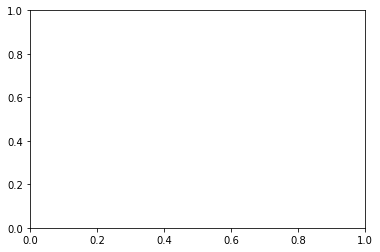

In [20]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

In [24]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

## batch running

In [ ]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


## Overall test

In [134]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

#### for in memory model

In [46]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()

ordinal data

In [50]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, and confusion matrix for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = np.sum(true_labels == predictions) / len(true_labels)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, f1, conf_matrix

# Example usage
true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix = calculate_metrics(target_list, pred_list)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.5623342175066313
F1 Score: 0.422835023809708


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

#### for saved model

In [51]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)


save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

In [25]:
# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

# List of thresholds as per the image provided by the user
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

# Example list of values to be checked against the thresholds
values = [3, 0.7, 0.4, 0.3, 10, 5, 1, 9, 7, 2, 3, 0.5, 0.3]  # This is a placeholder

# Get the binary list using the function defined above
binary_list = threshold_binary_list(pred_list[0][0], thresholds)
binary_list


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Getting accuracy and stuff

In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

100%|██████████| 1206/1206 [00:00<00:00, 120868.12it/s]


In [142]:
# testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

## Mic calc

In [54]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[0.72782607 0.77394133 0.96627392 0.99732814 0.57384106 0.71862384
 1.40909006 0.62500867 0.68552988 0.42204546 0.90296875 1.86967643
 1.116575  ]
0.9068252765540421


In [147]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[1.99657691e+01 2.19492095e-02 1.20861531e-01 1.84303685e-02
 2.18870026e+01 1.48684251e+01 1.62012543e+01 2.61311525e+01
 6.15298126e+00 2.21063227e-01 1.96245250e+00 1.24928044e+01
 9.46748127e-01]
9.30699186242598


## Ea calc

In [129]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [148]:
np.exp(pred_list[0])

array([0.21734211, 0.04858502, 0.07807854, 0.01177044, 1.1826788 ,
       1.069281  , 0.02535057, 1.8139412 , 0.41462198, 0.45923612,
       0.28088352, 0.1602019 , 0.06000657], dtype=float32)

In [135]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [111]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


NameError: name 'y_true' is not defined

In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

# Explanable AI

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP